<a href="https://colab.research.google.com/github/jishu123456789/ML_SRIP-24/blob/main/OneVsAll_CustomCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# In this notebook we will be using a Custom CNN model to train for only one class but with a GPU

import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

print(device)

Mounted at /content/drive
cuda


In [ ]:
"Let us first divide the test and train data into proper format"

import os
import shutil
import random

base_dir = "animals"

animal_dir = "//content//drive//My Drive//DeepLearningCollab//Animal"
os.makedirs(animal_dir , exist_ok=True)

# Now we go into the directry containing the animals


source_dir = "//content//drive//My Drive//DeepLearningCollab//animals"

#Destination Directories

train_dir = os.path.join(animal_dir , 'train')
test_dir = os.path.join(animal_dir , 'test')

"If train and test directories do not exist"

os.makedirs(train_dir , exist_ok=True)
os.makedirs(test_dir , exist_ok=True)

"Now  we can list all the directories in source_dir"

animal_directories_list = os.listdir(source_dir)

"Now we will loop through the directories"

for animal in animal_directories_list:
    animal_D = os.path.join(source_dir , animal)

    # Get a list of all the image files in the directory animal_D
    images = [i for i in os.listdir(animal_D) if os.path.isfile(os.path.join(animal_D , i))]

    train_test_spllit = 0.8

    num_train = int(len(images) * train_test_spllit)

    random.shuffle(images) # Shuffle the images randomly
    train_images = images[:num_train]

    test_images = images[num_train:]


    # Now we have already created test and train directory but here we have to also create test and train for each of the animals

    train_dir_animal = os.path.join(train_dir , animal)
    test_dir_animal = os.path.join(test_dir , animal)

    os.makedirs(train_dir_animal , exist_ok=True)
    os.makedirs(test_dir_animal , exist_ok=True)

    "Finally we have to move all the images from source directory to destination directory using shuttle"
    for img in train_images:
        shutil.move(os.path.join(animal_D , img) , os.path.join(train_dir_animal , img))
    for img in test_images:
        shutil.move(os.path.join(animal_D , img) , os.path.join(test_dir_animal , img))

In [ ]:
from pathlib import Path


train_path = os.path.join(animal_dir , "train")
test_path = os.path.join(animal_dir , "test")

animal_dir = Path(animal_dir)



# Using This we have also found out the class names and now we can convert them into Dict format

from typing import Tuple , Dict , List
train_path = Path(train_path)
test_path = Path(test_path)

def find_classes(directory : str) -> Tuple[List[str] , Dict[str,int]] :

    "Get the class_names first"

    classes = sorted(
        entry.name for entry in list(os.scandir(directory)) if entry.is_dir()
    )

    # Get the case to handle any kind of error

    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}")

    classes_to_idx = {cls_name : i for i , cls_name in enumerate(classes)}

    return classes , classes_to_idx

In [ ]:
"Now we will enter into the part where we will be transforming the image and creating Datasets and DataLoaders"
from torch.utils.data import DataLoader , TensorDataset , Dataset
from torchvision import transforms
import random
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

"Lets write the transform for training Data and Testing Data"

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(p = 0.5), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),   #must same as here
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

"""
Creating The Custom Dataset For One Vs Rest Classification:

1) In the custom dataset we must take in decide which will be our target class and which will be the other classes.
2) The target class will have the label as 1 and the other classes will have label as 0

"""
class CustomDataset(Dataset):

    def __init__(self , target_class_index , target_directory : str , transform = None):
        super().__init__()
        self.label = []
        self.img = []
        self.transform = transform

        # Here we can find the classes using find classes method

        classes , _ = find_classes(target_directory)
        target_class_name = classes[target_class_index]

        for Class in classes:

            if(Class == target_class_name):
              limit = 1
            else:
              limit = 0.1

            directory = os.path.join(target_directory , Class)
            for l , name in enumerate(os.listdir(directory)):
                if(l>=limit*len(os.listdir(directory))):
                    break
                final_path = os.path.join(directory , name)
                self.img.append(final_path)

                if(Class == target_class_name):
                    self.label.append(1)
                else:
                    self.label.append(0)

    def __len__(self):
        return len(self.img)

    def load_image(self, index: int) -> Image.Image:
        image_path = self.img[index]
        img = Image.open(image_path)
        return img

    def __getitem__(self, idx: int):
        image = Image.open(self.img[idx])


        Label = self.label[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(Label, dtype=torch.long)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import KFold

# Define your CustomDataset class and other necessary imports
# Assuming you have already defined CustomDataset and other imports



class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))

        x = self.relu(self.batch_norm2(self.conv2(x)))

        x = self.conv3(x)
        x = self.batch_norm3(x)

        #downsample if needed
        if self.i_downsample is not None:
            identity = self.i_downsample(identity)
        #add identity
        x+=identity
        x=self.relu(x)

        return x

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()


        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
      identity = x.clone()

      x = self.relu(self.batch_norm2(self.conv1(x)))
      x = self.batch_norm2(self.conv2(x))

      if self.i_downsample is not None:
          identity = self.i_downsample(identity)
      print(x.shape)
      print(identity.shape)
      x += identity
      x = self.relu(x)
      return x




class ResNet(nn.Module):
    def __init__(self, ResBlock, layer_list, num_classes, num_channels=3):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

        self.layer1 = self._make_layer(ResBlock, layer_list[0], planes=64)
        self.layer2 = self._make_layer(ResBlock, layer_list[1], planes=128, stride=2)
        self.layer3 = self._make_layer(ResBlock, layer_list[2], planes=256, stride=2)
        self.layer4 = self._make_layer(ResBlock, layer_list[3], planes=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512*ResBlock.expansion, num_classes)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, ResBlock, blocks, planes, stride=1):
        ii_downsample = None
        layers = []

        if stride != 1 or self.in_channels != planes*ResBlock.expansion:
            ii_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, planes*ResBlock.expansion, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes*ResBlock.expansion)
            )

        layers.append(ResBlock(self.in_channels, planes, i_downsample=ii_downsample, stride=stride))
        self.in_channels = planes*ResBlock.expansion

        for i in range(blocks-1):
            layers.append(ResBlock(self.in_channels, planes))

        return nn.Sequential(*layers)

def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,6,3], num_classes, channels)

def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, [3,4,23,3], num_classes, channels)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, [3,8,36,3], num_classes, channels)
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




antelope
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0211 Acc: 74.0854%
[Test #1] Loss: 0.0220 Acc: 93.9394% 
Epoch 1 running
[Train #2] Loss: 0.0153 Acc: 88.4146%
[Test #2] Loss: 0.0175 Acc: 93.9394% 
Epoch 2 running
[Train #3] Loss: 0.0133 Acc: 87.5000%
[Test #3] Loss: 0.0103 Acc: 95.1515% 
Epoch 3 running
[Train #4] Loss: 0.0130 Acc: 88.4146%
[Test #4] Loss: 0.0103 Acc: 93.9394% 
Epoch 4 running
[Train #5] Loss: 0.0135 Acc: 88.4146%
[Test #5] Loss: 0.0095 Acc: 93.3333% 
Epoch 5 running
[Train #6] Loss: 0.0123 Acc: 89.0244%
[Test #6] Loss: 0.0092 Acc: 93.9394% 
Epoch 6 running
[Train #7] Loss: 0.0123 Acc: 89.0244%
[Test #7] Loss: 0.0103 Acc: 91.5152% 
Epoch 7 running
[Train #8] Loss: 0.0120 Acc: 89.0244%
[Test #8] Loss: 0.0083 Acc: 94.5455% 
Epoch 8 running
[Train #9] Loss: 0.0129 Acc: 91.4634%
[Test #9] Loss: 0.0138 Acc: 85.4545% 
Epoch 9 running
[Train #10] Loss: 0.0114 Acc: 90.5488%
[Test #10] Loss: 0.0154 Acc: 90.3030% 
Epoch 10 running
[Train #11] Loss: 0.0117 Acc: 89.3293%
[Te

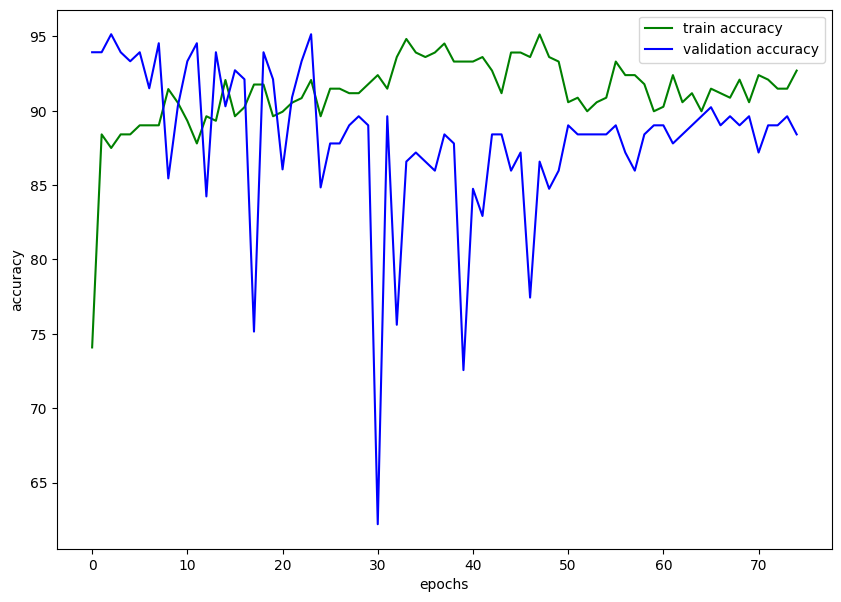

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[178   0]
 [ 12   0]]
badger
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0156 Acc: 82.6220%
[Test #1] Loss: 0.0158 Acc: 87.8788% 
Epoch 1 running
[Train #2] Loss: 0.0135 Acc: 91.4634%
[Test #2] Loss: 0.0197 Acc: 87.8788% 
Epoch 2 running
[Train #3] Loss: 0.0124 Acc: 91.4634%
[Test #3] Loss: 0.0162 Acc: 87.8788% 
Epoch 3 running
[Train #4] Loss: 0.0118 Acc: 91.7683%
[Test #4] Loss: 0.0285 Acc: 81.8182% 
Epoch 4 running
[Train #5] Loss: 0.0127 Acc: 91.4634%
[Test #5] Loss: 0.0154 Acc: 87.8788% 
Epoch 5 running
[Train #6] Loss: 0.0117 Acc: 91.4634%
[Test #6] Loss: 0.0154 Acc: 87.8788% 
Epoch 6 running
[Train #7] Loss: 0.0118 Acc: 91.4634%
[Test #7] Loss: 0.0207 Acc: 80.0000% 
Epoch 7 running
[Train #8] Loss: 0.0111 Acc: 91.7683%
[Test #8] Loss: 0.0184 Acc: 87.8788% 
Epoch 8 running
[Train #9] Loss: 0.0121 Acc: 91.4634%
[Test #9] Loss: 0.0139 Acc: 87.8788% 
Epoch 9 running
[Train #10] Loss: 0.0106 Acc: 91.7683%
[Test #10] 

Test_Accuracy : 65.78947368421053
Confusion Matrix on the test set
[[121  57]
 [  8   4]]
bat
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0225 Acc: 76.8293%
[Test #1] Loss: 0.0159 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0145 Acc: 89.0244%
[Test #2] Loss: 0.0133 Acc: 90.9091% 
Epoch 2 running
[Train #3] Loss: 0.0133 Acc: 90.2439%
[Test #3] Loss: 0.0108 Acc: 91.5152% 
Epoch 3 running
[Train #4] Loss: 0.0120 Acc: 90.2439%
[Test #4] Loss: 0.0131 Acc: 91.5152% 
Epoch 4 running
[Train #5] Loss: 0.0121 Acc: 90.8537%
[Test #5] Loss: 0.0129 Acc: 89.0909% 
Epoch 5 running
[Train #6] Loss: 0.0113 Acc: 91.1585%
[Test #6] Loss: 0.0131 Acc: 89.6970% 
Epoch 6 running
[Train #7] Loss: 0.0130 Acc: 89.6341%
[Test #7] Loss: 0.0129 Acc: 90.9091% 
Epoch 7 running
[Train #8] Loss: 0.0102 Acc: 91.4634%
[Test #8] Loss: 0.0447 Acc: 63.0303% 
Epoch 8 running
[Train #9] Loss: 0.0149 Acc: 88.4146%
[Test #9] Loss: 0.0163 Acc: 90.9091% 
Epoch 9 running
[Train #10] Loss: 0.0134 Acc: 89.3293%
[Test #10] Lo

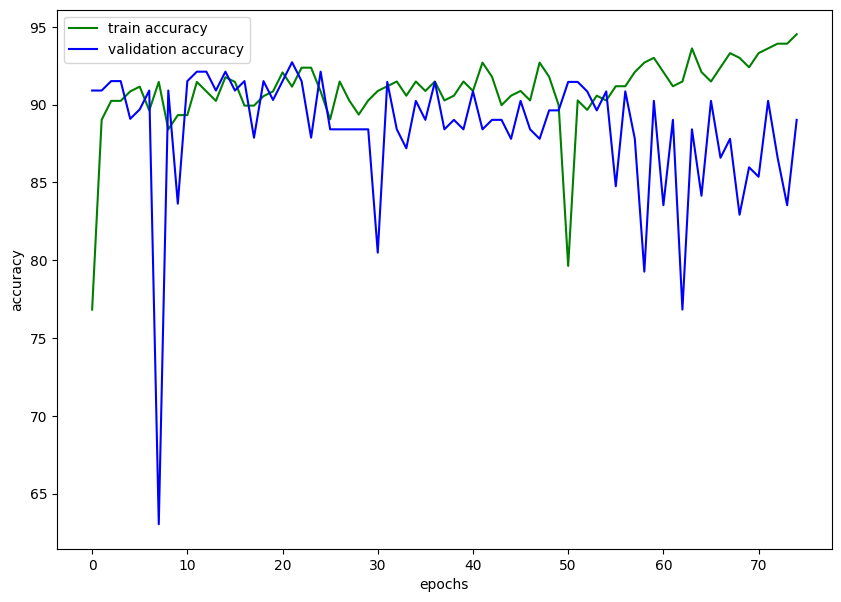

Test_Accuracy : 94.73684210526315
Confusion Matrix on the test set
[[178   0]
 [ 10   2]]
bear
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0228 Acc: 74.6951%
[Test #1] Loss: 0.0160 Acc: 88.4848% 
Epoch 1 running
[Train #2] Loss: 0.0151 Acc: 91.1585%
[Test #2] Loss: 0.0174 Acc: 88.4848% 
Epoch 2 running
[Train #3] Loss: 0.0128 Acc: 91.1585%
[Test #3] Loss: 0.0145 Acc: 88.4848% 
Epoch 3 running
[Train #4] Loss: 0.0126 Acc: 91.1585%
[Test #4] Loss: 0.0143 Acc: 88.4848% 
Epoch 4 running
[Train #5] Loss: 0.0122 Acc: 91.1585%
[Test #5] Loss: 0.0142 Acc: 88.4848% 
Epoch 5 running
[Train #6] Loss: 0.0118 Acc: 91.1585%
[Test #6] Loss: 0.0153 Acc: 85.4545% 
Epoch 6 running
[Train #7] Loss: 0.0117 Acc: 90.8537%
[Test #7] Loss: 0.0217 Acc: 81.2121% 
Epoch 7 running
[Train #8] Loss: 0.0113 Acc: 90.8537%
[Test #8] Loss: 0.0128 Acc: 89.6970% 
Epoch 8 running
[Train #9] Loss: 0.0109 Acc: 89.6341%
[Test #9] Loss: 0.0143 Acc: 88.4848% 
Epoch 9 running
[Train #10] Loss: 0.0109 Acc: 89.6341%
[Test #10] L

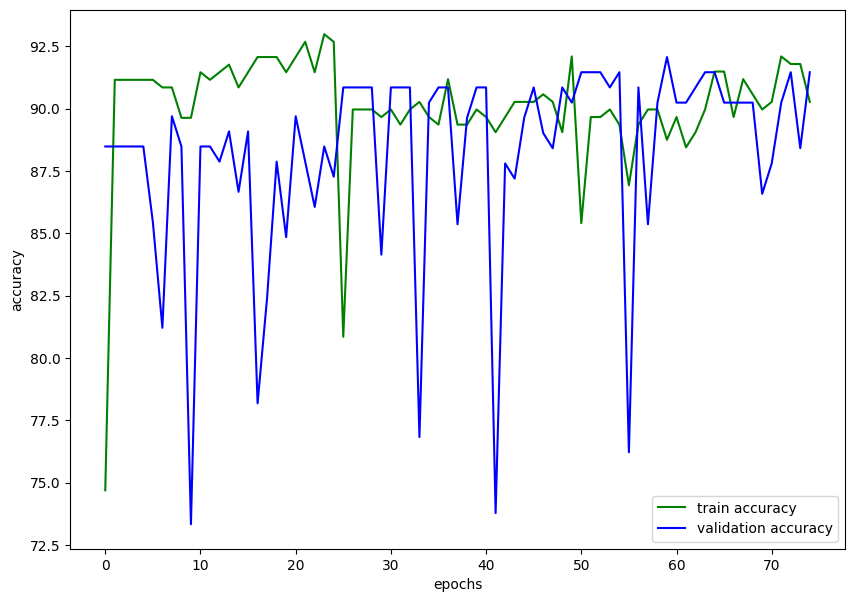

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[177   1]
 [ 11   1]]
bee
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0157 Acc: 88.1098%
[Test #1] Loss: 0.0123 Acc: 91.5152% 
Epoch 1 running
[Train #2] Loss: 0.0130 Acc: 89.6341%
[Test #2] Loss: 0.0199 Acc: 91.5152% 
Epoch 2 running
[Train #3] Loss: 0.0115 Acc: 90.2439%
[Test #3] Loss: 0.0157 Acc: 91.5152% 
Epoch 3 running
[Train #4] Loss: 0.0119 Acc: 87.1951%
[Test #4] Loss: 0.0283 Acc: 91.5152% 
Epoch 4 running
[Train #5] Loss: 0.0128 Acc: 91.1585%
[Test #5] Loss: 0.0152 Acc: 83.0303% 
Epoch 5 running
[Train #6] Loss: 0.0115 Acc: 90.8537%
[Test #6] Loss: 0.0114 Acc: 92.7273% 
Epoch 6 running
[Train #7] Loss: 0.0106 Acc: 91.7683%
[Test #7] Loss: 0.0128 Acc: 91.5152% 
Epoch 7 running
[Train #8] Loss: 0.0104 Acc: 91.4634%
[Test #8] Loss: 0.0095 Acc: 93.9394% 
Epoch 8 running
[Train #9] Loss: 0.0100 Acc: 92.0732%
[Test #9] Loss: 0.0087 Acc: 93.3333% 
Epoch 9 running
[Train #10] Loss: 0.0088 Acc: 93.9024%
[Test #10] Los

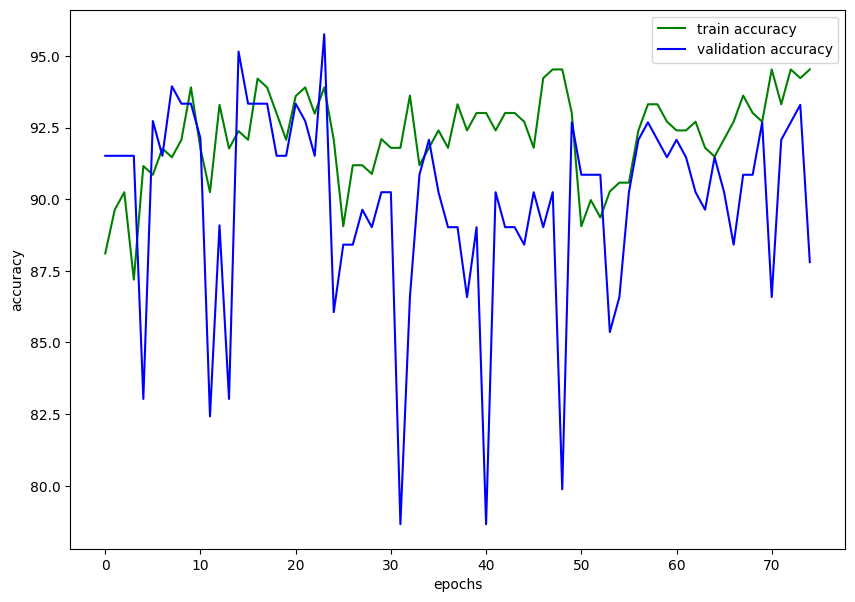

Test_Accuracy : 90.52631578947368
Confusion Matrix on the test set
[[164  14]
 [  4   8]]
beetle
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0185 Acc: 82.9268%
[Test #1] Loss: 0.0144 Acc: 89.6970% 
Epoch 1 running
[Train #2] Loss: 0.0153 Acc: 90.2439%
[Test #2] Loss: 0.0181 Acc: 89.6970% 
Epoch 2 running
[Train #3] Loss: 0.0127 Acc: 90.8537%
[Test #3] Loss: 0.0153 Acc: 89.6970% 
Epoch 3 running
[Train #4] Loss: 0.0129 Acc: 90.2439%
[Test #4] Loss: 0.0132 Acc: 89.6970% 
Epoch 4 running
[Train #5] Loss: 0.0122 Acc: 90.5488%
[Test #5] Loss: 0.0175 Acc: 83.6364% 
Epoch 5 running
[Train #6] Loss: 0.0126 Acc: 90.5488%
[Test #6] Loss: 0.0151 Acc: 86.0606% 
Epoch 6 running
[Train #7] Loss: 0.0116 Acc: 91.7683%
[Test #7] Loss: 0.0139 Acc: 89.0909% 
Epoch 7 running
[Train #8] Loss: 0.0109 Acc: 92.0732%
[Test #8] Loss: 0.0298 Acc: 78.7879% 
Epoch 8 running
[Train #9] Loss: 0.0116 Acc: 91.1585%
[Test #9] Loss: 0.0193 Acc: 89.0909% 
Epoch 9 running
[Train #10] Loss: 0.0108 Acc: 92.3780%
[Test #10]

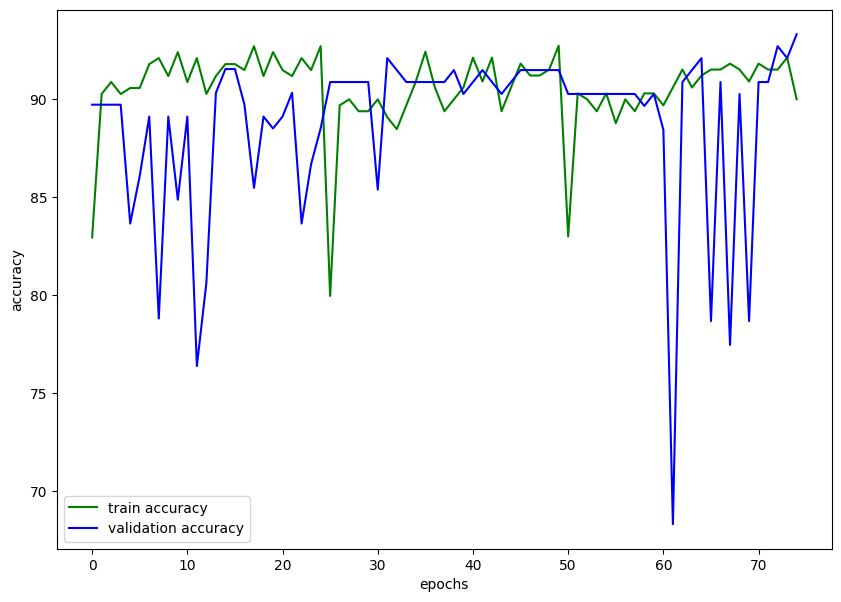

Test_Accuracy : 92.63157894736842
Confusion Matrix on the test set
[[172   6]
 [  8   4]]
bison
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0150 Acc: 87.5000%
[Test #1] Loss: 0.0151 Acc: 88.4848% 
Epoch 1 running
[Train #2] Loss: 0.0132 Acc: 91.1585%
[Test #2] Loss: 0.0180 Acc: 88.4848% 
Epoch 2 running
[Train #3] Loss: 0.0121 Acc: 91.1585%
[Test #3] Loss: 0.0161 Acc: 88.4848% 
Epoch 3 running
[Train #4] Loss: 0.0119 Acc: 91.1585%
[Test #4] Loss: 0.0130 Acc: 88.4848% 
Epoch 4 running
[Train #5] Loss: 0.0120 Acc: 90.8537%
[Test #5] Loss: 0.0227 Acc: 70.3030% 
Epoch 5 running
[Train #6] Loss: 0.0112 Acc: 91.7683%
[Test #6] Loss: 0.0129 Acc: 87.8788% 
Epoch 6 running
[Train #7] Loss: 0.0124 Acc: 90.5488%
[Test #7] Loss: 0.0180 Acc: 88.4848% 
Epoch 7 running
[Train #8] Loss: 0.0116 Acc: 91.1585%
[Test #8] Loss: 0.0119 Acc: 88.4848% 
Epoch 8 running
[Train #9] Loss: 0.0100 Acc: 91.1585%
[Test #9] Loss: 0.0110 Acc: 88.4848% 
Epoch 9 running
[Train #10] Loss: 0.0102 Acc: 90.5488%
[Test #10] 

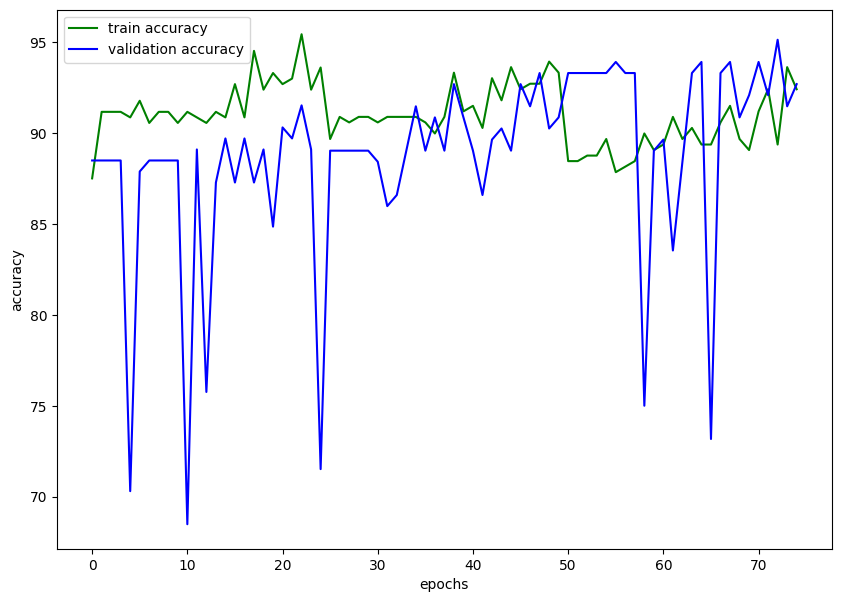

Test_Accuracy : 92.63157894736842
Confusion Matrix on the test set
[[170   8]
 [  6   6]]
boar
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0199 Acc: 78.0488%
[Test #1] Loss: 0.0176 Acc: 91.5152% 
Epoch 1 running
[Train #2] Loss: 0.0128 Acc: 89.3293%
[Test #2] Loss: 0.0333 Acc: 21.8182% 
Epoch 2 running
[Train #3] Loss: 0.0130 Acc: 89.3293%
[Test #3] Loss: 0.0177 Acc: 86.0606% 
Epoch 3 running
[Train #4] Loss: 0.0125 Acc: 89.3293%
[Test #4] Loss: 0.0163 Acc: 89.0909% 
Epoch 4 running
[Train #5] Loss: 0.0118 Acc: 89.6341%
[Test #5] Loss: 0.0094 Acc: 91.5152% 
Epoch 5 running
[Train #6] Loss: 0.0112 Acc: 89.3293%
[Test #6] Loss: 0.0098 Acc: 92.1212% 
Epoch 6 running
[Train #7] Loss: 0.0126 Acc: 90.2439%
[Test #7] Loss: 0.0100 Acc: 91.5152% 
Epoch 7 running
[Train #8] Loss: 0.0116 Acc: 88.4146%
[Test #8] Loss: 0.0149 Acc: 88.4848% 
Epoch 8 running
[Train #9] Loss: 0.0113 Acc: 90.2439%
[Test #9] Loss: 0.0116 Acc: 90.3030% 
Epoch 9 running
[Train #10] Loss: 0.0100 Acc: 91.1585%
[Test #10] L

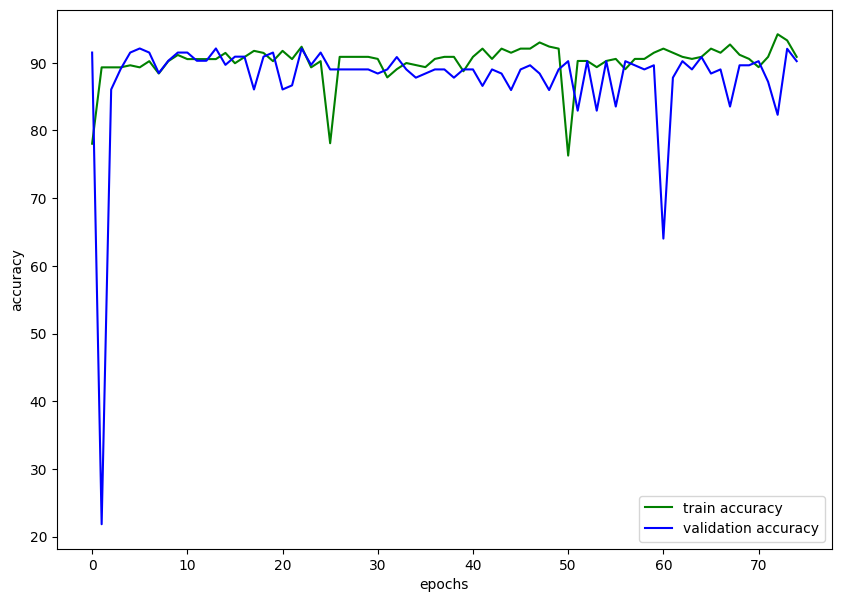

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[178   0]
 [ 12   0]]
butterfly
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0153 Acc: 89.0244%
[Test #1] Loss: 0.0129 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0121 Acc: 90.2439%
[Test #2] Loss: 0.0207 Acc: 90.9091% 
Epoch 2 running
[Train #3] Loss: 0.0111 Acc: 89.9390%
[Test #3] Loss: 0.0177 Acc: 90.9091% 
Epoch 3 running
[Train #4] Loss: 0.0113 Acc: 90.2439%
[Test #4] Loss: 0.0138 Acc: 90.9091% 
Epoch 4 running
[Train #5] Loss: 0.0093 Acc: 89.3293%
[Test #5] Loss: 0.0109 Acc: 90.9091% 
Epoch 5 running
[Train #6] Loss: 0.0094 Acc: 91.4634%
[Test #6] Loss: 0.0094 Acc: 92.7273% 
Epoch 6 running
[Train #7] Loss: 0.0078 Acc: 92.0732%
[Test #7] Loss: 0.0092 Acc: 91.5152% 
Epoch 7 running
[Train #8] Loss: 0.0084 Acc: 91.4634%
[Test #8] Loss: 0.0152 Acc: 83.6364% 
Epoch 8 running
[Train #9] Loss: 0.0098 Acc: 90.8537%
[Test #9] Loss: 0.0228 Acc: 83.0303% 
Epoch 9 running
[Train #10] Loss: 0.0123 Acc: 90.8537%
[Test #1

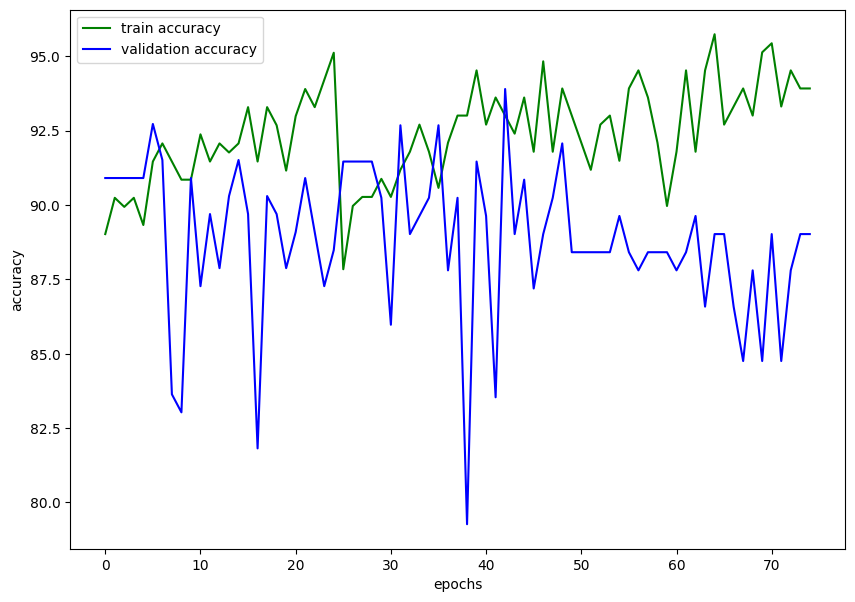

Test_Accuracy : 93.15789473684211
Confusion Matrix on the test set
[[177   1]
 [ 12   0]]
cat
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0177 Acc: 85.3659%
[Test #1] Loss: 0.0142 Acc: 90.3030% 
Epoch 1 running
[Train #2] Loss: 0.0143 Acc: 90.2439%
[Test #2] Loss: 0.0135 Acc: 90.3030% 
Epoch 2 running
[Train #3] Loss: 0.0129 Acc: 90.2439%
[Test #3] Loss: 0.0138 Acc: 89.6970% 
Epoch 3 running
[Train #4] Loss: 0.0134 Acc: 89.6341%
[Test #4] Loss: 0.0127 Acc: 89.0909% 
Epoch 4 running
[Train #5] Loss: 0.0124 Acc: 89.6341%
[Test #5] Loss: 0.0138 Acc: 89.6970% 
Epoch 5 running
[Train #6] Loss: 0.0130 Acc: 89.0244%
[Test #6] Loss: 0.0142 Acc: 90.3030% 
Epoch 6 running
[Train #7] Loss: 0.0126 Acc: 90.2439%
[Test #7] Loss: 0.0159 Acc: 90.3030% 
Epoch 7 running
[Train #8] Loss: 0.0124 Acc: 90.2439%
[Test #8] Loss: 0.0166 Acc: 87.2727% 
Epoch 8 running
[Train #9] Loss: 0.0120 Acc: 90.5488%
[Test #9] Loss: 0.0166 Acc: 89.6970% 
Epoch 9 running
[Train #10] Loss: 0.0131 Acc: 89.9390%
[Test #10] Lo

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[177   1]
 [ 11   1]]
caterpillar
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0199 Acc: 78.6585%
[Test #1] Loss: 0.0150 Acc: 90.3030% 
Epoch 1 running
[Train #2] Loss: 0.0154 Acc: 89.3293%
[Test #2] Loss: 0.0193 Acc: 90.3030% 
Epoch 2 running
[Train #3] Loss: 0.0126 Acc: 89.3293%
[Test #3] Loss: 0.0103 Acc: 92.7273% 
Epoch 3 running
[Train #4] Loss: 0.0089 Acc: 92.0732%
[Test #4] Loss: 0.0103 Acc: 92.1212% 
Epoch 4 running
[Train #5] Loss: 0.0088 Acc: 93.2927%
[Test #5] Loss: 0.0092 Acc: 90.3030% 
Epoch 5 running
[Train #6] Loss: 0.0093 Acc: 91.1585%
[Test #6] Loss: 0.0099 Acc: 91.5152% 
Epoch 6 running
[Train #7] Loss: 0.0074 Acc: 92.6829%
[Test #7] Loss: 0.0088 Acc: 89.0909% 
Epoch 7 running
[Train #8] Loss: 0.0069 Acc: 93.2927%
[Test #8] Loss: 0.0173 Acc: 86.0606% 
Epoch 8 running
[Train #9] Loss: 0.0072 Acc: 93.5976%
[Test #9] Loss: 0.0098 Acc: 92.1212% 
Epoch 9 running
[Train #10] Loss: 0.0070 Acc: 94.2073%
[Test 

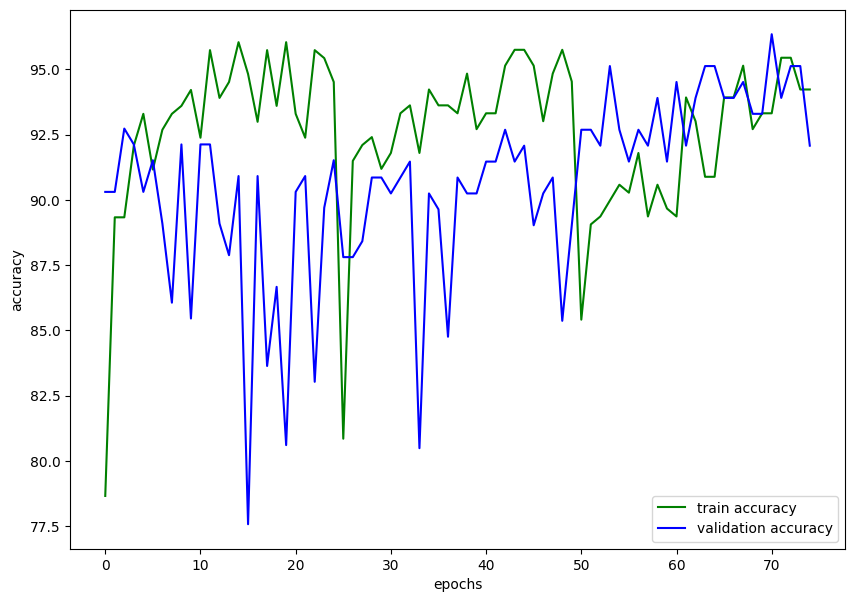

Test_Accuracy : 80.52631578947368
Confusion Matrix on the test set
[[146  32]
 [  5   7]]
chimpanzee
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0165 Acc: 83.2317%
[Test #1] Loss: 0.0241 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0148 Acc: 89.9390%
[Test #2] Loss: 0.0133 Acc: 90.3030% 
Epoch 2 running
[Train #3] Loss: 0.0140 Acc: 89.3293%
[Test #3] Loss: 0.0109 Acc: 90.9091% 
Epoch 3 running
[Train #4] Loss: 0.0119 Acc: 89.6341%
[Test #4] Loss: 0.0117 Acc: 90.9091% 
Epoch 4 running
[Train #5] Loss: 0.0102 Acc: 90.2439%
[Test #5] Loss: 0.0104 Acc: 90.3030% 
Epoch 5 running
[Train #6] Loss: 0.0105 Acc: 90.8537%
[Test #6] Loss: 0.0134 Acc: 88.4848% 
Epoch 6 running
[Train #7] Loss: 0.0111 Acc: 90.2439%
[Test #7] Loss: 0.0101 Acc: 91.5152% 
Epoch 7 running
[Train #8] Loss: 0.0115 Acc: 89.0244%
[Test #8] Loss: 0.0121 Acc: 90.9091% 
Epoch 8 running
[Train #9] Loss: 0.0097 Acc: 90.2439%
[Test #9] Loss: 0.0116 Acc: 90.9091% 
Epoch 9 running
[Train #10] Loss: 0.0090 Acc: 90.2439%
[Test 

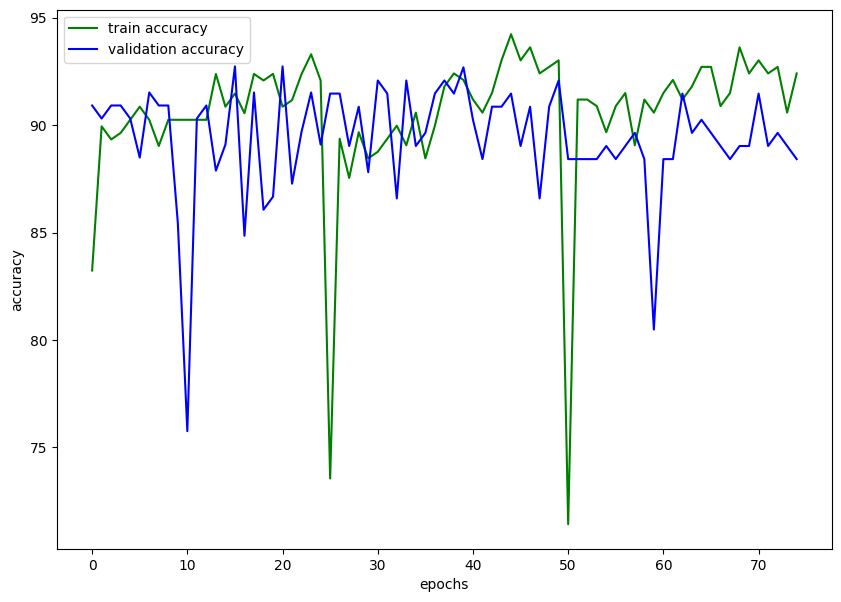

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[178   0]
 [ 12   0]]
cockroach
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0148 Acc: 89.3293%
[Test #1] Loss: 0.0128 Acc: 91.5152% 
Epoch 1 running
[Train #2] Loss: 0.0129 Acc: 89.6341%
[Test #2] Loss: 0.0130 Acc: 91.5152% 
Epoch 2 running
[Train #3] Loss: 0.0152 Acc: 89.6341%
[Test #3] Loss: 0.0102 Acc: 92.1212% 
Epoch 3 running
[Train #4] Loss: 0.0125 Acc: 88.7195%
[Test #4] Loss: 0.0140 Acc: 91.5152% 
Epoch 4 running
[Train #5] Loss: 0.0126 Acc: 89.0244%
[Test #5] Loss: 0.0098 Acc: 90.9091% 
Epoch 5 running
[Train #6] Loss: 0.0117 Acc: 88.7195%
[Test #6] Loss: 0.0098 Acc: 92.1212% 
Epoch 6 running
[Train #7] Loss: 0.0112 Acc: 88.7195%
[Test #7] Loss: 0.0088 Acc: 92.1212% 
Epoch 7 running
[Train #8] Loss: 0.0110 Acc: 88.4146%
[Test #8] Loss: 0.0236 Acc: 81.2121% 
Epoch 8 running
[Train #9] Loss: 0.0097 Acc: 89.9390%
[Test #9] Loss: 0.0136 Acc: 91.5152% 
Epoch 9 running
[Train #10] Loss: 0.0111 Acc: 88.7195%
[Test #1

Test_Accuracy : 96.3157894736842
Confusion Matrix on the test set
[[173   5]
 [  2  10]]
cow
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0196 Acc: 81.7073%
[Test #1] Loss: 0.0124 Acc: 91.5152% 
Epoch 1 running
[Train #2] Loss: 0.0160 Acc: 89.6341%
[Test #2] Loss: 0.0208 Acc: 91.5152% 
Epoch 2 running
[Train #3] Loss: 0.0145 Acc: 89.3293%
[Test #3] Loss: 0.0136 Acc: 91.5152% 
Epoch 3 running
[Train #4] Loss: 0.0133 Acc: 89.3293%
[Test #4] Loss: 0.0148 Acc: 87.8788% 
Epoch 4 running
[Train #5] Loss: 0.0137 Acc: 88.7195%
[Test #5] Loss: 0.0123 Acc: 90.9091% 
Epoch 5 running
[Train #6] Loss: 0.0134 Acc: 88.7195%
[Test #6] Loss: 0.0202 Acc: 91.5152% 
Epoch 6 running
[Train #7] Loss: 0.0164 Acc: 89.6341%
[Test #7] Loss: 0.0399 Acc: 73.9394% 
Epoch 7 running
[Train #8] Loss: 0.0144 Acc: 89.3293%
[Test #8] Loss: 0.0167 Acc: 91.5152% 
Epoch 8 running
[Train #9] Loss: 0.0143 Acc: 87.8049%
[Test #9] Loss: 0.0122 Acc: 91.5152% 
Epoch 9 running
[Train #10] Loss: 0.0125 Acc: 89.6341%
[Test #10] Los

Test_Accuracy : 45.26315789473684
Confusion Matrix on the test set
[[ 77 101]
 [  3   9]]
coyote
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0143 Acc: 89.3293%
[Test #1] Loss: 0.0178 Acc: 87.8788% 
Epoch 1 running
[Train #2] Loss: 0.0125 Acc: 91.4634%
[Test #2] Loss: 0.0158 Acc: 87.8788% 
Epoch 2 running
[Train #3] Loss: 0.0116 Acc: 91.4634%
[Test #3] Loss: 0.0144 Acc: 87.8788% 
Epoch 3 running
[Train #4] Loss: 0.0118 Acc: 91.4634%
[Test #4] Loss: 0.0157 Acc: 87.8788% 
Epoch 4 running
[Train #5] Loss: 0.0113 Acc: 91.4634%
[Test #5] Loss: 0.0136 Acc: 86.6667% 
Epoch 5 running
[Train #6] Loss: 0.0121 Acc: 90.5488%
[Test #6] Loss: 0.0180 Acc: 87.8788% 
Epoch 6 running
[Train #7] Loss: 0.0124 Acc: 90.2439%
[Test #7] Loss: 0.0137 Acc: 87.8788% 
Epoch 7 running
[Train #8] Loss: 0.0107 Acc: 91.1585%
[Test #8] Loss: 0.0153 Acc: 84.8485% 
Epoch 8 running
[Train #9] Loss: 0.0106 Acc: 90.8537%
[Test #9] Loss: 0.0133 Acc: 87.8788% 
Epoch 9 running
[Train #10] Loss: 0.0108 Acc: 91.4634%
[Test #10]

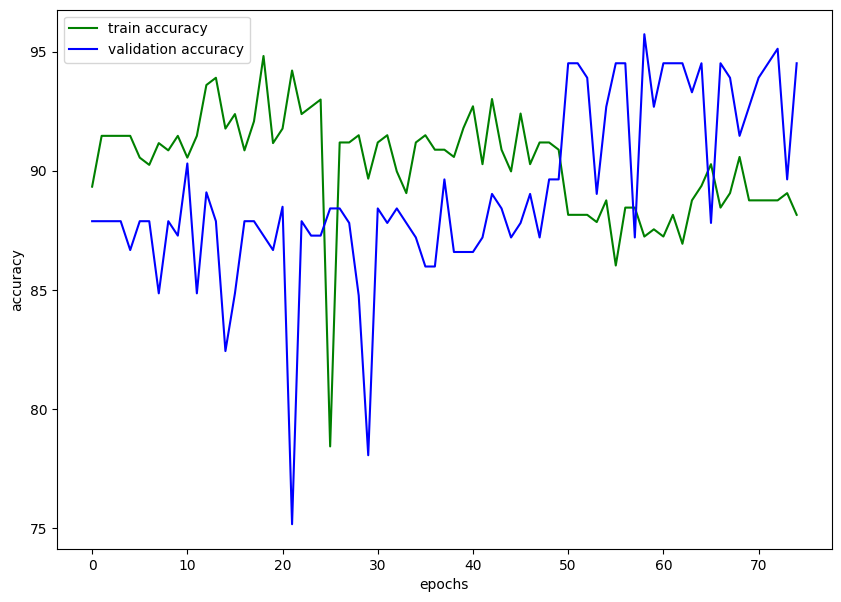

Test_Accuracy : 91.05263157894737
Confusion Matrix on the test set
[[170   8]
 [  9   3]]
crab
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0202 Acc: 73.4756%
[Test #1] Loss: 0.0166 Acc: 87.8788% 
Epoch 1 running
[Train #2] Loss: 0.0106 Acc: 92.0732%
[Test #2] Loss: 0.0285 Acc: 87.8788% 
Epoch 2 running
[Train #3] Loss: 0.0104 Acc: 92.3780%
[Test #3] Loss: 0.0225 Acc: 87.8788% 
Epoch 3 running
[Train #4] Loss: 0.0102 Acc: 91.4634%
[Test #4] Loss: 0.0183 Acc: 86.6667% 
Epoch 4 running
[Train #5] Loss: 0.0093 Acc: 91.7683%
[Test #5] Loss: 0.0210 Acc: 86.6667% 
Epoch 5 running
[Train #6] Loss: 0.0091 Acc: 92.6829%
[Test #6] Loss: 0.0238 Acc: 86.0606% 
Epoch 6 running
[Train #7] Loss: 0.0098 Acc: 92.0732%
[Test #7] Loss: 0.0305 Acc: 81.2121% 
Epoch 7 running
[Train #8] Loss: 0.0101 Acc: 91.1585%
[Test #8] Loss: 0.0195 Acc: 84.8485% 
Epoch 8 running
[Train #9] Loss: 0.0091 Acc: 93.2927%
[Test #9] Loss: 0.0158 Acc: 88.4848% 
Epoch 9 running
[Train #10] Loss: 0.0094 Acc: 92.6829%
[Test #10] L

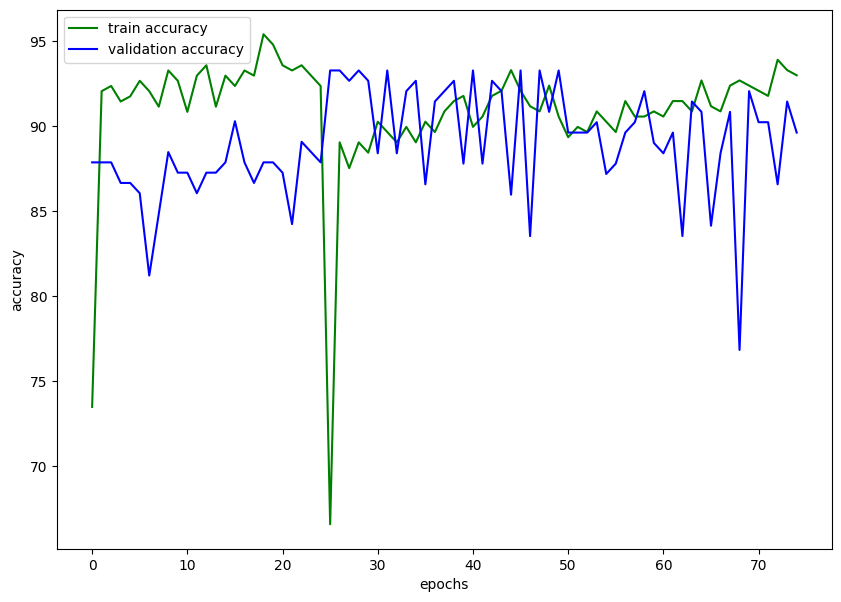

Test_Accuracy : 92.63157894736842
Confusion Matrix on the test set
[[169   9]
 [  5   7]]
crow
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0180 Acc: 80.1829%
[Test #1] Loss: 0.0153 Acc: 89.0909% 
Epoch 1 running
[Train #2] Loss: 0.0129 Acc: 90.8537%
[Test #2] Loss: 0.0216 Acc: 89.0909% 
Epoch 2 running
[Train #3] Loss: 0.0130 Acc: 88.7195%
[Test #3] Loss: 0.0138 Acc: 85.4545% 
Epoch 3 running
[Train #4] Loss: 0.0109 Acc: 91.1585%
[Test #4] Loss: 0.0152 Acc: 88.4848% 
Epoch 4 running
[Train #5] Loss: 0.0088 Acc: 91.1585%
[Test #5] Loss: 0.0203 Acc: 84.8485% 
Epoch 5 running
[Train #6] Loss: 0.0095 Acc: 91.4634%
[Test #6] Loss: 0.0135 Acc: 87.8788% 
Epoch 6 running
[Train #7] Loss: 0.0088 Acc: 89.9390%
[Test #7] Loss: 0.0341 Acc: 73.3333% 
Epoch 7 running
[Train #8] Loss: 0.0086 Acc: 93.2927%
[Test #8] Loss: 0.0214 Acc: 84.8485% 
Epoch 8 running
[Train #9] Loss: 0.0079 Acc: 93.2927%
[Test #9] Loss: 0.0291 Acc: 77.5758% 
Epoch 9 running
[Train #10] Loss: 0.0096 Acc: 91.4634%
[Test #10] L

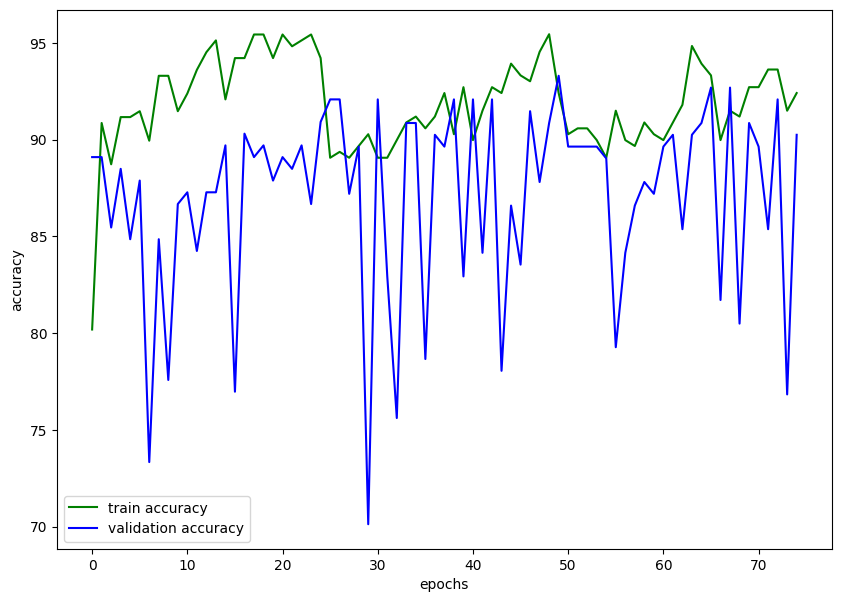

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[178   0]
 [ 12   0]]
deer
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0161 Acc: 86.5854%
[Test #1] Loss: 0.0163 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0145 Acc: 89.9390%
[Test #2] Loss: 0.0152 Acc: 90.9091% 
Epoch 2 running
[Train #3] Loss: 0.0141 Acc: 90.2439%
[Test #3] Loss: 0.0139 Acc: 90.9091% 
Epoch 3 running
[Train #4] Loss: 0.0133 Acc: 90.2439%
[Test #4] Loss: 0.0132 Acc: 90.9091% 
Epoch 4 running
[Train #5] Loss: 0.0135 Acc: 89.6341%
[Test #5] Loss: 0.0126 Acc: 89.6970% 
Epoch 5 running
[Train #6] Loss: 0.0126 Acc: 89.9390%
[Test #6] Loss: 0.0142 Acc: 87.8788% 
Epoch 6 running
[Train #7] Loss: 0.0128 Acc: 89.6341%
[Test #7] Loss: 0.0125 Acc: 91.5152% 
Epoch 7 running
[Train #8] Loss: 0.0126 Acc: 89.6341%
[Test #8] Loss: 0.0123 Acc: 90.9091% 
Epoch 8 running
[Train #9] Loss: 0.0122 Acc: 89.9390%
[Test #9] Loss: 0.0120 Acc: 91.5152% 
Epoch 9 running
[Train #10] Loss: 0.0125 Acc: 89.6341%
[Test #10] Lo

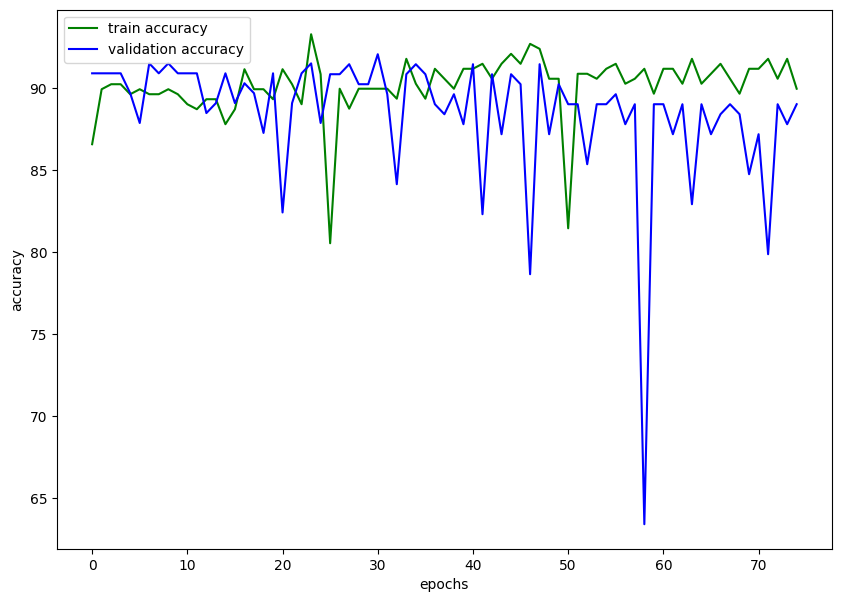

Test_Accuracy : 93.15789473684211
Confusion Matrix on the test set
[[176   2]
 [ 11   1]]
dog
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0179 Acc: 81.7073%
[Test #1] Loss: 0.0154 Acc: 89.0909% 
Epoch 1 running
[Train #2] Loss: 0.0144 Acc: 90.8537%
[Test #2] Loss: 0.0160 Acc: 89.0909% 
Epoch 2 running
[Train #3] Loss: 0.0118 Acc: 91.1585%
[Test #3] Loss: 0.0150 Acc: 88.4848% 
Epoch 3 running
[Train #4] Loss: 0.0119 Acc: 91.1585%
[Test #4] Loss: 0.0140 Acc: 89.0909% 
Epoch 4 running
[Train #5] Loss: 0.0125 Acc: 90.5488%
[Test #5] Loss: 0.0133 Acc: 89.6970% 
Epoch 5 running
[Train #6] Loss: 0.0123 Acc: 91.1585%
[Test #6] Loss: 0.0224 Acc: 76.9697% 
Epoch 6 running
[Train #7] Loss: 0.0114 Acc: 89.0244%
[Test #7] Loss: 0.0186 Acc: 89.0909% 
Epoch 7 running
[Train #8] Loss: 0.0135 Acc: 90.8537%
[Test #8] Loss: 0.0137 Acc: 88.4848% 
Epoch 8 running
[Train #9] Loss: 0.0116 Acc: 89.3293%
[Test #9] Loss: 0.0228 Acc: 84.2424% 
Epoch 9 running
[Train #10] Loss: 0.0115 Acc: 90.8537%
[Test #10] Lo

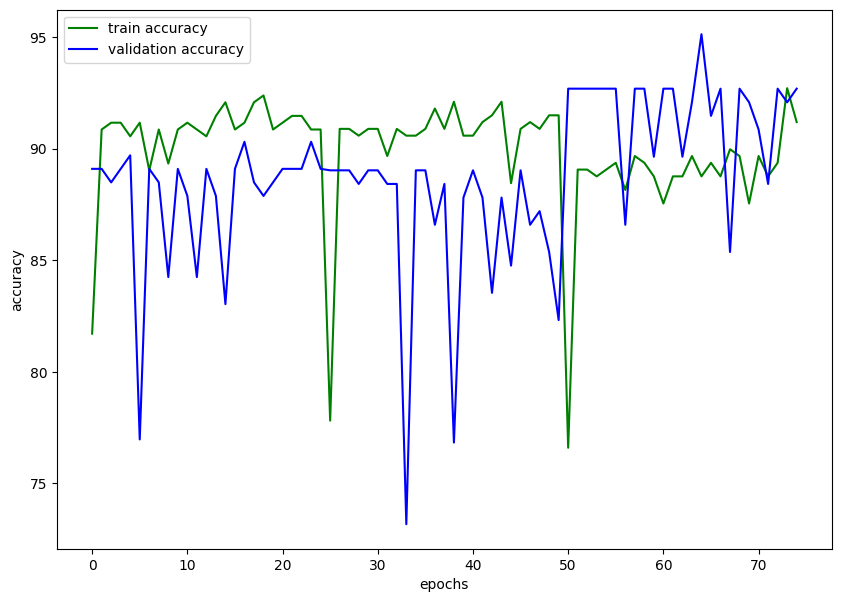

Test_Accuracy : 92.10526315789474
Confusion Matrix on the test set
[[175   3]
 [ 12   0]]
dolphin
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0137 Acc: 90.5488%
[Test #1] Loss: 0.0142 Acc: 89.6970% 
Epoch 1 running
[Train #2] Loss: 0.0098 Acc: 92.0732%
[Test #2] Loss: 0.0129 Acc: 89.6970% 
Epoch 2 running
[Train #3] Loss: 0.0100 Acc: 88.7195%
[Test #3] Loss: 0.0108 Acc: 90.9091% 
Epoch 3 running
[Train #4] Loss: 0.0078 Acc: 93.5976%
[Test #4] Loss: 0.0101 Acc: 90.3030% 
Epoch 4 running
[Train #5] Loss: 0.0082 Acc: 92.6829%
[Test #5] Loss: 0.0103 Acc: 90.9091% 
Epoch 5 running
[Train #6] Loss: 0.0079 Acc: 92.0732%
[Test #6] Loss: 0.0102 Acc: 91.5152% 
Epoch 6 running
[Train #7] Loss: 0.0071 Acc: 94.2073%
[Test #7] Loss: 0.0074 Acc: 93.9394% 
Epoch 7 running
[Train #8] Loss: 0.0056 Acc: 96.0366%
[Test #8] Loss: 0.0058 Acc: 93.9394% 
Epoch 8 running
[Train #9] Loss: 0.0059 Acc: 95.1220%
[Test #9] Loss: 0.0087 Acc: 90.3030% 
Epoch 9 running
[Train #10] Loss: 0.0068 Acc: 94.8171%
[Test #10

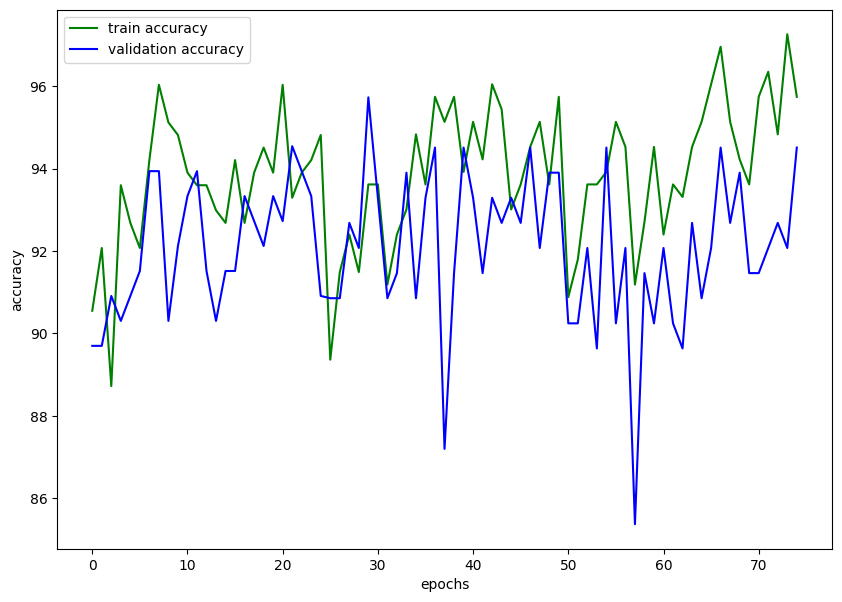

Test_Accuracy : 95.26315789473684
Confusion Matrix on the test set
[[170   8]
 [  1  11]]
donkey
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0154 Acc: 88.4146%
[Test #1] Loss: 0.0116 Acc: 92.7273% 
Epoch 1 running
[Train #2] Loss: 0.0147 Acc: 89.0244%
[Test #2] Loss: 0.0177 Acc: 92.7273% 
Epoch 2 running
[Train #3] Loss: 0.0142 Acc: 89.0244%
[Test #3] Loss: 0.0117 Acc: 92.7273% 
Epoch 3 running
[Train #4] Loss: 0.0148 Acc: 89.0244%
[Test #4] Loss: 0.0149 Acc: 92.1212% 
Epoch 4 running
[Train #5] Loss: 0.0128 Acc: 89.0244%
[Test #5] Loss: 0.0100 Acc: 92.7273% 
Epoch 5 running
[Train #6] Loss: 0.0153 Acc: 88.1098%
[Test #6] Loss: 0.0111 Acc: 92.7273% 
Epoch 6 running
[Train #7] Loss: 0.0138 Acc: 89.0244%
[Test #7] Loss: 0.0116 Acc: 92.7273% 
Epoch 7 running
[Train #8] Loss: 0.0129 Acc: 89.0244%
[Test #8] Loss: 0.0114 Acc: 92.1212% 
Epoch 8 running
[Train #9] Loss: 0.0134 Acc: 88.1098%
[Test #9] Loss: 0.0106 Acc: 92.7273% 
Epoch 9 running
[Train #10] Loss: 0.0141 Acc: 89.0244%
[Test #10]

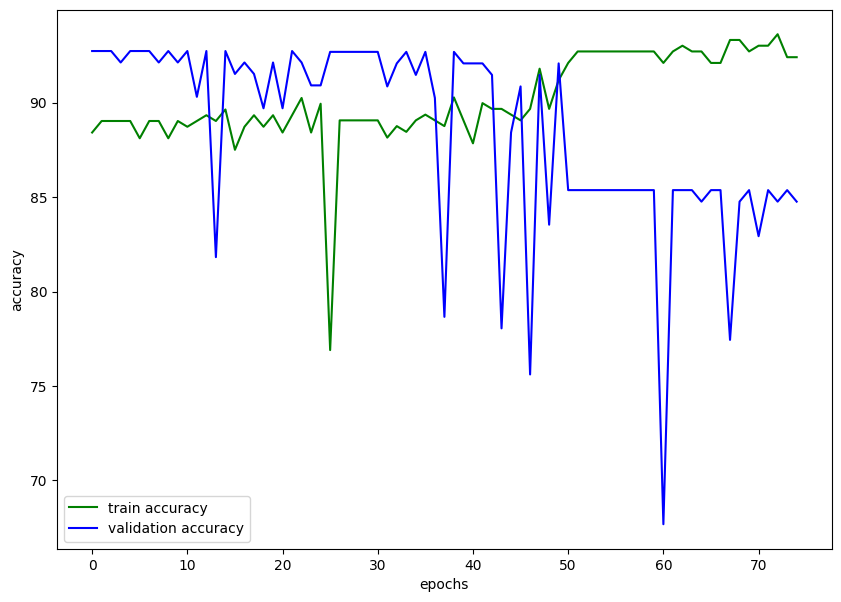

Test_Accuracy : 92.63157894736842
Confusion Matrix on the test set
[[175   3]
 [ 11   1]]
dragonfly
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0140 Acc: 89.6341%
[Test #1] Loss: 0.0174 Acc: 89.6970% 
Epoch 1 running
[Train #2] Loss: 0.0137 Acc: 89.9390%
[Test #2] Loss: 0.0143 Acc: 89.6970% 
Epoch 2 running
[Train #3] Loss: 0.0125 Acc: 90.8537%
[Test #3] Loss: 0.0108 Acc: 91.5152% 
Epoch 3 running
[Train #4] Loss: 0.0113 Acc: 91.4634%
[Test #4] Loss: 0.0106 Acc: 91.5152% 
Epoch 4 running
[Train #5] Loss: 0.0103 Acc: 90.5488%
[Test #5] Loss: 0.0109 Acc: 90.9091% 
Epoch 5 running
[Train #6] Loss: 0.0100 Acc: 90.8537%
[Test #6] Loss: 0.0115 Acc: 91.5152% 
Epoch 6 running
[Train #7] Loss: 0.0106 Acc: 89.9390%
[Test #7] Loss: 0.0339 Acc: 79.3939% 
Epoch 7 running
[Train #8] Loss: 0.0095 Acc: 91.1585%
[Test #8] Loss: 0.0134 Acc: 87.2727% 
Epoch 8 running
[Train #9] Loss: 0.0101 Acc: 91.7683%
[Test #9] Loss: 0.0124 Acc: 89.6970% 
Epoch 9 running
[Train #10] Loss: 0.0093 Acc: 92.3780%
[Test #

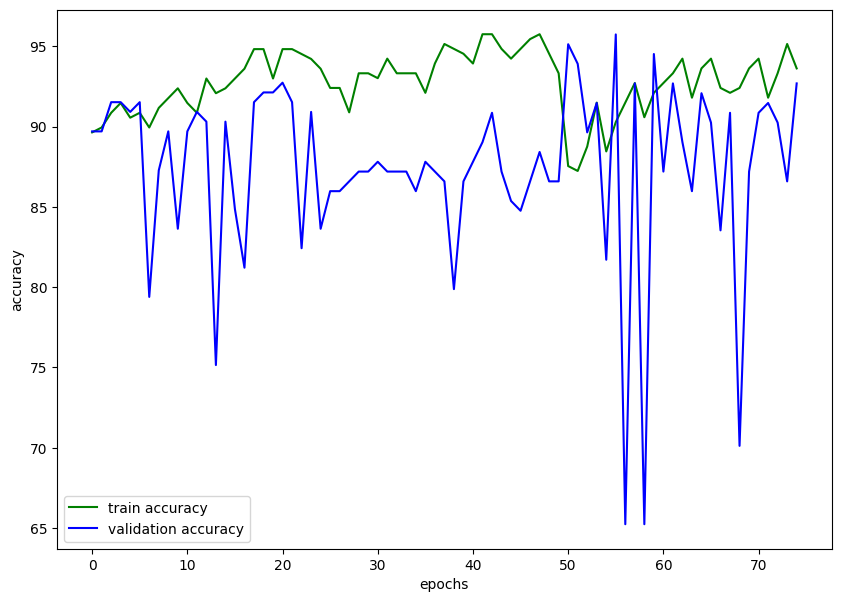

Test_Accuracy : 94.21052631578948
Confusion Matrix on the test set
[[172   6]
 [  5   7]]
duck
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0162 Acc: 90.2439%
[Test #1] Loss: 0.0172 Acc: 89.6970% 
Epoch 1 running
[Train #2] Loss: 0.0133 Acc: 90.2439%
[Test #2] Loss: 0.0162 Acc: 89.6970% 
Epoch 2 running
[Train #3] Loss: 0.0130 Acc: 90.2439%
[Test #3] Loss: 0.0144 Acc: 89.6970% 
Epoch 3 running
[Train #4] Loss: 0.0123 Acc: 90.8537%
[Test #4] Loss: 0.0133 Acc: 89.6970% 
Epoch 4 running
[Train #5] Loss: 0.0123 Acc: 89.6341%
[Test #5] Loss: 0.0157 Acc: 89.6970% 
Epoch 5 running
[Train #6] Loss: 0.0126 Acc: 90.2439%
[Test #6] Loss: 0.0207 Acc: 80.0000% 
Epoch 6 running
[Train #7] Loss: 0.0114 Acc: 90.8537%
[Test #7] Loss: 0.0149 Acc: 89.6970% 
Epoch 7 running
[Train #8] Loss: 0.0122 Acc: 90.8537%
[Test #8] Loss: 0.0162 Acc: 89.6970% 
Epoch 8 running
[Train #9] Loss: 0.0112 Acc: 90.5488%
[Test #9] Loss: 0.0137 Acc: 89.0909% 
Epoch 9 running
[Train #10] Loss: 0.0097 Acc: 91.1585%
[Test #10] L

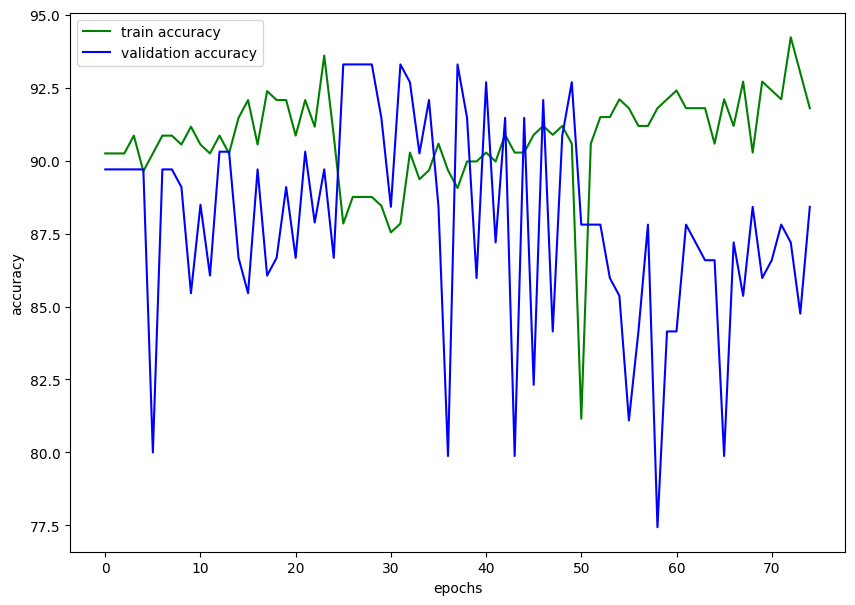

Test_Accuracy : 93.15789473684211
Confusion Matrix on the test set
[[171   7]
 [  6   6]]
eagle
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0146 Acc: 90.2439%
[Test #1] Loss: 0.0162 Acc: 87.2727% 
Epoch 1 running
[Train #2] Loss: 0.0144 Acc: 91.1585%
[Test #2] Loss: 0.0214 Acc: 87.2727% 
Epoch 2 running
[Train #3] Loss: 0.0133 Acc: 90.8537%
[Test #3] Loss: 0.0193 Acc: 87.2727% 
Epoch 3 running
[Train #4] Loss: 0.0111 Acc: 92.6829%
[Test #4] Loss: 0.0183 Acc: 87.2727% 
Epoch 4 running
[Train #5] Loss: 0.0111 Acc: 89.6341%
[Test #5] Loss: 0.0144 Acc: 87.8788% 
Epoch 5 running
[Train #6] Loss: 0.0102 Acc: 92.3780%
[Test #6] Loss: 0.0182 Acc: 84.8485% 
Epoch 6 running
[Train #7] Loss: 0.0107 Acc: 91.7683%
[Test #7] Loss: 0.0169 Acc: 87.8788% 
Epoch 7 running
[Train #8] Loss: 0.0097 Acc: 92.3780%
[Test #8] Loss: 0.0155 Acc: 87.8788% 
Epoch 8 running
[Train #9] Loss: 0.0098 Acc: 91.7683%
[Test #9] Loss: 0.0194 Acc: 88.4848% 
Epoch 9 running
[Train #10] Loss: 0.0104 Acc: 92.3780%
[Test #10] 

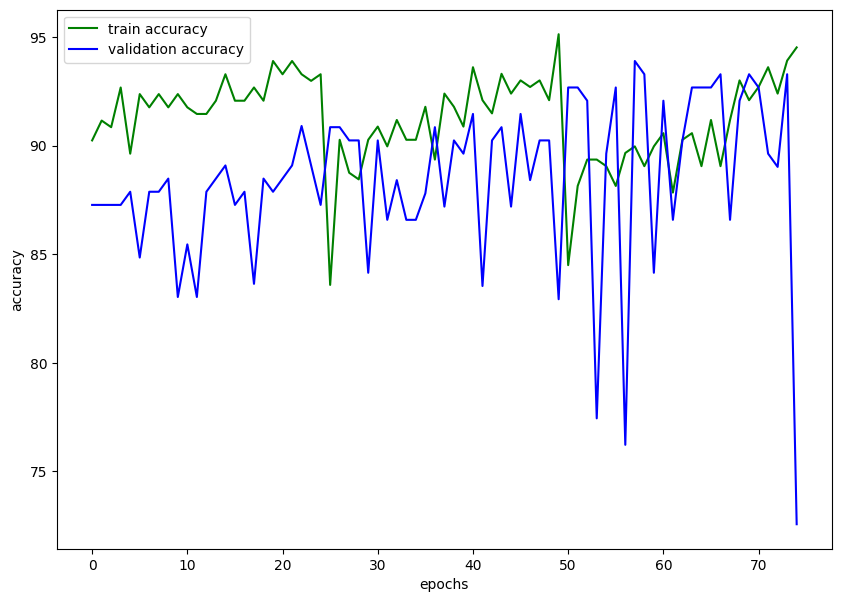

Test_Accuracy : 58.94736842105262
Confusion Matrix on the test set
[[101  77]
 [  1  11]]
elephant
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0178 Acc: 88.4146%
[Test #1] Loss: 0.0124 Acc: 91.5152% 
Epoch 1 running
[Train #2] Loss: 0.0149 Acc: 89.6341%
[Test #2] Loss: 0.0138 Acc: 91.5152% 
Epoch 2 running
[Train #3] Loss: 0.0132 Acc: 89.6341%
[Test #3] Loss: 0.0121 Acc: 91.5152% 
Epoch 3 running
[Train #4] Loss: 0.0144 Acc: 88.4146%
[Test #4] Loss: 0.0126 Acc: 91.5152% 
Epoch 4 running
[Train #5] Loss: 0.0129 Acc: 89.6341%
[Test #5] Loss: 0.0118 Acc: 91.5152% 
Epoch 5 running
[Train #6] Loss: 0.0120 Acc: 89.3293%
[Test #6] Loss: 0.0115 Acc: 90.9091% 
Epoch 6 running
[Train #7] Loss: 0.0120 Acc: 89.6341%
[Test #7] Loss: 0.0132 Acc: 91.5152% 
Epoch 7 running
[Train #8] Loss: 0.0118 Acc: 89.3293%
[Test #8] Loss: 0.0117 Acc: 90.9091% 
Epoch 8 running
[Train #9] Loss: 0.0102 Acc: 90.2439%
[Test #9] Loss: 0.0124 Acc: 90.3030% 
Epoch 9 running
[Train #10] Loss: 0.0124 Acc: 90.5488%
[Test #1

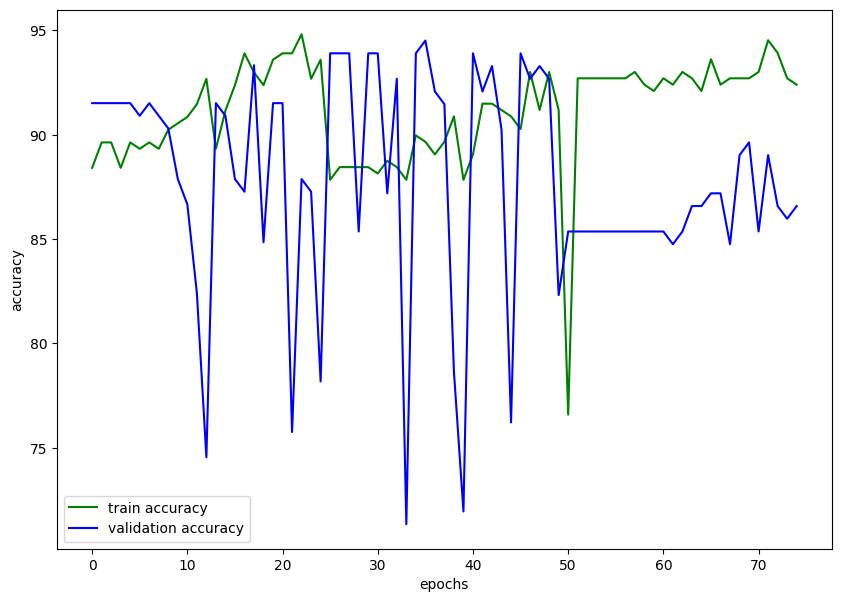

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[178   0]
 [ 12   0]]
flamingo
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0203 Acc: 75.6098%
[Test #1] Loss: 0.0130 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0153 Acc: 89.9390%
[Test #2] Loss: 0.0131 Acc: 90.9091% 
Epoch 2 running
[Train #3] Loss: 0.0125 Acc: 90.5488%
[Test #3] Loss: 0.0125 Acc: 90.3030% 
Epoch 3 running
[Train #4] Loss: 0.0106 Acc: 91.4634%
[Test #4] Loss: 0.0131 Acc: 85.4545% 
Epoch 4 running
[Train #5] Loss: 0.0122 Acc: 90.8537%
[Test #5] Loss: 0.0122 Acc: 89.6970% 
Epoch 5 running
[Train #6] Loss: 0.0110 Acc: 90.8537%
[Test #6] Loss: 0.0117 Acc: 88.4848% 
Epoch 6 running
[Train #7] Loss: 0.0112 Acc: 89.0244%
[Test #7] Loss: 0.0235 Acc: 81.2121% 
Epoch 7 running
[Train #8] Loss: 0.0100 Acc: 93.9024%
[Test #8] Loss: 0.0127 Acc: 91.5152% 
Epoch 8 running
[Train #9] Loss: 0.0083 Acc: 93.2927%
[Test #9] Loss: 0.0116 Acc: 92.7273% 
Epoch 9 running
[Train #10] Loss: 0.0080 Acc: 92.9878%
[Test #10

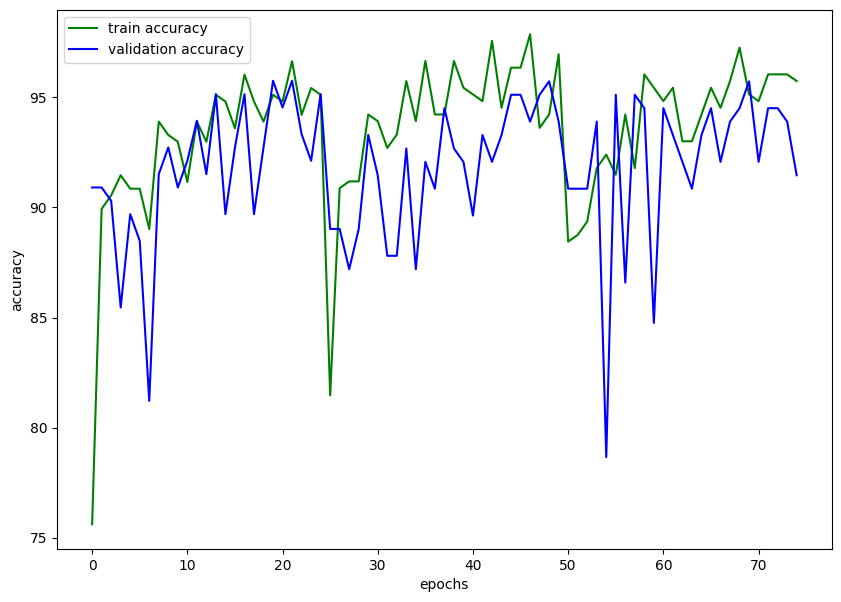

Test_Accuracy : 80.52631578947368
Confusion Matrix on the test set
[[142  36]
 [  1  11]]
fly
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0143 Acc: 87.5000%
[Test #1] Loss: 0.0168 Acc: 86.6667% 
Epoch 1 running
[Train #2] Loss: 0.0133 Acc: 92.3780%
[Test #2] Loss: 0.0263 Acc: 86.6667% 
Epoch 2 running
[Train #3] Loss: 0.0119 Acc: 92.0732%
[Test #3] Loss: 0.0242 Acc: 86.6667% 
Epoch 3 running
[Train #4] Loss: 0.0108 Acc: 91.4634%
[Test #4] Loss: 0.0160 Acc: 87.2727% 
Epoch 4 running
[Train #5] Loss: 0.0103 Acc: 91.4634%
[Test #5] Loss: 0.0236 Acc: 74.5455% 
Epoch 5 running
[Train #6] Loss: 0.0101 Acc: 92.9878%
[Test #6] Loss: 0.0191 Acc: 84.8485% 
Epoch 6 running
[Train #7] Loss: 0.0094 Acc: 92.0732%
[Test #7] Loss: 0.0206 Acc: 86.0606% 
Epoch 7 running
[Train #8] Loss: 0.0105 Acc: 92.3780%
[Test #8] Loss: 0.0203 Acc: 86.0606% 
Epoch 8 running
[Train #9] Loss: 0.0091 Acc: 92.3780%
[Test #9] Loss: 0.0173 Acc: 87.2727% 
Epoch 9 running
[Train #10] Loss: 0.0083 Acc: 93.9024%
[Test #10] Lo

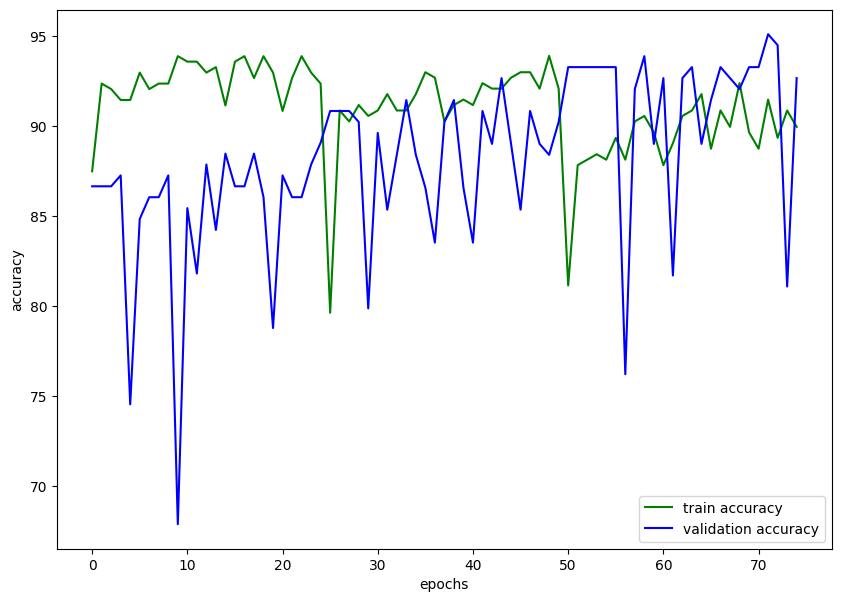

Test_Accuracy : 87.36842105263159
Confusion Matrix on the test set
[[159  19]
 [  5   7]]
fox
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0159 Acc: 86.5854%
[Test #1] Loss: 0.0172 Acc: 90.3030% 
Epoch 1 running
[Train #2] Loss: 0.0128 Acc: 90.2439%
[Test #2] Loss: 0.0211 Acc: 90.3030% 
Epoch 2 running
[Train #3] Loss: 0.0126 Acc: 90.2439%
[Test #3] Loss: 0.0133 Acc: 90.3030% 
Epoch 3 running
[Train #4] Loss: 0.0133 Acc: 89.9390%
[Test #4] Loss: 0.0133 Acc: 90.3030% 
Epoch 4 running
[Train #5] Loss: 0.0130 Acc: 90.5488%
[Test #5] Loss: 0.0129 Acc: 90.3030% 
Epoch 5 running
[Train #6] Loss: 0.0128 Acc: 90.5488%
[Test #6] Loss: 0.0161 Acc: 88.4848% 
Epoch 6 running
[Train #7] Loss: 0.0126 Acc: 89.9390%
[Test #7] Loss: 0.0135 Acc: 90.3030% 
Epoch 7 running
[Train #8] Loss: 0.0131 Acc: 89.0244%
[Test #8] Loss: 0.0131 Acc: 90.3030% 
Epoch 8 running
[Train #9] Loss: 0.0118 Acc: 89.9390%
[Test #9] Loss: 0.0195 Acc: 89.6970% 
Epoch 9 running
[Train #10] Loss: 0.0125 Acc: 89.3293%
[Test #10] Lo

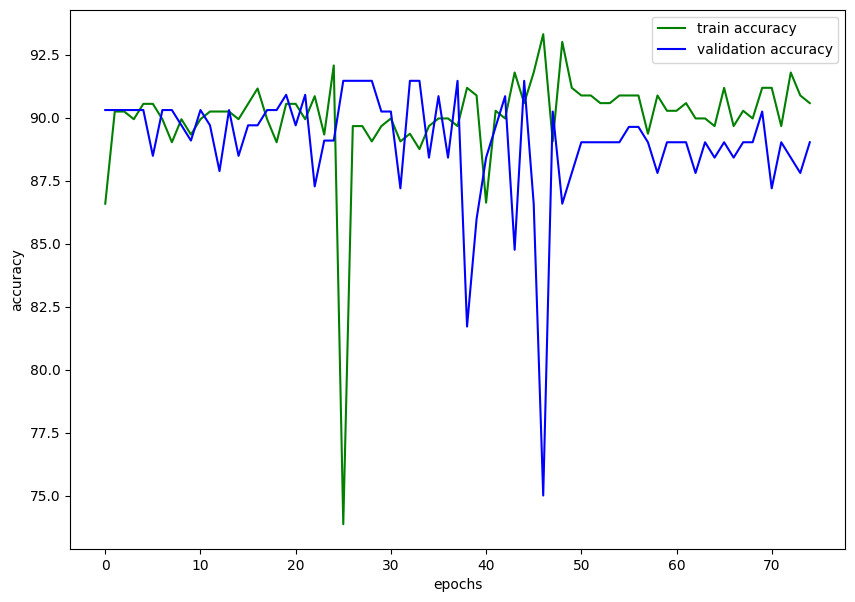

Test_Accuracy : 93.15789473684211
Confusion Matrix on the test set
[[177   1]
 [ 12   0]]
goat
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0156 Acc: 90.5488%
[Test #1] Loss: 0.0145 Acc: 89.0909% 
Epoch 1 running
[Train #2] Loss: 0.0121 Acc: 90.8537%
[Test #2] Loss: 0.0172 Acc: 89.0909% 
Epoch 2 running
[Train #3] Loss: 0.0129 Acc: 90.2439%
[Test #3] Loss: 0.0156 Acc: 89.0909% 
Epoch 3 running
[Train #4] Loss: 0.0117 Acc: 91.4634%
[Test #4] Loss: 0.0182 Acc: 89.0909% 
Epoch 4 running
[Train #5] Loss: 0.0127 Acc: 90.8537%
[Test #5] Loss: 0.0158 Acc: 86.6667% 
Epoch 5 running
[Train #6] Loss: 0.0109 Acc: 90.8537%
[Test #6] Loss: 0.0170 Acc: 85.4545% 
Epoch 6 running
[Train #7] Loss: 0.0106 Acc: 91.1585%
[Test #7] Loss: 0.0163 Acc: 89.0909% 
Epoch 7 running
[Train #8] Loss: 0.0108 Acc: 90.8537%
[Test #8] Loss: 0.0181 Acc: 89.0909% 
Epoch 8 running
[Train #9] Loss: 0.0098 Acc: 90.5488%
[Test #9] Loss: 0.0205 Acc: 86.0606% 
Epoch 9 running
[Train #10] Loss: 0.0110 Acc: 89.3293%
[Test #10] L

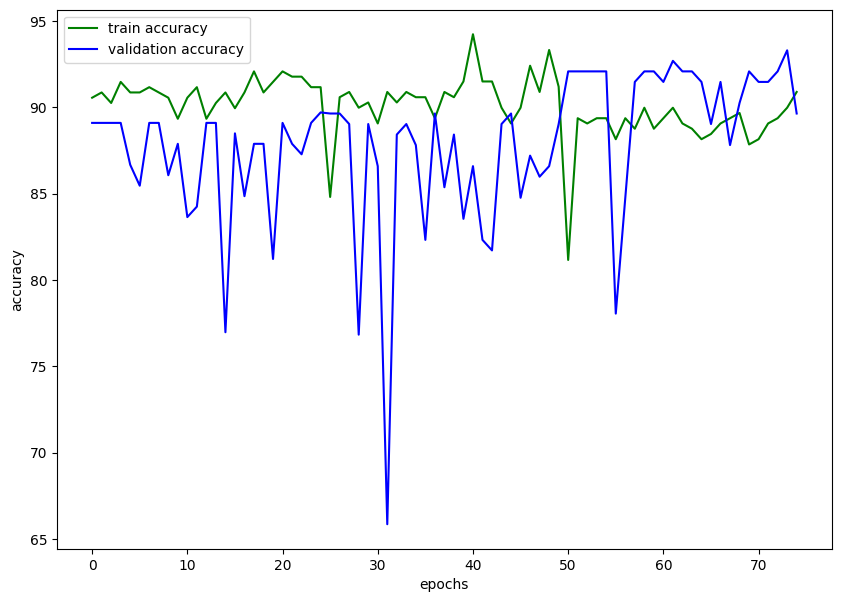

Test_Accuracy : 82.10526315789474
Confusion Matrix on the test set
[[155  23]
 [ 11   1]]
goldfish
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0115 Acc: 91.4634%
[Test #1] Loss: 0.0162 Acc: 87.8788% 
Epoch 1 running
[Train #2] Loss: 0.0078 Acc: 93.5976%
[Test #2] Loss: 0.0274 Acc: 87.8788% 
Epoch 2 running
[Train #3] Loss: 0.0090 Acc: 93.2927%
[Test #3] Loss: 0.0222 Acc: 87.8788% 
Epoch 3 running
[Train #4] Loss: 0.0064 Acc: 95.1220%
[Test #4] Loss: 0.0126 Acc: 90.9091% 
Epoch 4 running
[Train #5] Loss: 0.0072 Acc: 93.2927%
[Test #5] Loss: 0.0122 Acc: 90.9091% 
Epoch 5 running
[Train #6] Loss: 0.0060 Acc: 95.4268%
[Test #6] Loss: 0.0662 Acc: 66.6667% 
Epoch 6 running
[Train #7] Loss: 0.0067 Acc: 93.9024%
[Test #7] Loss: 0.0103 Acc: 93.3333% 
Epoch 7 running
[Train #8] Loss: 0.0058 Acc: 96.0366%
[Test #8] Loss: 0.0109 Acc: 88.4848% 
Epoch 8 running
[Train #9] Loss: 0.0053 Acc: 93.5976%
[Test #9] Loss: 0.0111 Acc: 89.6970% 
Epoch 9 running
[Train #10] Loss: 0.0051 Acc: 95.4268%
[Test #1

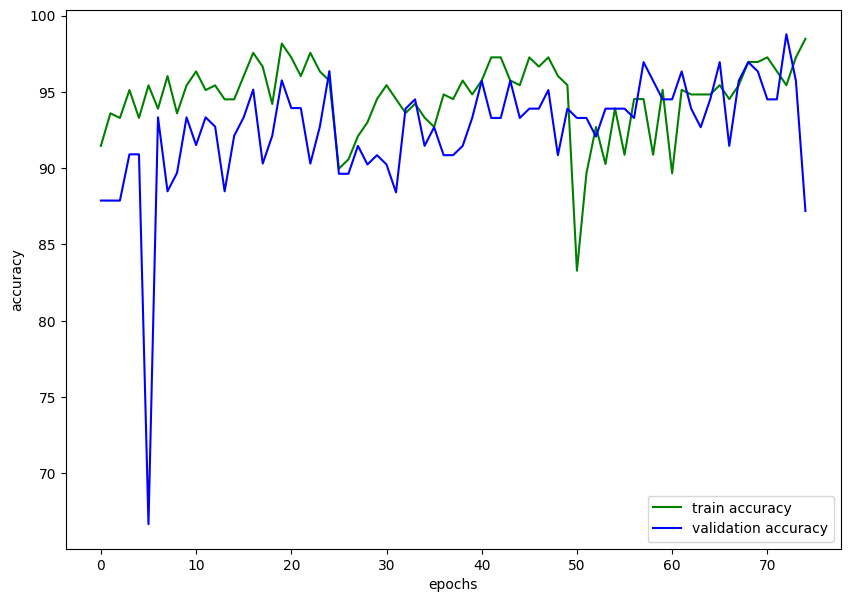

Test_Accuracy : 78.42105263157895
Confusion Matrix on the test set
[[139  39]
 [  2  10]]
goose
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0249 Acc: 69.8171%
[Test #1] Loss: 0.0119 Acc: 95.1515% 
Epoch 1 running
[Train #2] Loss: 0.0174 Acc: 87.8049%
[Test #2] Loss: 0.0086 Acc: 95.1515% 
Epoch 2 running
[Train #3] Loss: 0.0160 Acc: 87.8049%
[Test #3] Loss: 0.0097 Acc: 95.1515% 
Epoch 3 running
[Train #4] Loss: 0.0160 Acc: 87.8049%
[Test #4] Loss: 0.0093 Acc: 95.1515% 
Epoch 4 running
[Train #5] Loss: 0.0144 Acc: 87.8049%
[Test #5] Loss: 0.0086 Acc: 95.1515% 
Epoch 5 running
[Train #6] Loss: 0.0139 Acc: 89.9390%
[Test #6] Loss: 0.0140 Acc: 89.0909% 
Epoch 6 running
[Train #7] Loss: 0.0145 Acc: 86.5854%
[Test #7] Loss: 0.0085 Acc: 95.1515% 
Epoch 7 running
[Train #8] Loss: 0.0141 Acc: 87.5000%
[Test #8] Loss: 0.0106 Acc: 95.1515% 
Epoch 8 running
[Train #9] Loss: 0.0134 Acc: 89.0244%
[Test #9] Loss: 0.0101 Acc: 93.9394% 
Epoch 9 running
[Train #10] Loss: 0.0127 Acc: 87.1951%
[Test #10] 

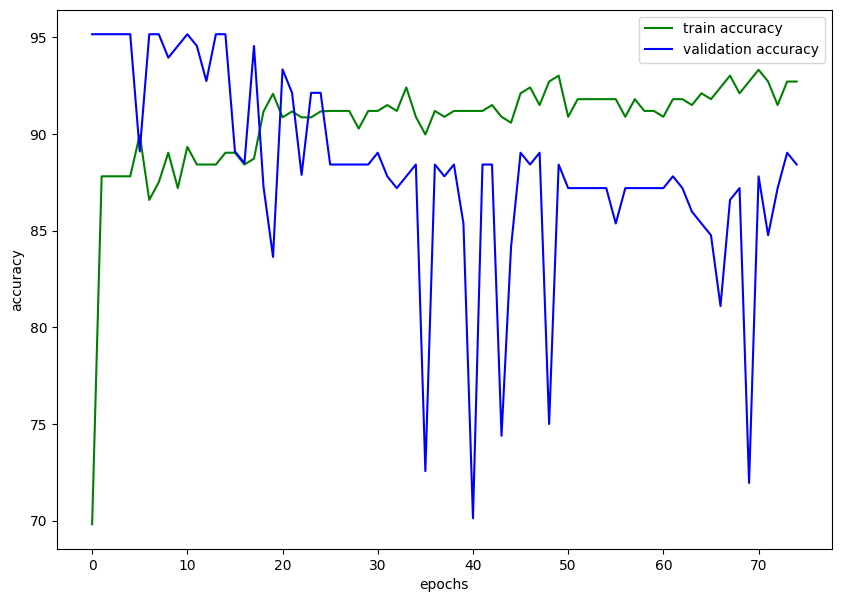

Test_Accuracy : 94.21052631578948
Confusion Matrix on the test set
[[176   2]
 [  9   3]]
gorilla
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0354 Acc: 57.6220%
[Test #1] Loss: 0.0182 Acc: 90.3030% 
Epoch 1 running
[Train #2] Loss: 0.0159 Acc: 90.2439%
[Test #2] Loss: 0.0132 Acc: 90.3030% 
Epoch 2 running
[Train #3] Loss: 0.0128 Acc: 89.9390%
[Test #3] Loss: 0.0128 Acc: 89.6970% 
Epoch 3 running
[Train #4] Loss: 0.0104 Acc: 91.4634%
[Test #4] Loss: 0.0121 Acc: 89.0909% 
Epoch 4 running
[Train #5] Loss: 0.0112 Acc: 89.3293%
[Test #5] Loss: 0.0139 Acc: 91.5152% 
Epoch 5 running
[Train #6] Loss: 0.0097 Acc: 90.5488%
[Test #6] Loss: 0.0097 Acc: 90.3030% 
Epoch 6 running
[Train #7] Loss: 0.0096 Acc: 90.8537%
[Test #7] Loss: 0.0084 Acc: 93.3333% 
Epoch 7 running
[Train #8] Loss: 0.0074 Acc: 94.2073%
[Test #8] Loss: 0.0098 Acc: 90.3030% 
Epoch 8 running
[Train #9] Loss: 0.0072 Acc: 92.9878%
[Test #9] Loss: 0.0078 Acc: 92.7273% 
Epoch 9 running
[Train #10] Loss: 0.0086 Acc: 92.3780%
[Test #10

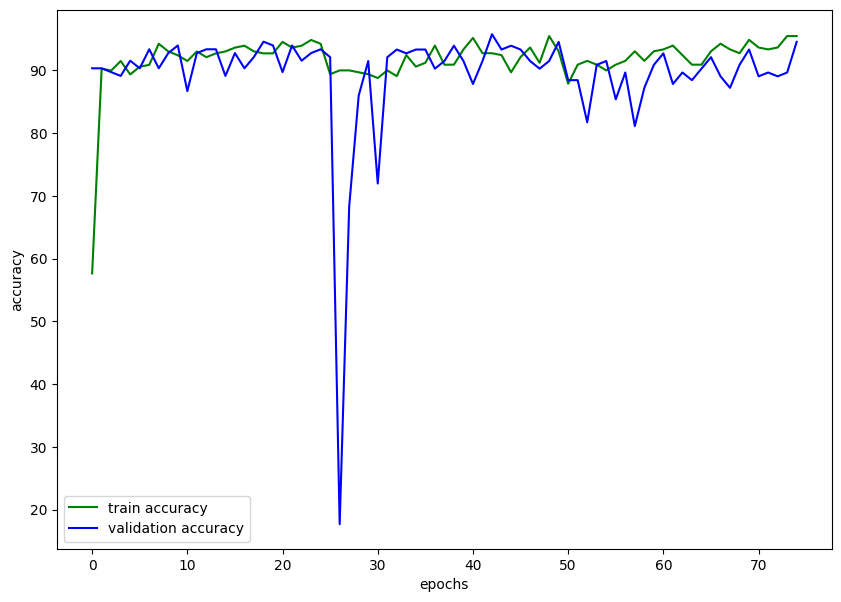

Test_Accuracy : 94.21052631578948
Confusion Matrix on the test set
[[174   4]
 [  7   5]]
grasshopper
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0184 Acc: 84.1463%
[Test #1] Loss: 0.0130 Acc: 93.3333% 
Epoch 1 running
[Train #2] Loss: 0.0159 Acc: 88.7195%
[Test #2] Loss: 0.0118 Acc: 93.3333% 
Epoch 2 running
[Train #3] Loss: 0.0144 Acc: 88.7195%
[Test #3] Loss: 0.0116 Acc: 93.3333% 
Epoch 3 running
[Train #4] Loss: 0.0139 Acc: 88.7195%
[Test #4] Loss: 0.0087 Acc: 93.9394% 
Epoch 4 running
[Train #5] Loss: 0.0141 Acc: 88.7195%
[Test #5] Loss: 0.0096 Acc: 92.1212% 
Epoch 5 running
[Train #6] Loss: 0.0129 Acc: 89.3293%
[Test #6] Loss: 0.0116 Acc: 93.9394% 
Epoch 6 running
[Train #7] Loss: 0.0138 Acc: 87.8049%
[Test #7] Loss: 0.0095 Acc: 93.9394% 
Epoch 7 running
[Train #8] Loss: 0.0131 Acc: 88.4146%
[Test #8] Loss: 0.0099 Acc: 93.9394% 
Epoch 8 running
[Train #9] Loss: 0.0131 Acc: 87.8049%
[Test #9] Loss: 0.0068 Acc: 95.7576% 
Epoch 9 running
[Train #10] Loss: 0.0118 Acc: 89.6341%
[Test

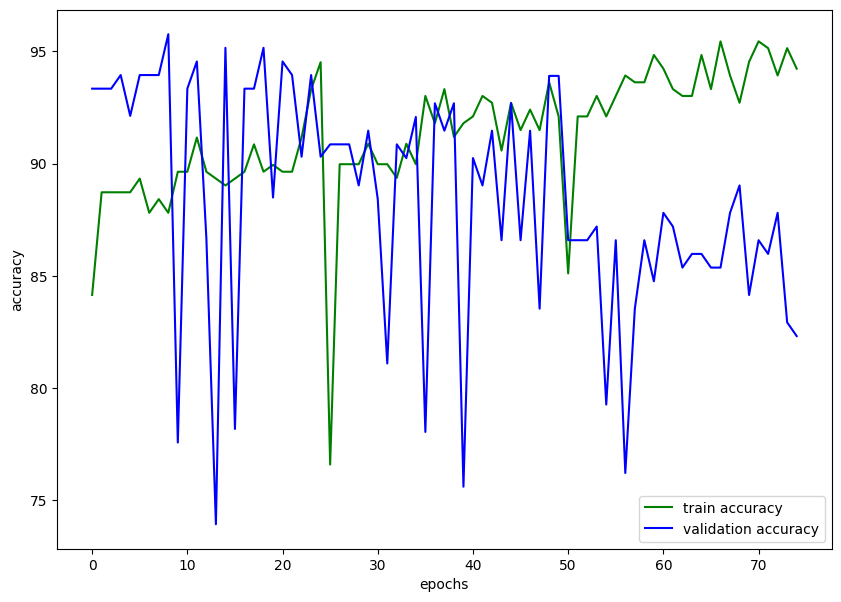

Test_Accuracy : 85.78947368421052
Confusion Matrix on the test set
[[157  21]
 [  6   6]]
hamster
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0183 Acc: 85.6707%
[Test #1] Loss: 0.0172 Acc: 87.2727% 
Epoch 1 running
[Train #2] Loss: 0.0126 Acc: 91.7683%
[Test #2] Loss: 0.0164 Acc: 87.2727% 
Epoch 2 running
[Train #3] Loss: 0.0118 Acc: 91.7683%
[Test #3] Loss: 0.0133 Acc: 87.2727% 
Epoch 3 running
[Train #4] Loss: 0.0101 Acc: 91.7683%
[Test #4] Loss: 0.0131 Acc: 87.2727% 
Epoch 4 running
[Train #5] Loss: 0.0110 Acc: 91.7683%
[Test #5] Loss: 0.0131 Acc: 88.4848% 
Epoch 5 running
[Train #6] Loss: 0.0097 Acc: 92.3780%
[Test #6] Loss: 0.0137 Acc: 86.0606% 
Epoch 6 running
[Train #7] Loss: 0.0101 Acc: 90.8537%
[Test #7] Loss: 0.0157 Acc: 90.3030% 
Epoch 7 running
[Train #8] Loss: 0.0105 Acc: 91.7683%
[Test #8] Loss: 0.0208 Acc: 87.2727% 
Epoch 8 running
[Train #9] Loss: 0.0101 Acc: 91.1585%
[Test #9] Loss: 0.0183 Acc: 87.2727% 
Epoch 9 running
[Train #10] Loss: 0.0088 Acc: 92.3780%
[Test #10

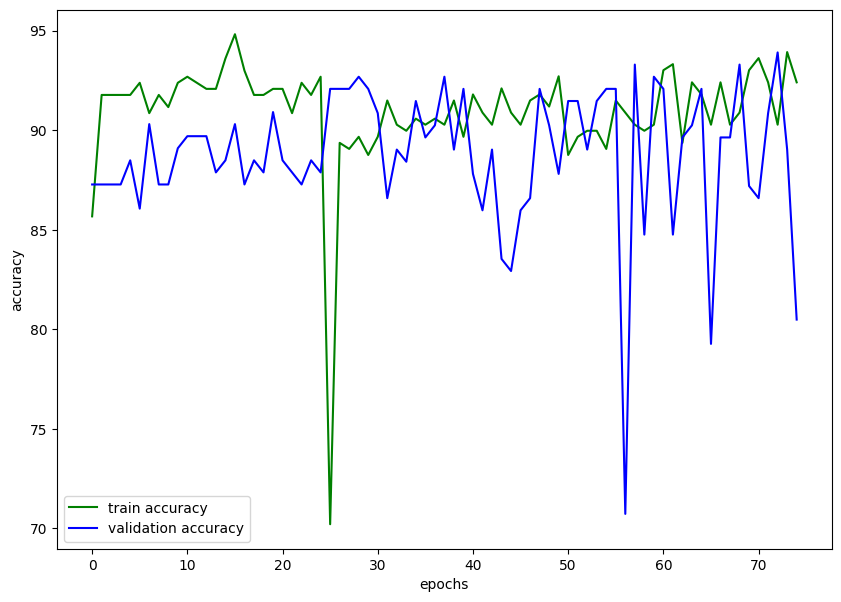

Test_Accuracy : 73.15789473684211
Confusion Matrix on the test set
[[132  46]
 [  5   7]]
hare
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0212 Acc: 76.8293%
[Test #1] Loss: 0.0162 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0134 Acc: 90.2439%
[Test #2] Loss: 0.0128 Acc: 90.9091% 
Epoch 2 running
[Train #3] Loss: 0.0147 Acc: 89.9390%
[Test #3] Loss: 0.0124 Acc: 90.9091% 
Epoch 3 running
[Train #4] Loss: 0.0120 Acc: 91.1585%
[Test #4] Loss: 0.0150 Acc: 87.2727% 
Epoch 4 running
[Train #5] Loss: 0.0122 Acc: 89.9390%
[Test #5] Loss: 0.0115 Acc: 89.0909% 
Epoch 5 running
[Train #6] Loss: 0.0129 Acc: 89.3293%
[Test #6] Loss: 0.0120 Acc: 90.9091% 
Epoch 6 running
[Train #7] Loss: 0.0116 Acc: 89.9390%
[Test #7] Loss: 0.0131 Acc: 90.9091% 
Epoch 7 running
[Train #8] Loss: 0.0117 Acc: 90.5488%
[Test #8] Loss: 0.0128 Acc: 87.2727% 
Epoch 8 running
[Train #9] Loss: 0.0108 Acc: 89.9390%
[Test #9] Loss: 0.0118 Acc: 89.6970% 
Epoch 9 running
[Train #10] Loss: 0.0109 Acc: 91.4634%
[Test #10] L

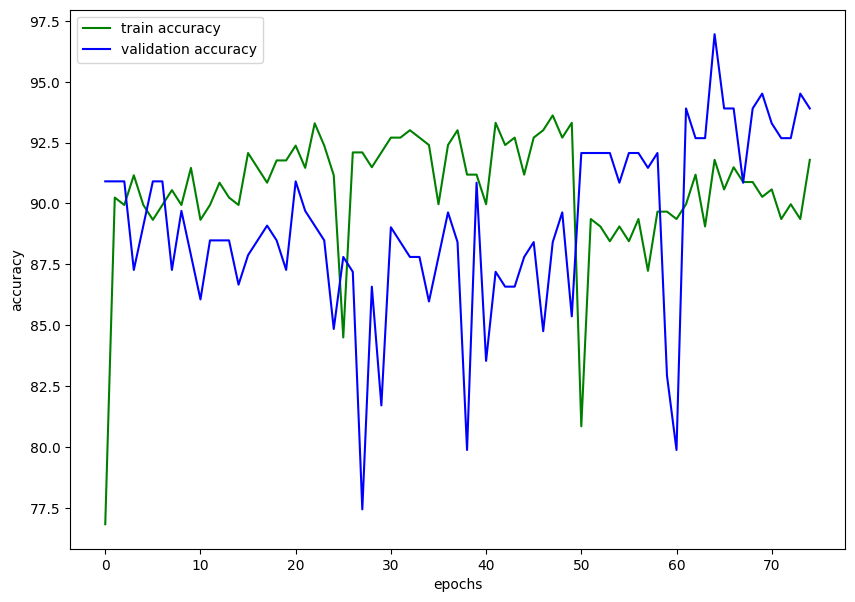

Test_Accuracy : 93.15789473684211
Confusion Matrix on the test set
[[174   4]
 [  9   3]]
hedgehog
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0193 Acc: 80.4878%
[Test #1] Loss: 0.0157 Acc: 87.8788% 
Epoch 1 running
[Train #2] Loss: 0.0139 Acc: 91.4634%
[Test #2] Loss: 0.0204 Acc: 87.8788% 
Epoch 2 running
[Train #3] Loss: 0.0133 Acc: 91.4634%
[Test #3] Loss: 0.0185 Acc: 87.8788% 
Epoch 3 running
[Train #4] Loss: 0.0126 Acc: 91.4634%
[Test #4] Loss: 0.0152 Acc: 87.8788% 
Epoch 4 running
[Train #5] Loss: 0.0112 Acc: 91.4634%
[Test #5] Loss: 0.0163 Acc: 87.8788% 
Epoch 5 running
[Train #6] Loss: 0.0106 Acc: 91.4634%
[Test #6] Loss: 0.0166 Acc: 85.4545% 
Epoch 6 running
[Train #7] Loss: 0.0119 Acc: 91.1585%
[Test #7] Loss: 0.0168 Acc: 87.2727% 
Epoch 7 running
[Train #8] Loss: 0.0119 Acc: 91.7683%
[Test #8] Loss: 0.0172 Acc: 87.8788% 
Epoch 8 running
[Train #9] Loss: 0.0107 Acc: 92.0732%
[Test #9] Loss: 0.0132 Acc: 87.8788% 
Epoch 9 running
[Train #10] Loss: 0.0112 Acc: 91.7683%
[Test #1

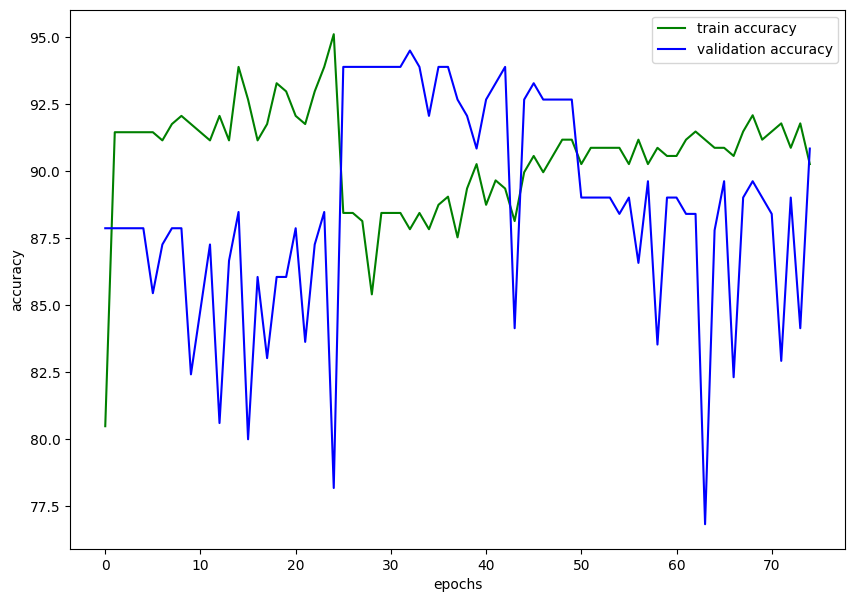

Test_Accuracy : 92.10526315789474
Confusion Matrix on the test set
[[172   6]
 [  9   3]]
hippopotamus
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0174 Acc: 84.4512%
[Test #1] Loss: 0.0194 Acc: 91.5152% 
Epoch 1 running
[Train #2] Loss: 0.0162 Acc: 89.3293%
[Test #2] Loss: 0.0123 Acc: 91.5152% 
Epoch 2 running
[Train #3] Loss: 0.0145 Acc: 89.6341%
[Test #3] Loss: 0.0138 Acc: 91.5152% 
Epoch 3 running
[Train #4] Loss: 0.0136 Acc: 89.3293%
[Test #4] Loss: 0.0154 Acc: 91.5152% 
Epoch 4 running
[Train #5] Loss: 0.0131 Acc: 89.0244%
[Test #5] Loss: 0.0133 Acc: 91.5152% 
Epoch 5 running
[Train #6] Loss: 0.0121 Acc: 89.9390%
[Test #6] Loss: 0.0172 Acc: 81.8182% 
Epoch 6 running
[Train #7] Loss: 0.0120 Acc: 89.6341%
[Test #7] Loss: 0.0139 Acc: 91.5152% 
Epoch 7 running
[Train #8] Loss: 0.0126 Acc: 89.6341%
[Test #8] Loss: 0.0250 Acc: 68.4848% 
Epoch 8 running
[Train #9] Loss: 0.0121 Acc: 89.3293%
[Test #9] Loss: 0.0200 Acc: 84.8485% 
Epoch 9 running
[Train #10] Loss: 0.0104 Acc: 91.7683%
[Tes

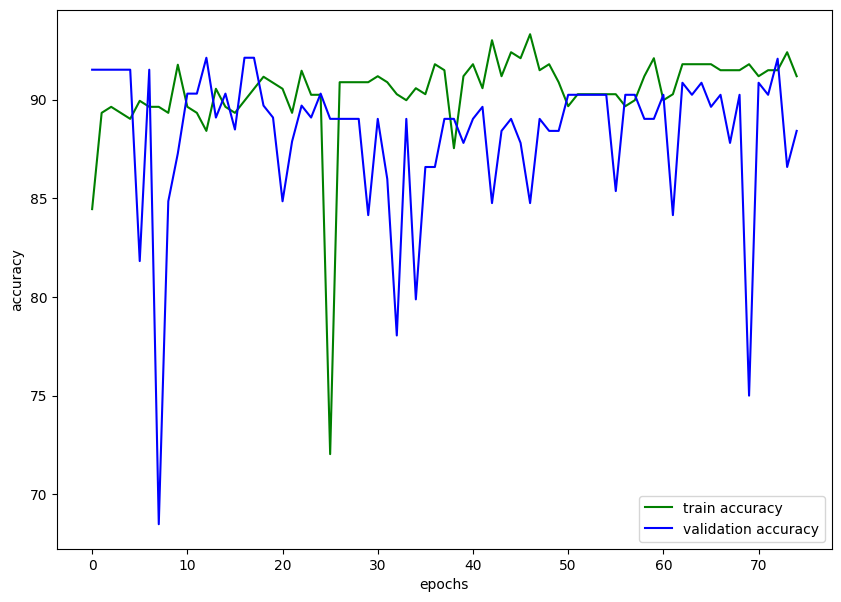

Test_Accuracy : 92.10526315789474
Confusion Matrix on the test set
[[175   3]
 [ 12   0]]
hornbill
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0184 Acc: 81.7073%
[Test #1] Loss: 0.0142 Acc: 89.6970% 
Epoch 1 running
[Train #2] Loss: 0.0146 Acc: 89.9390%
[Test #2] Loss: 0.0232 Acc: 89.6970% 
Epoch 2 running
[Train #3] Loss: 0.0136 Acc: 90.2439%
[Test #3] Loss: 0.0202 Acc: 89.6970% 
Epoch 3 running
[Train #4] Loss: 0.0120 Acc: 89.6341%
[Test #4] Loss: 0.0133 Acc: 89.6970% 
Epoch 4 running
[Train #5] Loss: 0.0117 Acc: 91.4634%
[Test #5] Loss: 0.0425 Acc: 72.7273% 
Epoch 5 running
[Train #6] Loss: 0.0132 Acc: 89.9390%
[Test #6] Loss: 0.0132 Acc: 88.4848% 
Epoch 6 running
[Train #7] Loss: 0.0119 Acc: 89.3293%
[Test #7] Loss: 0.0166 Acc: 89.6970% 
Epoch 7 running
[Train #8] Loss: 0.0113 Acc: 89.9390%
[Test #8] Loss: 0.0130 Acc: 89.6970% 
Epoch 8 running
[Train #9] Loss: 0.0088 Acc: 92.6829%
[Test #9] Loss: 0.0114 Acc: 88.4848% 
Epoch 9 running
[Train #10] Loss: 0.0107 Acc: 90.8537%
[Test #1

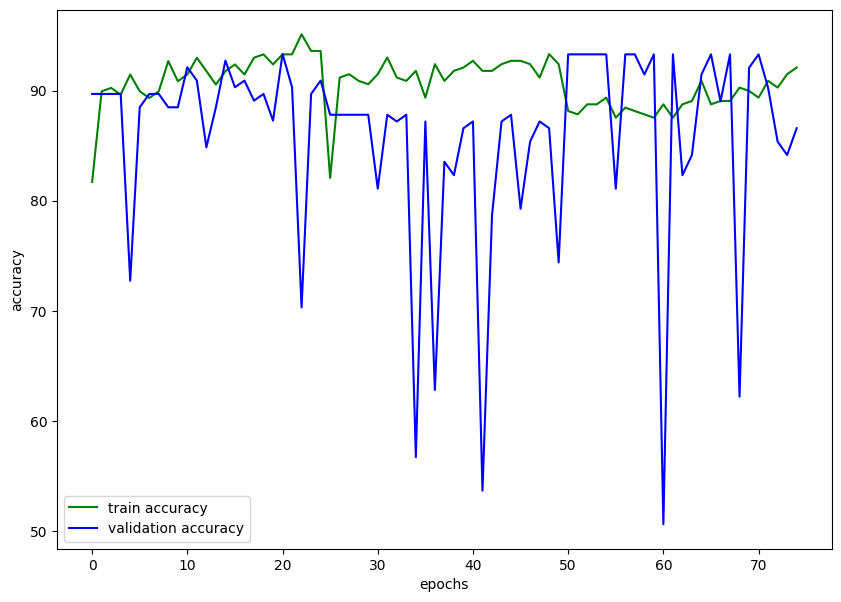

Test_Accuracy : 81.05263157894737
Confusion Matrix on the test set
[[148  30]
 [  6   6]]
horse
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0181 Acc: 84.1463%
[Test #1] Loss: 0.0142 Acc: 92.7273% 
Epoch 1 running
[Train #2] Loss: 0.0162 Acc: 89.0244%
[Test #2] Loss: 0.0114 Acc: 92.7273% 
Epoch 2 running
[Train #3] Loss: 0.0150 Acc: 89.0244%
[Test #3] Loss: 0.0128 Acc: 92.7273% 
Epoch 3 running
[Train #4] Loss: 0.0142 Acc: 89.0244%
[Test #4] Loss: 0.0142 Acc: 89.6970% 
Epoch 4 running
[Train #5] Loss: 0.0145 Acc: 87.8049%
[Test #5] Loss: 0.0103 Acc: 92.7273% 
Epoch 5 running
[Train #6] Loss: 0.0141 Acc: 89.0244%
[Test #6] Loss: 0.0162 Acc: 84.2424% 
Epoch 6 running
[Train #7] Loss: 0.0140 Acc: 88.7195%
[Test #7] Loss: 0.0130 Acc: 90.3030% 
Epoch 7 running
[Train #8] Loss: 0.0138 Acc: 88.4146%
[Test #8] Loss: 0.0139 Acc: 88.4848% 
Epoch 8 running
[Train #9] Loss: 0.0137 Acc: 89.6341%
[Test #9] Loss: 0.0102 Acc: 92.7273% 
Epoch 9 running
[Train #10] Loss: 0.0129 Acc: 88.4146%
[Test #10] 

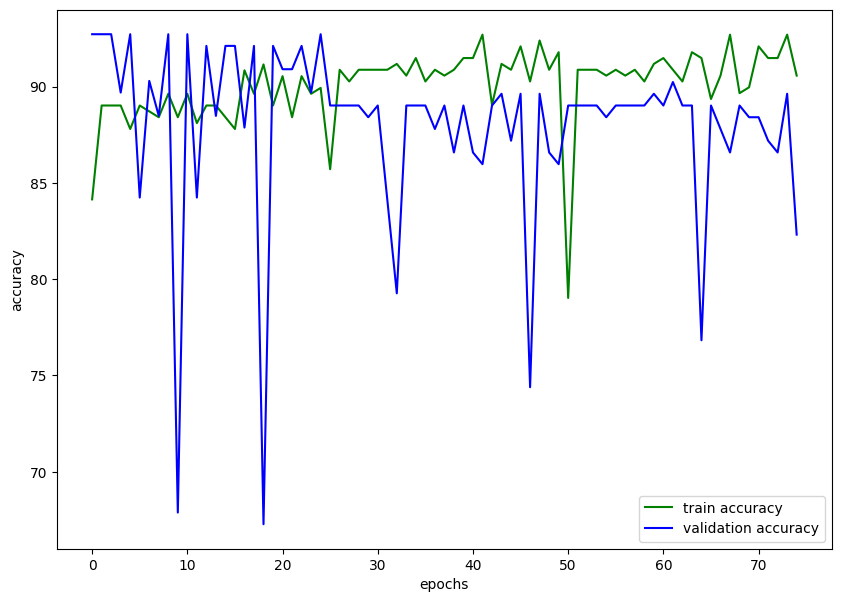

Test_Accuracy : 74.21052631578947
Confusion Matrix on the test set
[[135  43]
 [  6   6]]
hummingbird
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0201 Acc: 76.5244%
[Test #1] Loss: 0.0160 Acc: 89.0909% 
Epoch 1 running
[Train #2] Loss: 0.0141 Acc: 90.8537%
[Test #2] Loss: 0.0185 Acc: 89.0909% 
Epoch 2 running
[Train #3] Loss: 0.0127 Acc: 90.2439%
[Test #3] Loss: 0.0134 Acc: 90.3030% 
Epoch 3 running
[Train #4] Loss: 0.0116 Acc: 90.5488%
[Test #4] Loss: 0.0130 Acc: 89.0909% 
Epoch 4 running
[Train #5] Loss: 0.0100 Acc: 91.4634%
[Test #5] Loss: 0.0119 Acc: 89.0909% 
Epoch 5 running
[Train #6] Loss: 0.0105 Acc: 91.4634%
[Test #6] Loss: 0.0108 Acc: 90.3030% 
Epoch 6 running
[Train #7] Loss: 0.0090 Acc: 90.8537%
[Test #7] Loss: 0.0145 Acc: 89.0909% 
Epoch 7 running
[Train #8] Loss: 0.0107 Acc: 90.5488%
[Test #8] Loss: 0.0122 Acc: 89.6970% 
Epoch 8 running
[Train #9] Loss: 0.0121 Acc: 91.7683%
[Test #9] Loss: 0.0092 Acc: 90.9091% 
Epoch 9 running
[Train #10] Loss: 0.0089 Acc: 91.7683%
[Test

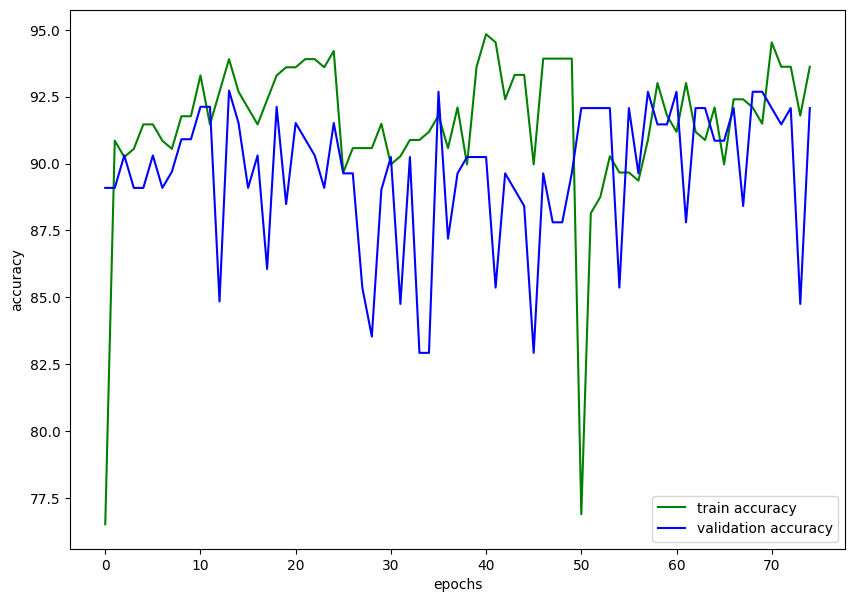

Test_Accuracy : 95.78947368421052
Confusion Matrix on the test set
[[176   2]
 [  6   6]]
hyena
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0201 Acc: 75.3049%
[Test #1] Loss: 0.0197 Acc: 92.1212% 
Epoch 1 running
[Train #2] Loss: 0.0147 Acc: 89.3293%
[Test #2] Loss: 0.0294 Acc: 46.6667% 
Epoch 2 running
[Train #3] Loss: 0.0145 Acc: 89.3293%
[Test #3] Loss: 0.0150 Acc: 92.1212% 
Epoch 3 running
[Train #4] Loss: 0.0132 Acc: 89.3293%
[Test #4] Loss: 0.0157 Acc: 90.3030% 
Epoch 4 running
[Train #5] Loss: 0.0133 Acc: 89.3293%
[Test #5] Loss: 0.0085 Acc: 92.1212% 
Epoch 5 running
[Train #6] Loss: 0.0125 Acc: 89.0244%
[Test #6] Loss: 0.0133 Acc: 90.9091% 
Epoch 6 running
[Train #7] Loss: 0.0127 Acc: 88.7195%
[Test #7] Loss: 0.0107 Acc: 92.1212% 
Epoch 7 running
[Train #8] Loss: 0.0117 Acc: 89.3293%
[Test #8] Loss: 0.0099 Acc: 91.5152% 
Epoch 8 running
[Train #9] Loss: 0.0121 Acc: 89.0244%
[Test #9] Loss: 0.0133 Acc: 87.2727% 
Epoch 9 running
[Train #10] Loss: 0.0105 Acc: 90.8537%
[Test #10] 

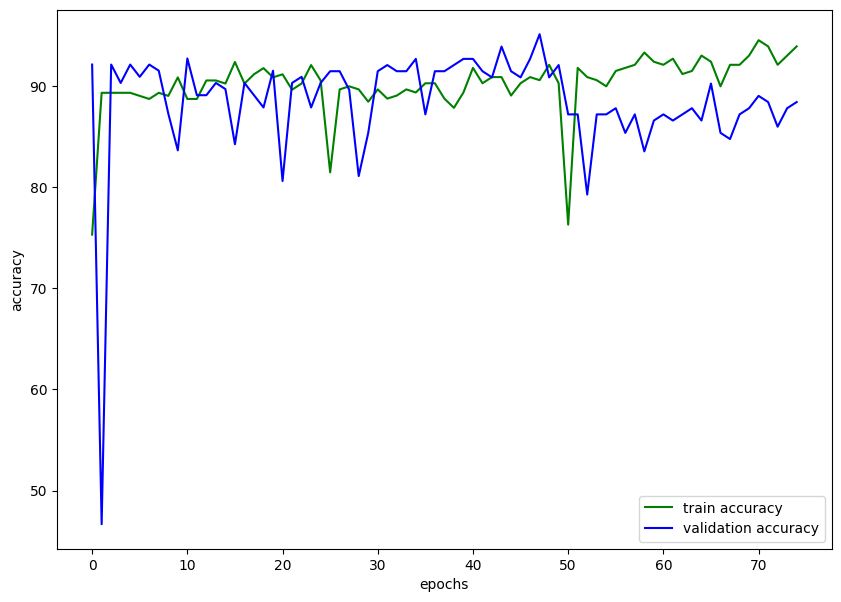

Test_Accuracy : 89.47368421052632
Confusion Matrix on the test set
[[170   8]
 [ 12   0]]
jellyfish
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0165 Acc: 80.1829%
[Test #1] Loss: 0.0153 Acc: 89.0909% 
Epoch 1 running
[Train #2] Loss: 0.0109 Acc: 91.1585%
[Test #2] Loss: 0.0222 Acc: 89.0909% 
Epoch 2 running
[Train #3] Loss: 0.0101 Acc: 91.4634%
[Test #3] Loss: 0.0119 Acc: 89.6970% 
Epoch 3 running
[Train #4] Loss: 0.0073 Acc: 93.5976%
[Test #4] Loss: 0.0079 Acc: 92.1212% 
Epoch 4 running
[Train #5] Loss: 0.0073 Acc: 93.2927%
[Test #5] Loss: 0.0092 Acc: 92.1212% 
Epoch 5 running
[Train #6] Loss: 0.0060 Acc: 96.0366%
[Test #6] Loss: 0.0084 Acc: 91.5152% 
Epoch 6 running
[Train #7] Loss: 0.0071 Acc: 95.1220%
[Test #7] Loss: 0.0065 Acc: 93.3333% 
Epoch 7 running
[Train #8] Loss: 0.0050 Acc: 95.1220%
[Test #8] Loss: 0.0264 Acc: 84.8485% 
Epoch 8 running
[Train #9] Loss: 0.0050 Acc: 96.0366%
[Test #9] Loss: 0.0080 Acc: 92.7273% 
Epoch 9 running
[Train #10] Loss: 0.0063 Acc: 94.8171%
[Test #

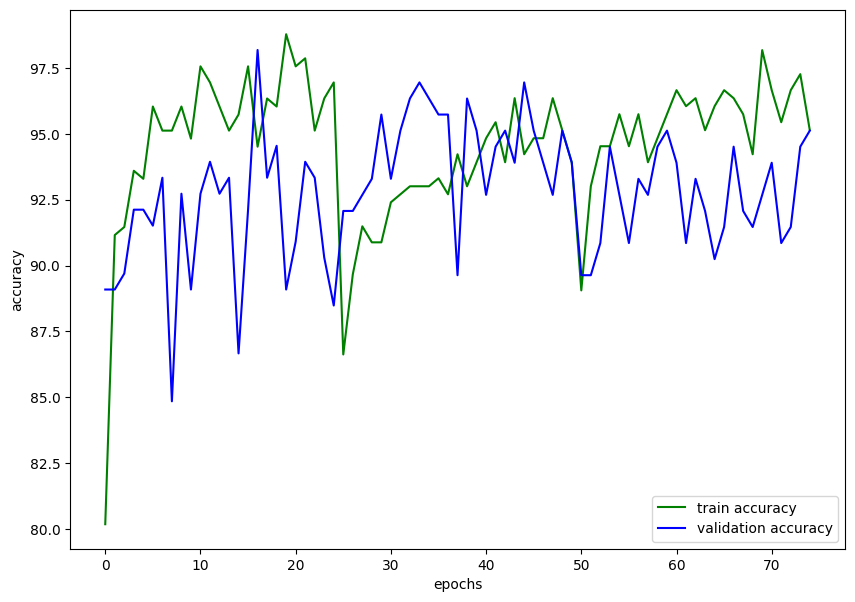

Test_Accuracy : 94.73684210526315
Confusion Matrix on the test set
[[174   4]
 [  6   6]]
kangaroo
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0180 Acc: 89.3293%
[Test #1] Loss: 0.0130 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0155 Acc: 89.9390%
[Test #2] Loss: 0.0135 Acc: 90.9091% 
Epoch 2 running
[Train #3] Loss: 0.0122 Acc: 89.9390%
[Test #3] Loss: 0.0129 Acc: 90.9091% 
Epoch 3 running
[Train #4] Loss: 0.0119 Acc: 91.1585%
[Test #4] Loss: 0.0135 Acc: 91.5152% 
Epoch 4 running
[Train #5] Loss: 0.0126 Acc: 90.8537%
[Test #5] Loss: 0.0131 Acc: 90.9091% 
Epoch 5 running
[Train #6] Loss: 0.0111 Acc: 91.1585%
[Test #6] Loss: 0.0123 Acc: 88.4848% 
Epoch 6 running
[Train #7] Loss: 0.0109 Acc: 90.2439%
[Test #7] Loss: 0.0119 Acc: 90.9091% 
Epoch 7 running
[Train #8] Loss: 0.0100 Acc: 90.5488%
[Test #8] Loss: 0.0133 Acc: 88.4848% 
Epoch 8 running
[Train #9] Loss: 0.0095 Acc: 91.4634%
[Test #9] Loss: 0.0149 Acc: 85.4545% 
Epoch 9 running
[Train #10] Loss: 0.0121 Acc: 90.8537%
[Test #1

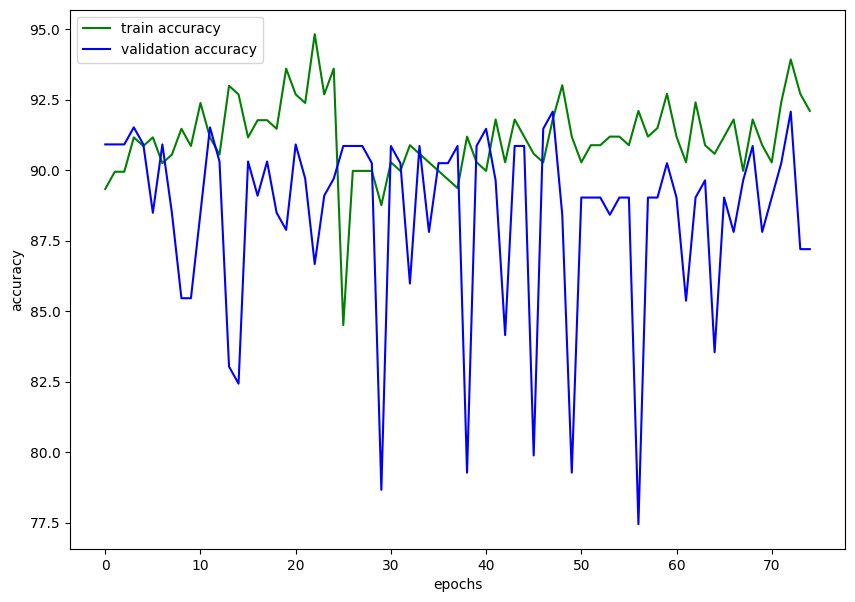

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[176   2]
 [ 10   2]]
koala
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0154 Acc: 91.1585%
[Test #1] Loss: 0.0152 Acc: 88.4848% 
Epoch 1 running
[Train #2] Loss: 0.0131 Acc: 91.1585%
[Test #2] Loss: 0.0151 Acc: 88.4848% 
Epoch 2 running
[Train #3] Loss: 0.0126 Acc: 91.1585%
[Test #3] Loss: 0.0167 Acc: 88.4848% 
Epoch 3 running
[Train #4] Loss: 0.0117 Acc: 91.1585%
[Test #4] Loss: 0.0136 Acc: 88.4848% 
Epoch 4 running
[Train #5] Loss: 0.0107 Acc: 90.2439%
[Test #5] Loss: 0.0203 Acc: 83.0303% 
Epoch 5 running
[Train #6] Loss: 0.0114 Acc: 90.8537%
[Test #6] Loss: 0.0131 Acc: 89.0909% 
Epoch 6 running
[Train #7] Loss: 0.0123 Acc: 89.9390%
[Test #7] Loss: 0.0197 Acc: 88.4848% 
Epoch 7 running
[Train #8] Loss: 0.0107 Acc: 90.5488%
[Test #8] Loss: 0.0120 Acc: 87.2727% 
Epoch 8 running
[Train #9] Loss: 0.0107 Acc: 90.8537%
[Test #9] Loss: 0.0150 Acc: 87.8788% 
Epoch 9 running
[Train #10] Loss: 0.0101 Acc: 90.2439%
[Test #10] L

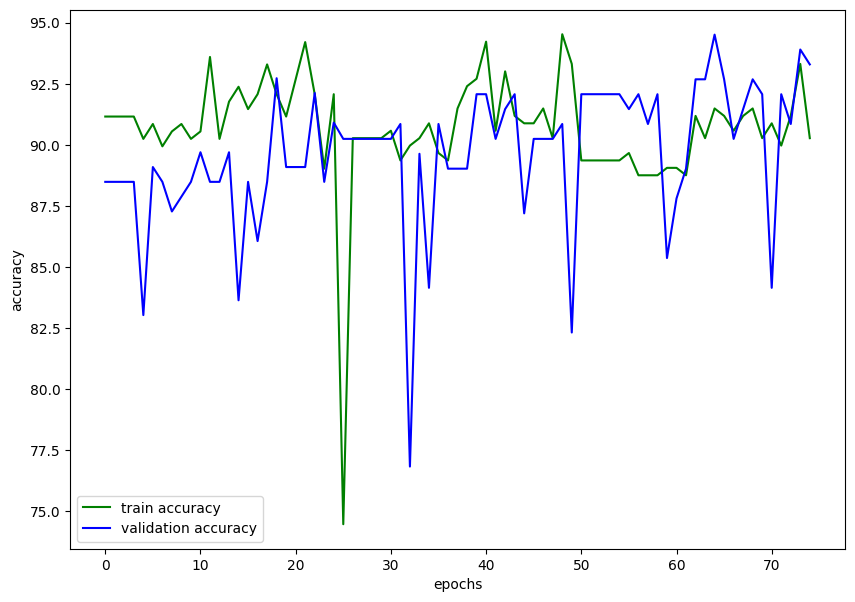

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[178   0]
 [ 12   0]]
ladybugs
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0176 Acc: 86.2805%
[Test #1] Loss: 0.0134 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0131 Acc: 88.1098%
[Test #2] Loss: 0.0149 Acc: 90.9091% 
Epoch 2 running
[Train #3] Loss: 0.0109 Acc: 90.8537%
[Test #3] Loss: 0.0094 Acc: 91.5152% 
Epoch 3 running
[Train #4] Loss: 0.0129 Acc: 89.9390%
[Test #4] Loss: 0.0153 Acc: 86.0606% 
Epoch 4 running
[Train #5] Loss: 0.0092 Acc: 91.4634%
[Test #5] Loss: 0.0076 Acc: 93.9394% 
Epoch 5 running
[Train #6] Loss: 0.0093 Acc: 92.0732%
[Test #6] Loss: 0.0081 Acc: 92.1212% 
Epoch 6 running
[Train #7] Loss: 0.0128 Acc: 90.8537%
[Test #7] Loss: 0.0616 Acc: 67.8788% 
Epoch 7 running
[Train #8] Loss: 0.0147 Acc: 88.7195%
[Test #8] Loss: 0.0131 Acc: 90.9091% 
Epoch 8 running
[Train #9] Loss: 0.0090 Acc: 93.5976%
[Test #9] Loss: 0.0091 Acc: 93.3333% 
Epoch 9 running
[Train #10] Loss: 0.0099 Acc: 91.4634%
[Test #10

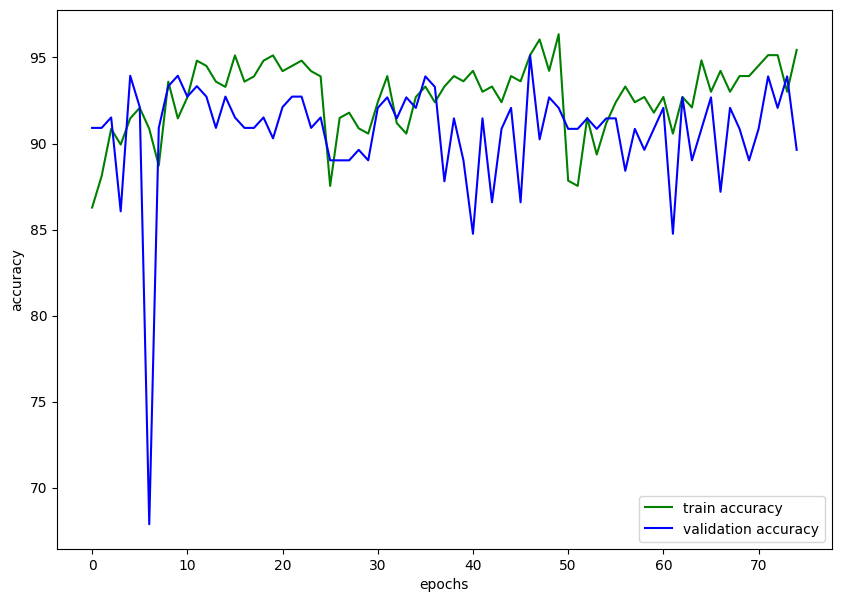

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[173   5]
 [  7   5]]
leopard
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0154 Acc: 89.3293%
[Test #1] Loss: 0.0134 Acc: 90.3030% 
Epoch 1 running
[Train #2] Loss: 0.0138 Acc: 89.9390%
[Test #2] Loss: 0.0173 Acc: 90.3030% 
Epoch 2 running
[Train #3] Loss: 0.0115 Acc: 90.2439%
[Test #3] Loss: 0.0133 Acc: 90.3030% 
Epoch 3 running
[Train #4] Loss: 0.0114 Acc: 90.8537%
[Test #4] Loss: 0.0128 Acc: 90.9091% 
Epoch 4 running
[Train #5] Loss: 0.0117 Acc: 91.1585%
[Test #5] Loss: 0.0102 Acc: 92.1212% 
Epoch 5 running
[Train #6] Loss: 0.0110 Acc: 90.8537%
[Test #6] Loss: 0.0111 Acc: 91.5152% 
Epoch 6 running
[Train #7] Loss: 0.0092 Acc: 92.9878%
[Test #7] Loss: 0.0070 Acc: 95.1515% 
Epoch 7 running
[Train #8] Loss: 0.0078 Acc: 94.8171%
[Test #8] Loss: 0.0204 Acc: 83.0303% 
Epoch 8 running
[Train #9] Loss: 0.0086 Acc: 92.6829%
[Test #9] Loss: 0.0126 Acc: 92.7273% 
Epoch 9 running
[Train #10] Loss: 0.0094 Acc: 92.6829%
[Test #10]

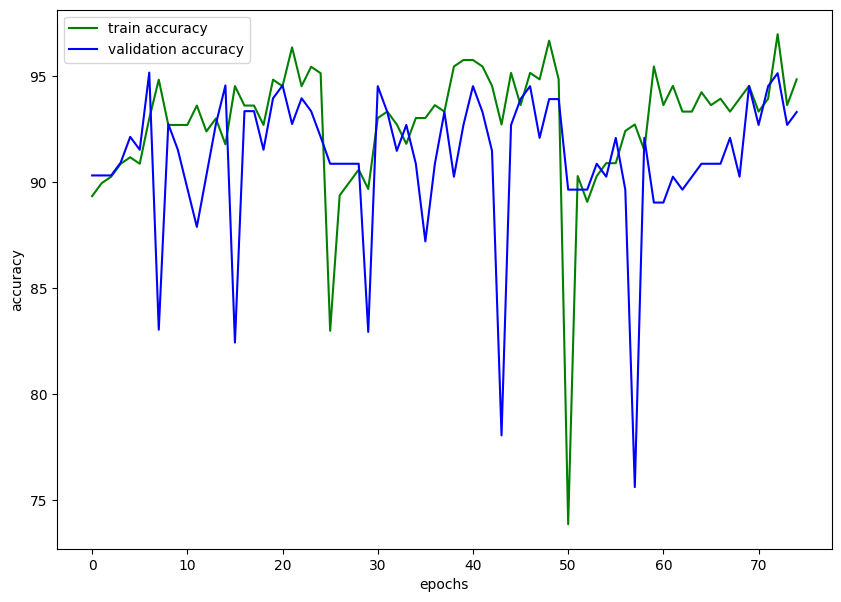

Test_Accuracy : 96.3157894736842
Confusion Matrix on the test set
[[173   5]
 [  2  10]]
lion
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0143 Acc: 89.6341%
[Test #1] Loss: 0.0182 Acc: 91.5152% 
Epoch 1 running
[Train #2] Loss: 0.0123 Acc: 88.4146%
[Test #2] Loss: 0.0112 Acc: 91.5152% 
Epoch 2 running
[Train #3] Loss: 0.0106 Acc: 90.2439%
[Test #3] Loss: 0.0097 Acc: 91.5152% 
Epoch 3 running
[Train #4] Loss: 0.0124 Acc: 84.1463%
[Test #4] Loss: 0.0103 Acc: 92.7273% 
Epoch 4 running
[Train #5] Loss: 0.0107 Acc: 89.6341%
[Test #5] Loss: 0.0095 Acc: 92.1212% 
Epoch 5 running
[Train #6] Loss: 0.0114 Acc: 89.6341%
[Test #6] Loss: 0.0105 Acc: 91.5152% 
Epoch 6 running
[Train #7] Loss: 0.0107 Acc: 88.7195%
[Test #7] Loss: 0.0083 Acc: 92.1212% 
Epoch 7 running
[Train #8] Loss: 0.0099 Acc: 90.8537%
[Test #8] Loss: 0.0085 Acc: 93.9394% 
Epoch 8 running
[Train #9] Loss: 0.0088 Acc: 91.7683%
[Test #9] Loss: 0.0089 Acc: 92.7273% 
Epoch 9 running
[Train #10] Loss: 0.0099 Acc: 88.7195%
[Test #10] Lo

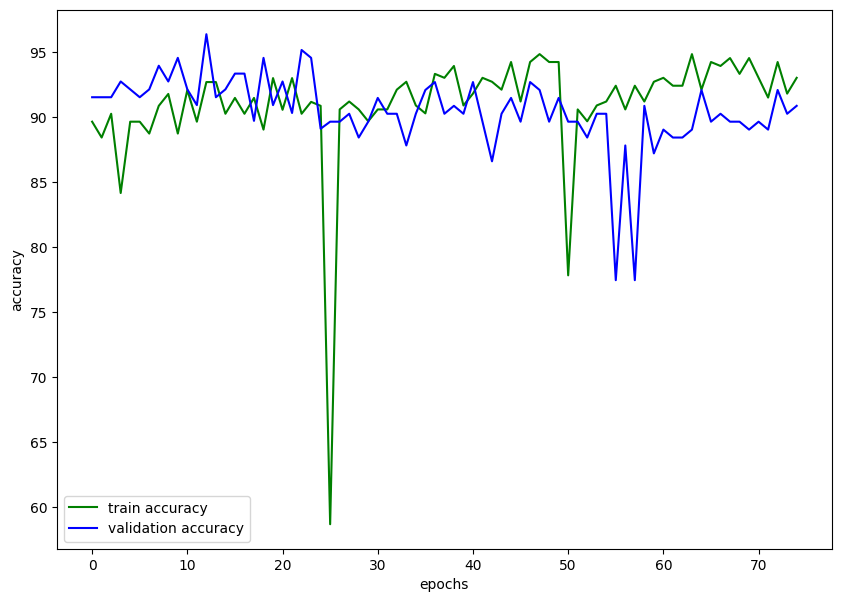

Test_Accuracy : 96.3157894736842
Confusion Matrix on the test set
[[174   4]
 [  3   9]]
lizard
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0205 Acc: 83.2317%
[Test #1] Loss: 0.0127 Acc: 92.7273% 
Epoch 1 running
[Train #2] Loss: 0.0167 Acc: 89.0244%
[Test #2] Loss: 0.0111 Acc: 92.7273% 
Epoch 2 running
[Train #3] Loss: 0.0143 Acc: 88.4146%
[Test #3] Loss: 0.0112 Acc: 92.1212% 
Epoch 3 running
[Train #4] Loss: 0.0145 Acc: 89.0244%
[Test #4] Loss: 0.0132 Acc: 92.7273% 
Epoch 4 running
[Train #5] Loss: 0.0143 Acc: 89.0244%
[Test #5] Loss: 0.0112 Acc: 92.7273% 
Epoch 5 running
[Train #6] Loss: 0.0126 Acc: 89.0244%
[Test #6] Loss: 0.0137 Acc: 91.5152% 
Epoch 6 running
[Train #7] Loss: 0.0135 Acc: 88.4146%
[Test #7] Loss: 0.0133 Acc: 91.5152% 
Epoch 7 running
[Train #8] Loss: 0.0131 Acc: 89.6341%
[Test #8] Loss: 0.0137 Acc: 91.5152% 
Epoch 8 running
[Train #9] Loss: 0.0126 Acc: 89.3293%
[Test #9] Loss: 0.0201 Acc: 84.2424% 
Epoch 9 running
[Train #10] Loss: 0.0129 Acc: 89.0244%
[Test #10] 

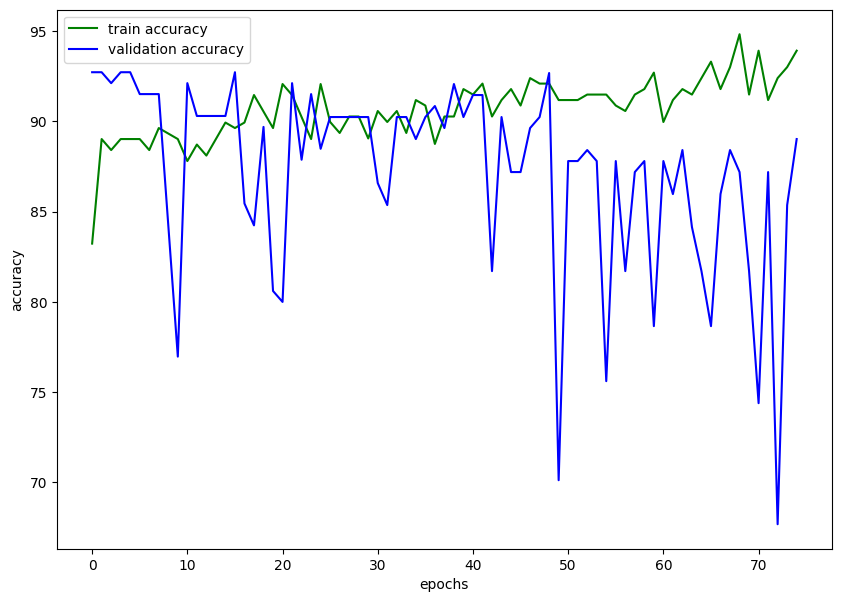

Test_Accuracy : 90.52631578947368
Confusion Matrix on the test set
[[171   7]
 [ 11   1]]
lobster
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0175 Acc: 82.9268%
[Test #1] Loss: 0.0125 Acc: 91.5152% 
Epoch 1 running
[Train #2] Loss: 0.0141 Acc: 88.4146%
[Test #2] Loss: 0.0212 Acc: 91.5152% 
Epoch 2 running
[Train #3] Loss: 0.0119 Acc: 90.5488%
[Test #3] Loss: 0.0147 Acc: 91.5152% 
Epoch 3 running
[Train #4] Loss: 0.0120 Acc: 89.6341%
[Test #4] Loss: 0.0106 Acc: 92.1212% 
Epoch 4 running
[Train #5] Loss: 0.0102 Acc: 92.3780%
[Test #5] Loss: 0.0090 Acc: 91.5152% 
Epoch 5 running
[Train #6] Loss: 0.0094 Acc: 93.2927%
[Test #6] Loss: 0.0121 Acc: 92.1212% 
Epoch 6 running
[Train #7] Loss: 0.0106 Acc: 91.4634%
[Test #7] Loss: 0.0089 Acc: 90.9091% 
Epoch 7 running
[Train #8] Loss: 0.0103 Acc: 91.4634%
[Test #8] Loss: 0.0133 Acc: 92.1212% 
Epoch 8 running
[Train #9] Loss: 0.0090 Acc: 92.6829%
[Test #9] Loss: 0.0137 Acc: 89.6970% 
Epoch 9 running
[Train #10] Loss: 0.0096 Acc: 90.5488%
[Test #10

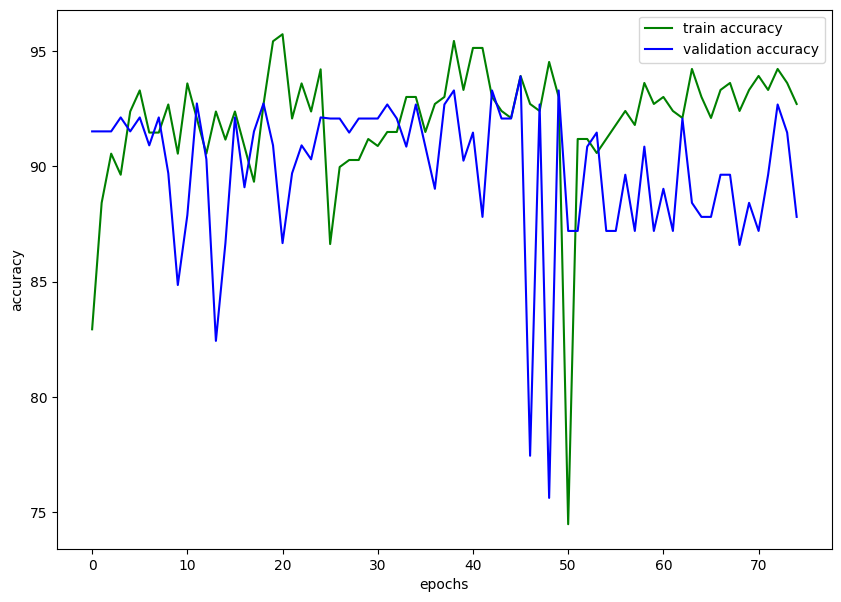

Test_Accuracy : 93.15789473684211
Confusion Matrix on the test set
[[175   3]
 [ 10   2]]
mosquito
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0350 Acc: 56.0976%
[Test #1] Loss: 0.0141 Acc: 91.5152% 
Epoch 1 running
[Train #2] Loss: 0.0144 Acc: 89.6341%
[Test #2] Loss: 0.0148 Acc: 91.5152% 
Epoch 2 running
[Train #3] Loss: 0.0131 Acc: 88.1098%
[Test #3] Loss: 0.0096 Acc: 91.5152% 
Epoch 3 running
[Train #4] Loss: 0.0114 Acc: 89.3293%
[Test #4] Loss: 0.0089 Acc: 92.1212% 
Epoch 4 running
[Train #5] Loss: 0.0101 Acc: 90.8537%
[Test #5] Loss: 0.0216 Acc: 90.9091% 
Epoch 5 running
[Train #6] Loss: 0.0087 Acc: 90.8537%
[Test #6] Loss: 0.0326 Acc: 80.0000% 
Epoch 6 running
[Train #7] Loss: 0.0089 Acc: 91.7683%
[Test #7] Loss: 0.0280 Acc: 92.7273% 
Epoch 7 running
[Train #8] Loss: 0.0085 Acc: 89.6341%
[Test #8] Loss: 0.0113 Acc: 91.5152% 
Epoch 8 running
[Train #9] Loss: 0.0086 Acc: 90.5488%
[Test #9] Loss: 0.0104 Acc: 94.5455% 
Epoch 9 running
[Train #10] Loss: 0.0091 Acc: 92.0732%
[Test #1

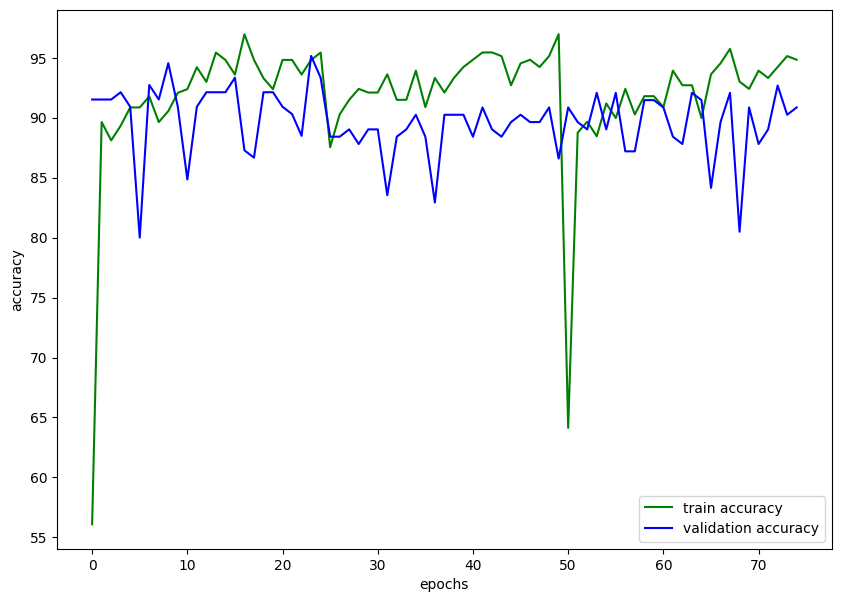

Test_Accuracy : 94.73684210526315
Confusion Matrix on the test set
[[177   1]
 [  9   3]]
moth
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0223 Acc: 72.2561%
[Test #1] Loss: 0.0142 Acc: 89.6970% 
Epoch 1 running
[Train #2] Loss: 0.0153 Acc: 88.7195%
[Test #2] Loss: 0.0256 Acc: 89.6970% 
Epoch 2 running
[Train #3] Loss: 0.0162 Acc: 90.5488%
[Test #3] Loss: 0.0198 Acc: 89.0909% 
Epoch 3 running
[Train #4] Loss: 0.0134 Acc: 89.6341%
[Test #4] Loss: 0.0146 Acc: 90.3030% 
Epoch 4 running
[Train #5] Loss: 0.0118 Acc: 89.3293%
[Test #5] Loss: 0.0132 Acc: 89.6970% 
Epoch 5 running
[Train #6] Loss: 0.0133 Acc: 89.9390%
[Test #6] Loss: 0.0134 Acc: 89.6970% 
Epoch 6 running
[Train #7] Loss: 0.0116 Acc: 90.8537%
[Test #7] Loss: 0.0162 Acc: 88.4848% 
Epoch 7 running
[Train #8] Loss: 0.0116 Acc: 90.5488%
[Test #8] Loss: 0.0214 Acc: 87.8788% 
Epoch 8 running
[Train #9] Loss: 0.0106 Acc: 90.5488%
[Test #9] Loss: 0.0273 Acc: 86.6667% 
Epoch 9 running
[Train #10] Loss: 0.0139 Acc: 89.6341%
[Test #10] L

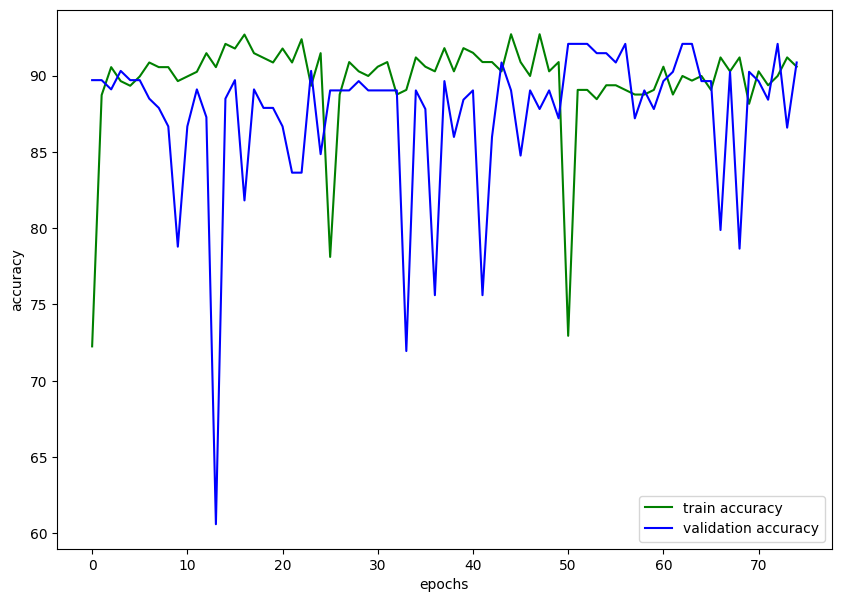

Test_Accuracy : 92.63157894736842
Confusion Matrix on the test set
[[175   3]
 [ 11   1]]
mouse
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0160 Acc: 86.5854%
[Test #1] Loss: 0.0159 Acc: 88.4848% 
Epoch 1 running
[Train #2] Loss: 0.0122 Acc: 91.1585%
[Test #2] Loss: 0.0149 Acc: 88.4848% 
Epoch 2 running
[Train #3] Loss: 0.0111 Acc: 90.5488%
[Test #3] Loss: 0.0184 Acc: 87.2727% 
Epoch 3 running
[Train #4] Loss: 0.0126 Acc: 91.4634%
[Test #4] Loss: 0.0130 Acc: 86.6667% 
Epoch 4 running
[Train #5] Loss: 0.0115 Acc: 90.5488%
[Test #5] Loss: 0.0185 Acc: 83.0303% 
Epoch 5 running
[Train #6] Loss: 0.0108 Acc: 90.8537%
[Test #6] Loss: 0.0214 Acc: 88.4848% 
Epoch 6 running
[Train #7] Loss: 0.0121 Acc: 90.5488%
[Test #7] Loss: 0.0123 Acc: 87.8788% 
Epoch 7 running
[Train #8] Loss: 0.0102 Acc: 91.7683%
[Test #8] Loss: 0.0110 Acc: 89.0909% 
Epoch 8 running
[Train #9] Loss: 0.0100 Acc: 91.7683%
[Test #9] Loss: 0.0168 Acc: 87.2727% 
Epoch 9 running
[Train #10] Loss: 0.0100 Acc: 91.1585%
[Test #10] 

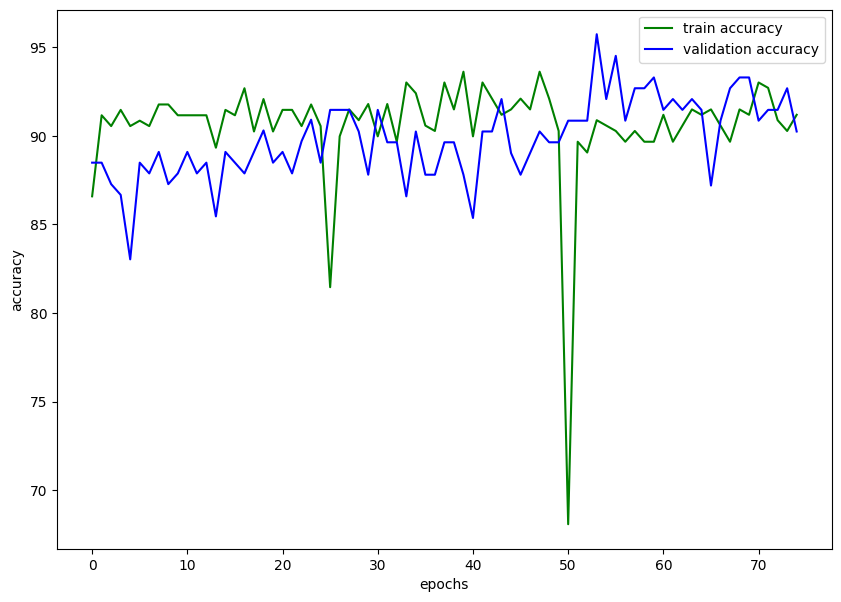

Test_Accuracy : 94.21052631578948
Confusion Matrix on the test set
[[177   1]
 [ 10   2]]
octopus
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0195 Acc: 78.3537%
[Test #1] Loss: 0.0153 Acc: 88.4848% 
Epoch 1 running
[Train #2] Loss: 0.0127 Acc: 90.8537%
[Test #2] Loss: 0.0289 Acc: 88.4848% 
Epoch 2 running
[Train #3] Loss: 0.0127 Acc: 91.1585%
[Test #3] Loss: 0.0221 Acc: 88.4848% 
Epoch 3 running
[Train #4] Loss: 0.0115 Acc: 90.8537%
[Test #4] Loss: 0.0205 Acc: 88.4848% 
Epoch 4 running
[Train #5] Loss: 0.0116 Acc: 90.5488%
[Test #5] Loss: 0.0156 Acc: 86.0606% 
Epoch 5 running
[Train #6] Loss: 0.0106 Acc: 91.4634%
[Test #6] Loss: 0.0182 Acc: 84.2424% 
Epoch 6 running
[Train #7] Loss: 0.0126 Acc: 90.2439%
[Test #7] Loss: 0.0175 Acc: 85.4545% 
Epoch 7 running
[Train #8] Loss: 0.0108 Acc: 91.4634%
[Test #8] Loss: 0.0174 Acc: 87.2727% 
Epoch 8 running
[Train #9] Loss: 0.0116 Acc: 89.3293%
[Test #9] Loss: 0.0310 Acc: 88.4848% 
Epoch 9 running
[Train #10] Loss: 0.0117 Acc: 90.2439%
[Test #10

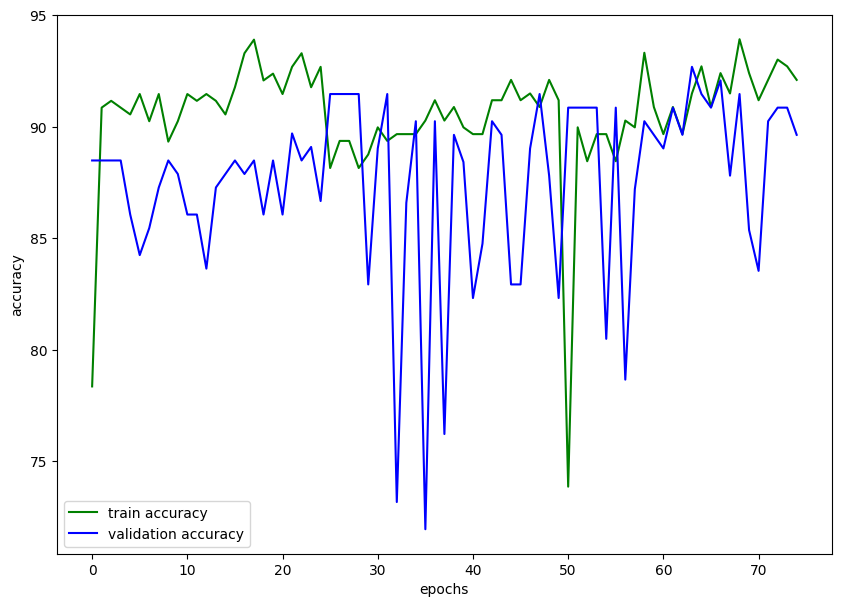

Test_Accuracy : 94.21052631578948
Confusion Matrix on the test set
[[176   2]
 [  9   3]]
okapi
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0179 Acc: 76.5244%
[Test #1] Loss: 0.0161 Acc: 87.8788% 
Epoch 1 running
[Train #2] Loss: 0.0167 Acc: 90.5488%
[Test #2] Loss: 0.0290 Acc: 87.8788% 
Epoch 2 running
[Train #3] Loss: 0.0128 Acc: 91.4634%
[Test #3] Loss: 0.0237 Acc: 87.8788% 
Epoch 3 running
[Train #4] Loss: 0.0121 Acc: 91.1585%
[Test #4] Loss: 0.0145 Acc: 87.8788% 
Epoch 4 running
[Train #5] Loss: 0.0107 Acc: 91.4634%
[Test #5] Loss: 0.0128 Acc: 87.8788% 
Epoch 5 running
[Train #6] Loss: 0.0110 Acc: 91.1585%
[Test #6] Loss: 0.0144 Acc: 87.8788% 
Epoch 6 running
[Train #7] Loss: 0.0106 Acc: 90.2439%
[Test #7] Loss: 0.0163 Acc: 87.8788% 
Epoch 7 running
[Train #8] Loss: 0.0107 Acc: 91.4634%
[Test #8] Loss: 0.0151 Acc: 87.8788% 
Epoch 8 running
[Train #9] Loss: 0.0085 Acc: 92.0732%
[Test #9] Loss: 0.0118 Acc: 88.4848% 
Epoch 9 running
[Train #10] Loss: 0.0079 Acc: 92.3780%
[Test #10] 

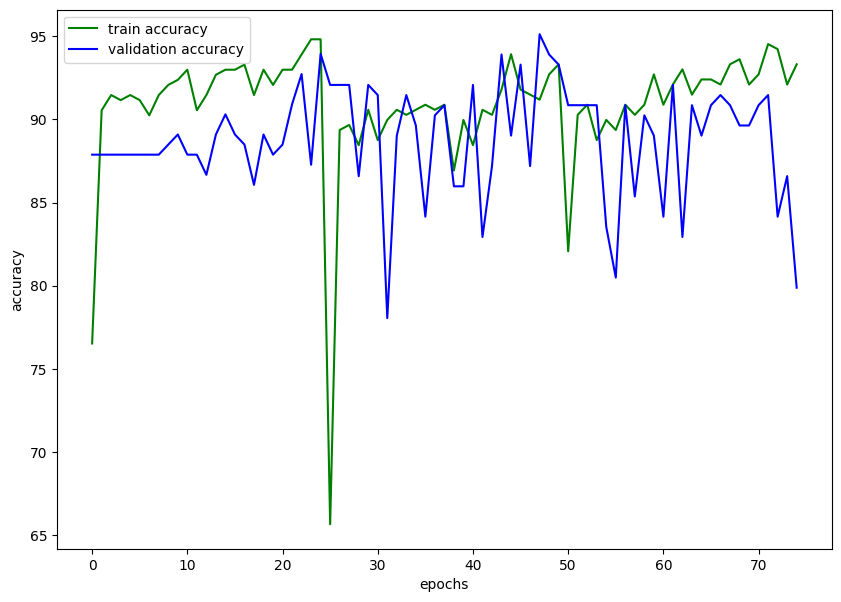

Test_Accuracy : 64.21052631578948
Confusion Matrix on the test set
[[110  68]
 [  0  12]]
orangutan
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0268 Acc: 68.5976%
[Test #1] Loss: 0.0168 Acc: 92.7273% 
Epoch 1 running
[Train #2] Loss: 0.0168 Acc: 89.0244%
[Test #2] Loss: 0.0112 Acc: 92.7273% 
Epoch 2 running
[Train #3] Loss: 0.0134 Acc: 88.7195%
[Test #3] Loss: 0.0090 Acc: 93.3333% 
Epoch 3 running
[Train #4] Loss: 0.0128 Acc: 89.6341%
[Test #4] Loss: 0.0107 Acc: 93.3333% 
Epoch 4 running
[Train #5] Loss: 0.0099 Acc: 90.8537%
[Test #5] Loss: 0.0116 Acc: 88.4848% 
Epoch 5 running
[Train #6] Loss: 0.0102 Acc: 89.9390%
[Test #6] Loss: 0.0095 Acc: 92.7273% 
Epoch 6 running
[Train #7] Loss: 0.0108 Acc: 89.0244%
[Test #7] Loss: 0.0117 Acc: 92.1212% 
Epoch 7 running
[Train #8] Loss: 0.0090 Acc: 90.8537%
[Test #8] Loss: 0.0076 Acc: 93.9394% 
Epoch 8 running
[Train #9] Loss: 0.0083 Acc: 92.9878%
[Test #9] Loss: 0.0111 Acc: 88.4848% 
Epoch 9 running
[Train #10] Loss: 0.0089 Acc: 90.8537%
[Test #

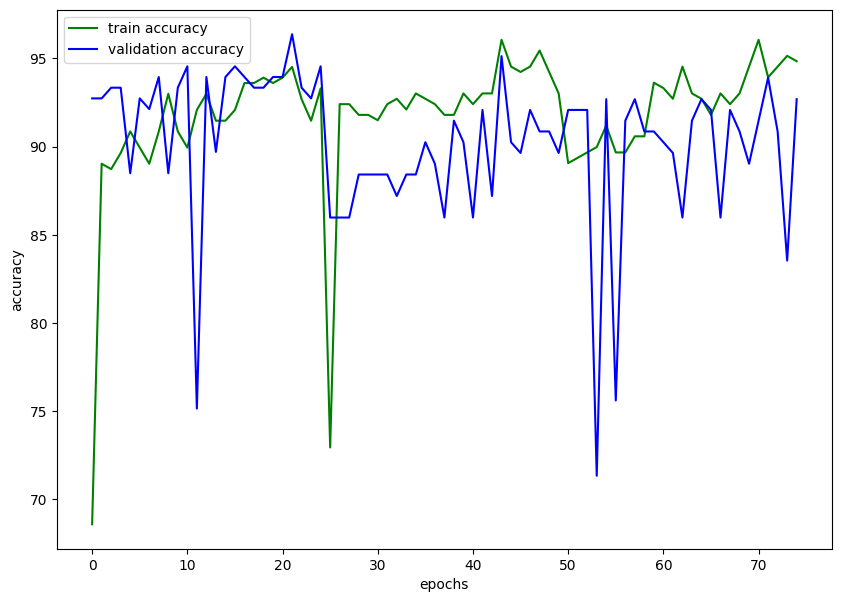

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[176   2]
 [ 10   2]]
otter
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0161 Acc: 87.8049%
[Test #1] Loss: 0.0152 Acc: 92.1212% 
Epoch 1 running
[Train #2] Loss: 0.0172 Acc: 89.3293%
[Test #2] Loss: 0.0145 Acc: 92.1212% 
Epoch 2 running
[Train #3] Loss: 0.0145 Acc: 89.0244%
[Test #3] Loss: 0.0115 Acc: 92.1212% 
Epoch 3 running
[Train #4] Loss: 0.0137 Acc: 89.3293%
[Test #4] Loss: 0.0110 Acc: 92.1212% 
Epoch 4 running
[Train #5] Loss: 0.0133 Acc: 89.0244%
[Test #5] Loss: 0.0109 Acc: 92.1212% 
Epoch 5 running
[Train #6] Loss: 0.0142 Acc: 88.7195%
[Test #6] Loss: 0.0125 Acc: 92.1212% 
Epoch 6 running
[Train #7] Loss: 0.0139 Acc: 88.4146%
[Test #7] Loss: 0.0136 Acc: 90.3030% 
Epoch 7 running
[Train #8] Loss: 0.0131 Acc: 89.3293%
[Test #8] Loss: 0.0107 Acc: 92.1212% 
Epoch 8 running
[Train #9] Loss: 0.0139 Acc: 89.0244%
[Test #9] Loss: 0.0097 Acc: 92.1212% 
Epoch 9 running
[Train #10] Loss: 0.0128 Acc: 89.6341%
[Test #10] L

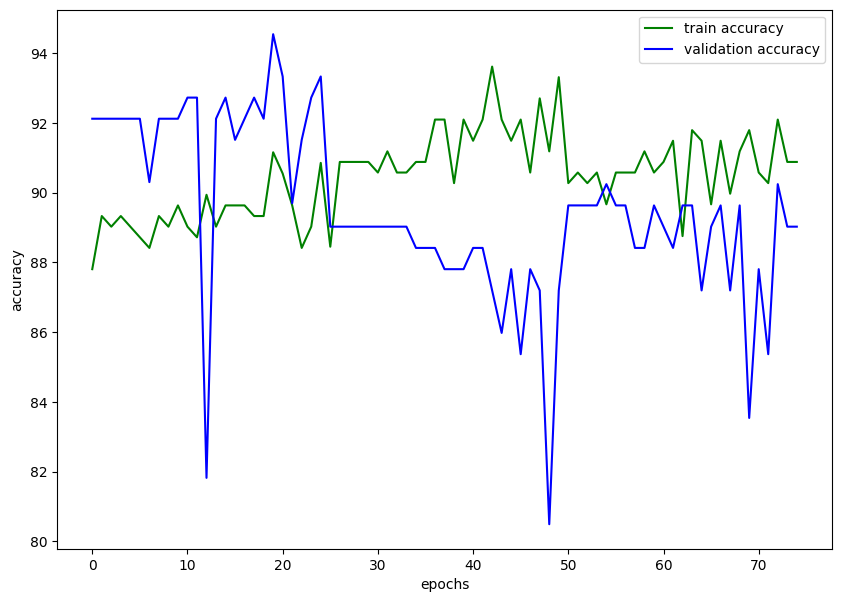

Test_Accuracy : 91.57894736842105
Confusion Matrix on the test set
[[169   9]
 [  7   5]]
owl
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0142 Acc: 90.2439%
[Test #1] Loss: 0.0186 Acc: 86.0606% 
Epoch 1 running
[Train #2] Loss: 0.0132 Acc: 92.3780%
[Test #2] Loss: 0.0330 Acc: 86.0606% 
Epoch 2 running
[Train #3] Loss: 0.0109 Acc: 92.3780%
[Test #3] Loss: 0.0298 Acc: 86.0606% 
Epoch 3 running
[Train #4] Loss: 0.0109 Acc: 92.3780%
[Test #4] Loss: 0.0223 Acc: 86.0606% 
Epoch 4 running
[Train #5] Loss: 0.0103 Acc: 92.3780%
[Test #5] Loss: 0.0259 Acc: 86.0606% 
Epoch 5 running
[Train #6] Loss: 0.0094 Acc: 92.0732%
[Test #6] Loss: 0.0226 Acc: 80.0000% 
Epoch 6 running
[Train #7] Loss: 0.0105 Acc: 92.0732%
[Test #7] Loss: 0.0213 Acc: 86.6667% 
Epoch 7 running
[Train #8] Loss: 0.0107 Acc: 92.3780%
[Test #8] Loss: 0.0202 Acc: 86.0606% 
Epoch 8 running
[Train #9] Loss: 0.0112 Acc: 92.3780%
[Test #9] Loss: 0.0193 Acc: 86.0606% 
Epoch 9 running
[Train #10] Loss: 0.0106 Acc: 91.7683%
[Test #10] Lo

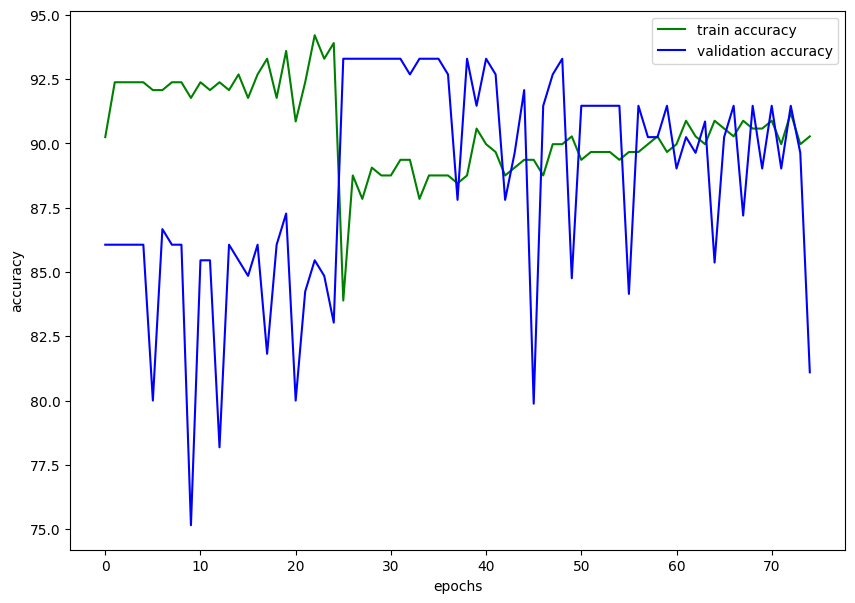

Test_Accuracy : 68.42105263157895
Confusion Matrix on the test set
[[124  54]
 [  6   6]]
ox
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0184 Acc: 84.4512%
[Test #1] Loss: 0.0134 Acc: 92.1212% 
Epoch 1 running
[Train #2] Loss: 0.0153 Acc: 89.3293%
[Test #2] Loss: 0.0126 Acc: 92.1212% 
Epoch 2 running
[Train #3] Loss: 0.0139 Acc: 89.3293%
[Test #3] Loss: 0.0134 Acc: 92.1212% 
Epoch 3 running
[Train #4] Loss: 0.0143 Acc: 89.3293%
[Test #4] Loss: 0.0127 Acc: 92.1212% 
Epoch 4 running
[Train #5] Loss: 0.0141 Acc: 89.3293%
[Test #5] Loss: 0.0130 Acc: 92.1212% 
Epoch 5 running
[Train #6] Loss: 0.0140 Acc: 89.6341%
[Test #6] Loss: 0.0126 Acc: 92.1212% 
Epoch 6 running
[Train #7] Loss: 0.0140 Acc: 89.6341%
[Test #7] Loss: 0.0157 Acc: 86.0606% 
Epoch 7 running
[Train #8] Loss: 0.0136 Acc: 88.4146%
[Test #8] Loss: 0.0168 Acc: 86.6667% 
Epoch 8 running
[Train #9] Loss: 0.0133 Acc: 89.3293%
[Test #9] Loss: 0.0138 Acc: 92.1212% 
Epoch 9 running
[Train #10] Loss: 0.0138 Acc: 89.3293%
[Test #10] Los

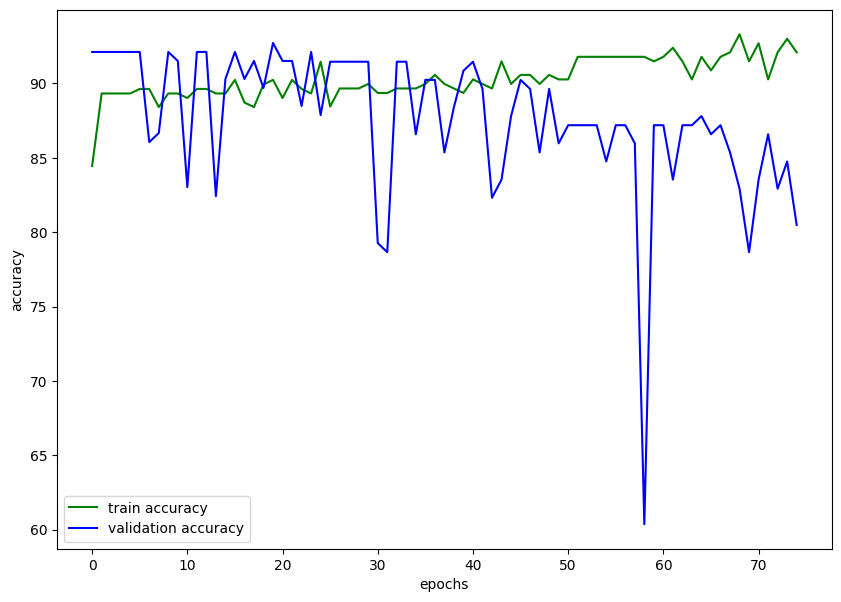

Test_Accuracy : 90.0
Confusion Matrix on the test set
[[166  12]
 [  7   5]]
oyster
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0164 Acc: 89.9390%
[Test #1] Loss: 0.0149 Acc: 89.0909% 
Epoch 1 running
[Train #2] Loss: 0.0145 Acc: 89.6341%
[Test #2] Loss: 0.0233 Acc: 89.0909% 
Epoch 2 running
[Train #3] Loss: 0.0139 Acc: 88.7195%
[Test #3] Loss: 0.0177 Acc: 89.0909% 
Epoch 3 running
[Train #4] Loss: 0.0141 Acc: 90.8537%
[Test #4] Loss: 0.0195 Acc: 78.1818% 
Epoch 4 running
[Train #5] Loss: 0.0122 Acc: 90.8537%
[Test #5] Loss: 0.0149 Acc: 89.0909% 
Epoch 5 running
[Train #6] Loss: 0.0109 Acc: 90.5488%
[Test #6] Loss: 0.0118 Acc: 89.0909% 
Epoch 6 running
[Train #7] Loss: 0.0098 Acc: 90.2439%
[Test #7] Loss: 0.0124 Acc: 88.4848% 
Epoch 7 running
[Train #8] Loss: 0.0110 Acc: 90.5488%
[Test #8] Loss: 0.0298 Acc: 68.4848% 
Epoch 8 running
[Train #9] Loss: 0.0097 Acc: 91.1585%
[Test #9] Loss: 0.0110 Acc: 89.0909% 
Epoch 9 running
[Train #10] Loss: 0.0087 Acc: 91.7683%
[Test #10] Loss: 0.0107

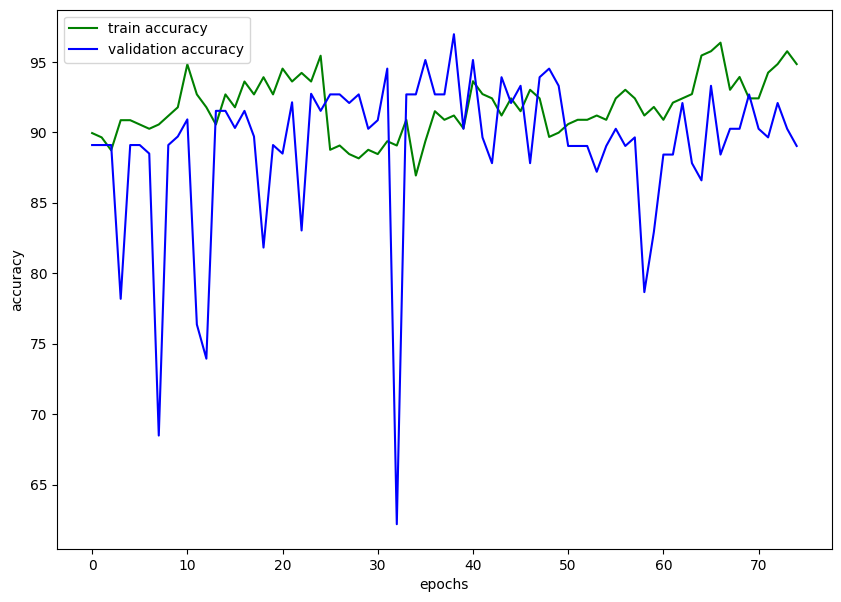

Test_Accuracy : 78.42105263157895
Confusion Matrix on the test set
[[141  37]
 [  4   8]]
panda
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0170 Acc: 88.4146%
[Test #1] Loss: 0.0143 Acc: 89.6970% 
Epoch 1 running
[Train #2] Loss: 0.0124 Acc: 90.5488%
[Test #2] Loss: 0.0200 Acc: 89.6970% 
Epoch 2 running
[Train #3] Loss: 0.0119 Acc: 90.5488%
[Test #3] Loss: 0.0129 Acc: 89.6970% 
Epoch 3 running
[Train #4] Loss: 0.0108 Acc: 89.9390%
[Test #4] Loss: 0.0124 Acc: 89.6970% 
Epoch 4 running
[Train #5] Loss: 0.0134 Acc: 89.9390%
[Test #5] Loss: 0.0136 Acc: 90.3030% 
Epoch 5 running
[Train #6] Loss: 0.0110 Acc: 90.5488%
[Test #6] Loss: 0.0103 Acc: 90.3030% 
Epoch 6 running
[Train #7] Loss: 0.0102 Acc: 89.9390%
[Test #7] Loss: 0.0088 Acc: 90.9091% 
Epoch 7 running
[Train #8] Loss: 0.0104 Acc: 90.8537%
[Test #8] Loss: 0.0109 Acc: 91.5152% 
Epoch 8 running
[Train #9] Loss: 0.0083 Acc: 91.7683%
[Test #9] Loss: 0.0094 Acc: 91.5152% 
Epoch 9 running
[Train #10] Loss: 0.0073 Acc: 93.2927%
[Test #10] 

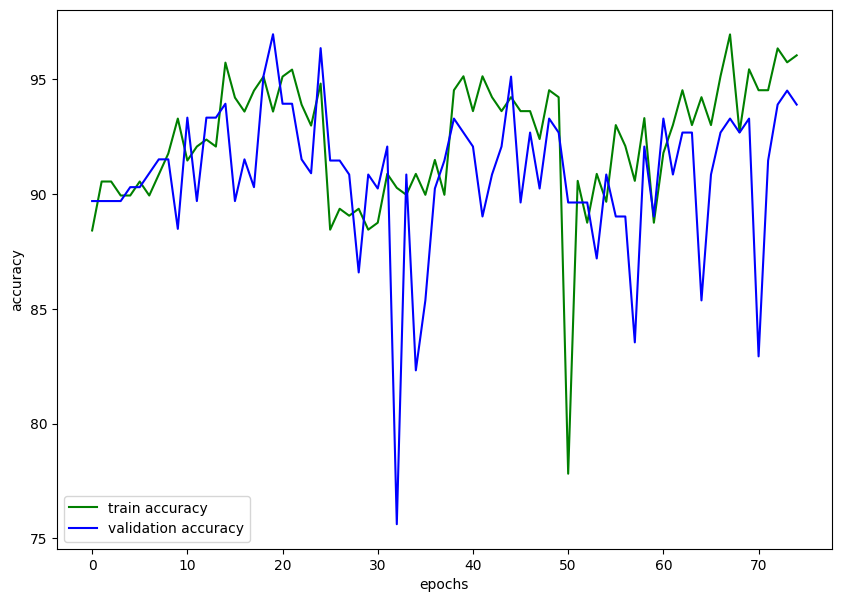

Test_Accuracy : 97.89473684210527
Confusion Matrix on the test set
[[178   0]
 [  4   8]]
parrot
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0206 Acc: 78.0488%
[Test #1] Loss: 0.0156 Acc: 87.8788% 
Epoch 1 running
[Train #2] Loss: 0.0122 Acc: 91.1585%
[Test #2] Loss: 0.0312 Acc: 87.8788% 
Epoch 2 running
[Train #3] Loss: 0.0121 Acc: 90.5488%
[Test #3] Loss: 0.0226 Acc: 87.2727% 
Epoch 3 running
[Train #4] Loss: 0.0105 Acc: 91.4634%
[Test #4] Loss: 0.0189 Acc: 87.8788% 
Epoch 4 running
[Train #5] Loss: 0.0102 Acc: 91.1585%
[Test #5] Loss: 0.0382 Acc: 87.8788% 
Epoch 5 running
[Train #6] Loss: 0.0107 Acc: 92.3780%
[Test #6] Loss: 0.0476 Acc: 71.5152% 
Epoch 6 running
[Train #7] Loss: 0.0100 Acc: 91.7683%
[Test #7] Loss: 0.0202 Acc: 84.2424% 
Epoch 7 running
[Train #8] Loss: 0.0093 Acc: 92.6829%
[Test #8] Loss: 0.0127 Acc: 89.6970% 
Epoch 8 running
[Train #9] Loss: 0.0086 Acc: 94.5122%
[Test #9] Loss: 0.0134 Acc: 91.5152% 
Epoch 9 running
[Train #10] Loss: 0.0084 Acc: 92.9878%
[Test #10]

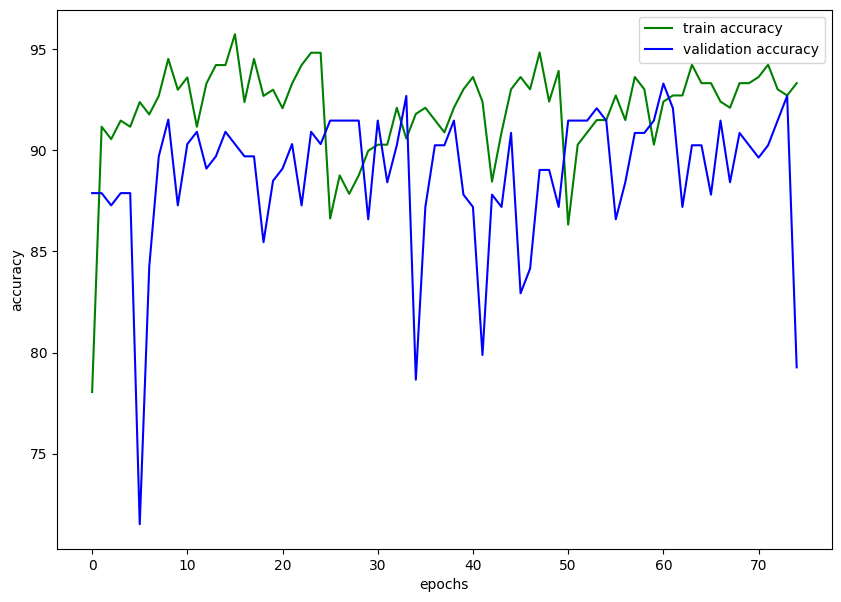

Test_Accuracy : 54.736842105263165
Confusion Matrix on the test set
[[94 84]
 [ 2 10]]
pelecaniformes
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0168 Acc: 88.4146%
[Test #1] Loss: 0.0138 Acc: 90.3030% 
Epoch 1 running
[Train #2] Loss: 0.0148 Acc: 90.2439%
[Test #2] Loss: 0.0160 Acc: 90.3030% 
Epoch 2 running
[Train #3] Loss: 0.0139 Acc: 90.2439%
[Test #3] Loss: 0.0150 Acc: 90.3030% 
Epoch 3 running
[Train #4] Loss: 0.0129 Acc: 89.9390%
[Test #4] Loss: 0.0162 Acc: 86.6667% 
Epoch 4 running
[Train #5] Loss: 0.0134 Acc: 89.9390%
[Test #5] Loss: 0.0242 Acc: 74.5455% 
Epoch 5 running
[Train #6] Loss: 0.0126 Acc: 90.5488%
[Test #6] Loss: 0.0173 Acc: 90.3030% 
Epoch 6 running
[Train #7] Loss: 0.0115 Acc: 90.8537%
[Test #7] Loss: 0.0139 Acc: 90.3030% 
Epoch 7 running
[Train #8] Loss: 0.0100 Acc: 89.9390%
[Test #8] Loss: 0.0332 Acc: 76.3636% 
Epoch 8 running
[Train #9] Loss: 0.0107 Acc: 90.5488%
[Test #9] Loss: 0.0130 Acc: 89.6970% 
Epoch 9 running
[Train #10] Loss: 0.0118 Acc: 90.2439%
[Test

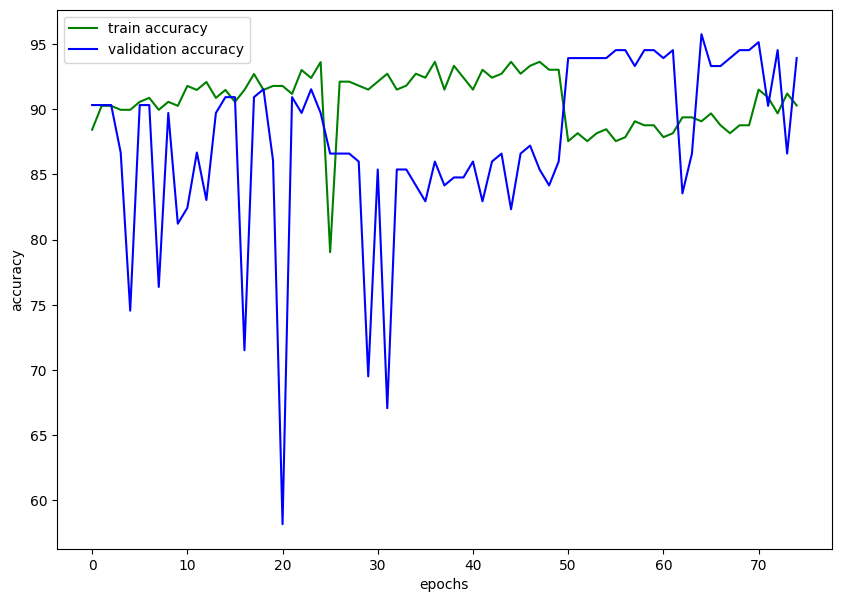

Test_Accuracy : 92.10526315789474
Confusion Matrix on the test set
[[169   9]
 [  6   6]]
penguin
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0188 Acc: 82.6220%
[Test #1] Loss: 0.0126 Acc: 91.5152% 
Epoch 1 running
[Train #2] Loss: 0.0135 Acc: 90.5488%
[Test #2] Loss: 0.0125 Acc: 89.6970% 
Epoch 2 running
[Train #3] Loss: 0.0129 Acc: 88.4146%
[Test #3] Loss: 0.0149 Acc: 91.5152% 
Epoch 3 running
[Train #4] Loss: 0.0112 Acc: 90.2439%
[Test #4] Loss: 0.0183 Acc: 85.4545% 
Epoch 4 running
[Train #5] Loss: 0.0101 Acc: 89.9390%
[Test #5] Loss: 0.0112 Acc: 91.5152% 
Epoch 5 running
[Train #6] Loss: 0.0114 Acc: 91.4634%
[Test #6] Loss: 0.0137 Acc: 88.4848% 
Epoch 6 running
[Train #7] Loss: 0.0127 Acc: 89.3293%
[Test #7] Loss: 0.0124 Acc: 90.9091% 
Epoch 7 running
[Train #8] Loss: 0.0084 Acc: 93.5976%
[Test #8] Loss: 0.0108 Acc: 92.1212% 
Epoch 8 running
[Train #9] Loss: 0.0088 Acc: 92.9878%
[Test #9] Loss: 0.0230 Acc: 84.8485% 
Epoch 9 running
[Train #10] Loss: 0.0089 Acc: 92.3780%
[Test #10

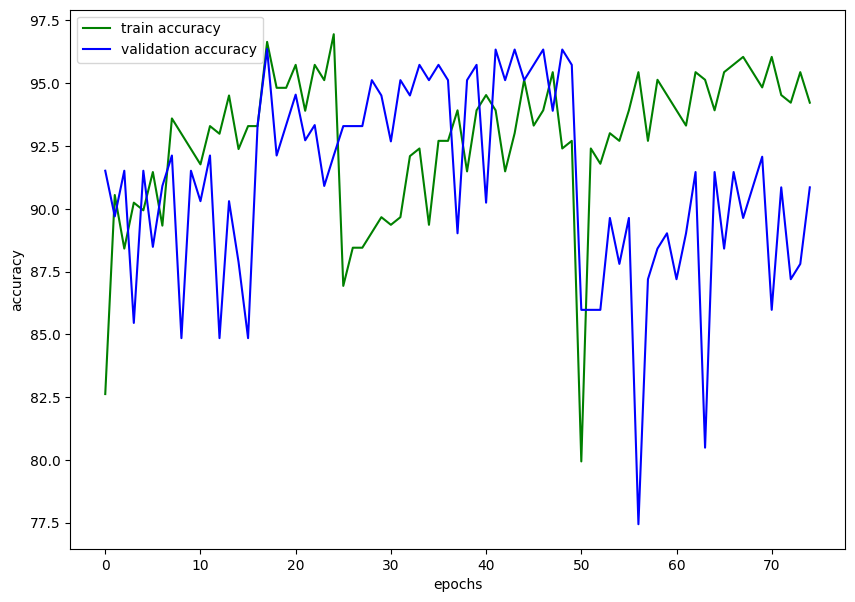

Test_Accuracy : 86.8421052631579
Confusion Matrix on the test set
[[156  22]
 [  3   9]]
pig
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0162 Acc: 89.6341%
[Test #1] Loss: 0.0180 Acc: 91.5152% 
Epoch 1 running
[Train #2] Loss: 0.0137 Acc: 89.6341%
[Test #2] Loss: 0.0128 Acc: 91.5152% 
Epoch 2 running
[Train #3] Loss: 0.0142 Acc: 89.6341%
[Test #3] Loss: 0.0126 Acc: 91.5152% 
Epoch 3 running
[Train #4] Loss: 0.0138 Acc: 89.6341%
[Test #4] Loss: 0.0104 Acc: 92.1212% 
Epoch 4 running
[Train #5] Loss: 0.0122 Acc: 89.9390%
[Test #5] Loss: 0.0089 Acc: 92.7273% 
Epoch 5 running
[Train #6] Loss: 0.0132 Acc: 88.4146%
[Test #6] Loss: 0.0125 Acc: 92.7273% 
Epoch 6 running
[Train #7] Loss: 0.0108 Acc: 90.5488%
[Test #7] Loss: 0.0102 Acc: 88.4848% 
Epoch 7 running
[Train #8] Loss: 0.0119 Acc: 90.5488%
[Test #8] Loss: 0.0103 Acc: 91.5152% 
Epoch 8 running
[Train #9] Loss: 0.0116 Acc: 89.9390%
[Test #9] Loss: 0.0238 Acc: 69.6970% 
Epoch 9 running
[Train #10] Loss: 0.0113 Acc: 89.6341%
[Test #10] Los

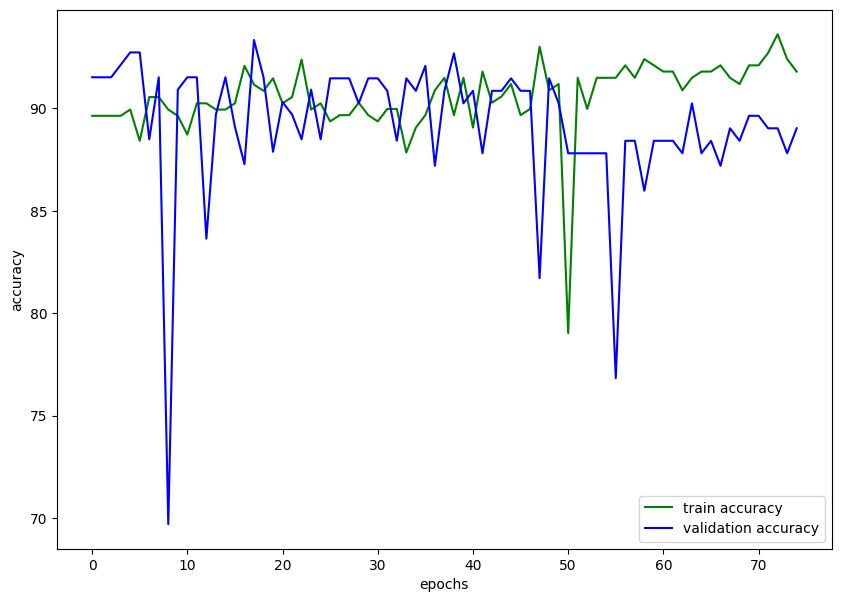

Test_Accuracy : 94.73684210526315
Confusion Matrix on the test set
[[177   1]
 [  9   3]]
pigeon
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0184 Acc: 75.3049%
[Test #1] Loss: 0.0167 Acc: 88.4848% 
Epoch 1 running
[Train #2] Loss: 0.0131 Acc: 91.1585%
[Test #2] Loss: 0.0148 Acc: 88.4848% 
Epoch 2 running
[Train #3] Loss: 0.0129 Acc: 91.4634%
[Test #3] Loss: 0.0164 Acc: 87.8788% 
Epoch 3 running
[Train #4] Loss: 0.0117 Acc: 90.8537%
[Test #4] Loss: 0.0141 Acc: 88.4848% 
Epoch 4 running
[Train #5] Loss: 0.0106 Acc: 91.1585%
[Test #5] Loss: 0.0128 Acc: 88.4848% 
Epoch 5 running
[Train #6] Loss: 0.0117 Acc: 90.2439%
[Test #6] Loss: 0.0153 Acc: 87.8788% 
Epoch 6 running
[Train #7] Loss: 0.0115 Acc: 90.5488%
[Test #7] Loss: 0.0148 Acc: 88.4848% 
Epoch 7 running
[Train #8] Loss: 0.0108 Acc: 90.8537%
[Test #8] Loss: 0.0143 Acc: 88.4848% 
Epoch 8 running
[Train #9] Loss: 0.0105 Acc: 91.1585%
[Test #9] Loss: 0.0134 Acc: 89.6970% 
Epoch 9 running
[Train #10] Loss: 0.0090 Acc: 91.7683%
[Test #10]

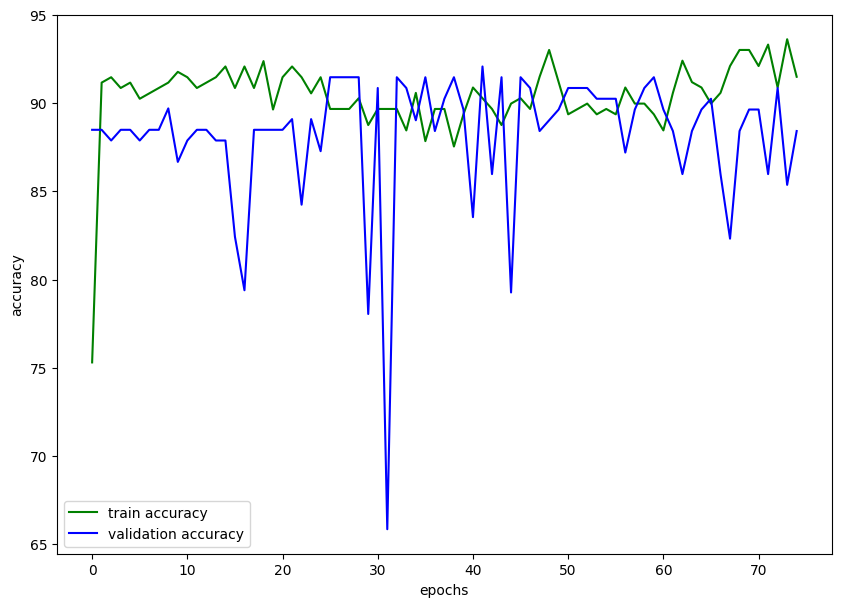

Test_Accuracy : 93.15789473684211
Confusion Matrix on the test set
[[173   5]
 [  8   4]]
porcupine
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0175 Acc: 88.1098%
[Test #1] Loss: 0.0125 Acc: 92.1212% 
Epoch 1 running
[Train #2] Loss: 0.0162 Acc: 89.3293%
[Test #2] Loss: 0.0121 Acc: 92.1212% 
Epoch 2 running
[Train #3] Loss: 0.0156 Acc: 88.7195%
[Test #3] Loss: 0.0106 Acc: 92.1212% 
Epoch 3 running
[Train #4] Loss: 0.0128 Acc: 89.0244%
[Test #4] Loss: 0.0105 Acc: 92.1212% 
Epoch 4 running
[Train #5] Loss: 0.0115 Acc: 90.5488%
[Test #5] Loss: 0.0142 Acc: 92.1212% 
Epoch 5 running
[Train #6] Loss: 0.0114 Acc: 90.2439%
[Test #6] Loss: 0.0193 Acc: 86.6667% 
Epoch 6 running
[Train #7] Loss: 0.0083 Acc: 92.3780%
[Test #7] Loss: 0.0196 Acc: 84.2424% 
Epoch 7 running
[Train #8] Loss: 0.0107 Acc: 90.8537%
[Test #8] Loss: 0.0095 Acc: 93.3333% 
Epoch 8 running
[Train #9] Loss: 0.0087 Acc: 93.2927%
[Test #9] Loss: 0.0303 Acc: 72.7273% 
Epoch 9 running
[Train #10] Loss: 0.0096 Acc: 92.6829%
[Test #

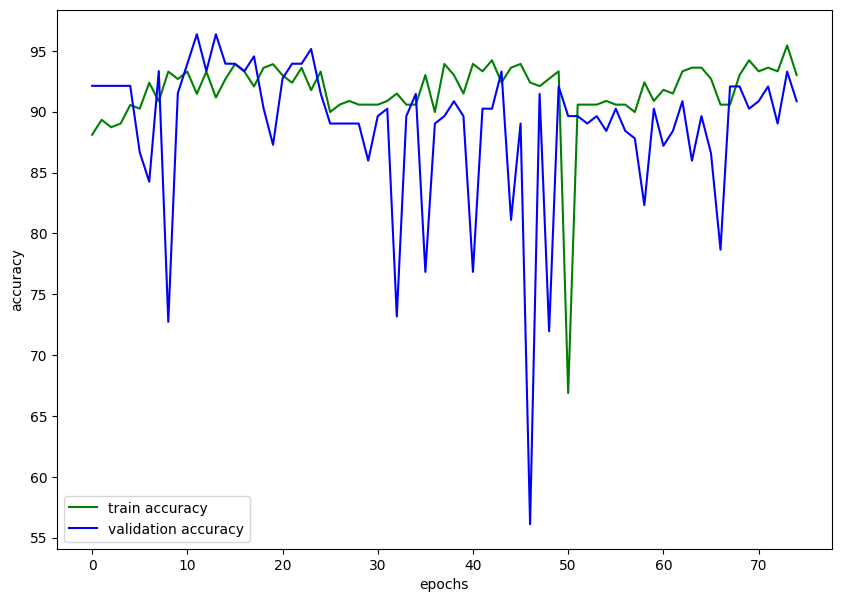

Test_Accuracy : 93.15789473684211
Confusion Matrix on the test set
[[175   3]
 [ 10   2]]
possum
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0186 Acc: 82.9268%
[Test #1] Loss: 0.0157 Acc: 87.8788% 
Epoch 1 running
[Train #2] Loss: 0.0127 Acc: 91.4634%
[Test #2] Loss: 0.0157 Acc: 87.8788% 
Epoch 2 running
[Train #3] Loss: 0.0127 Acc: 91.4634%
[Test #3] Loss: 0.0179 Acc: 87.8788% 
Epoch 3 running
[Train #4] Loss: 0.0151 Acc: 90.5488%
[Test #4] Loss: 0.0192 Acc: 87.8788% 
Epoch 4 running
[Train #5] Loss: 0.0126 Acc: 91.4634%
[Test #5] Loss: 0.0150 Acc: 87.8788% 
Epoch 5 running
[Train #6] Loss: 0.0121 Acc: 91.4634%
[Test #6] Loss: 0.0157 Acc: 87.8788% 
Epoch 6 running
[Train #7] Loss: 0.0123 Acc: 91.4634%
[Test #7] Loss: 0.0170 Acc: 87.8788% 
Epoch 7 running
[Train #8] Loss: 0.0121 Acc: 91.1585%
[Test #8] Loss: 0.0209 Acc: 75.7576% 
Epoch 8 running
[Train #9] Loss: 0.0123 Acc: 91.4634%
[Test #9] Loss: 0.0162 Acc: 87.8788% 
Epoch 9 running
[Train #10] Loss: 0.0112 Acc: 91.4634%
[Test #10]

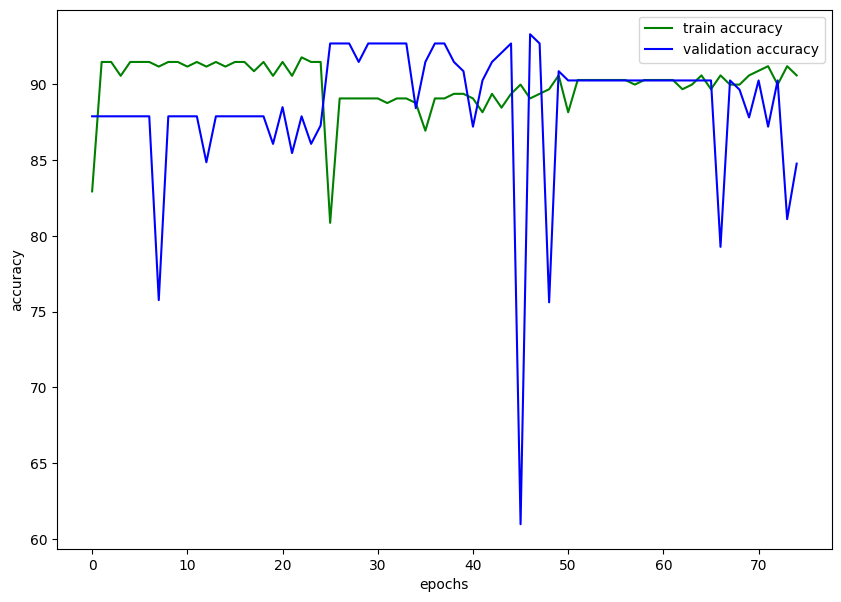

Test_Accuracy : 90.0
Confusion Matrix on the test set
[[169   9]
 [ 10   2]]
raccoon
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0275 Acc: 66.7683%
[Test #1] Loss: 0.0186 Acc: 86.6667% 
Epoch 1 running
[Train #2] Loss: 0.0119 Acc: 92.0732%
[Test #2] Loss: 0.0172 Acc: 86.6667% 
Epoch 2 running
[Train #3] Loss: 0.0112 Acc: 92.0732%
[Test #3] Loss: 0.0160 Acc: 86.6667% 
Epoch 3 running
[Train #4] Loss: 0.0112 Acc: 92.0732%
[Test #4] Loss: 0.0178 Acc: 85.4545% 
Epoch 4 running
[Train #5] Loss: 0.0108 Acc: 91.1585%
[Test #5] Loss: 0.0155 Acc: 86.6667% 
Epoch 5 running
[Train #6] Loss: 0.0107 Acc: 92.0732%
[Test #6] Loss: 0.0174 Acc: 86.6667% 
Epoch 6 running
[Train #7] Loss: 0.0106 Acc: 92.0732%
[Test #7] Loss: 0.0154 Acc: 86.6667% 
Epoch 7 running
[Train #8] Loss: 0.0104 Acc: 91.7683%
[Test #8] Loss: 0.0159 Acc: 84.8485% 
Epoch 8 running
[Train #9] Loss: 0.0098 Acc: 92.0732%
[Test #9] Loss: 0.0138 Acc: 85.4545% 
Epoch 9 running
[Train #10] Loss: 0.0098 Acc: 91.1585%
[Test #10] Loss: 0.016

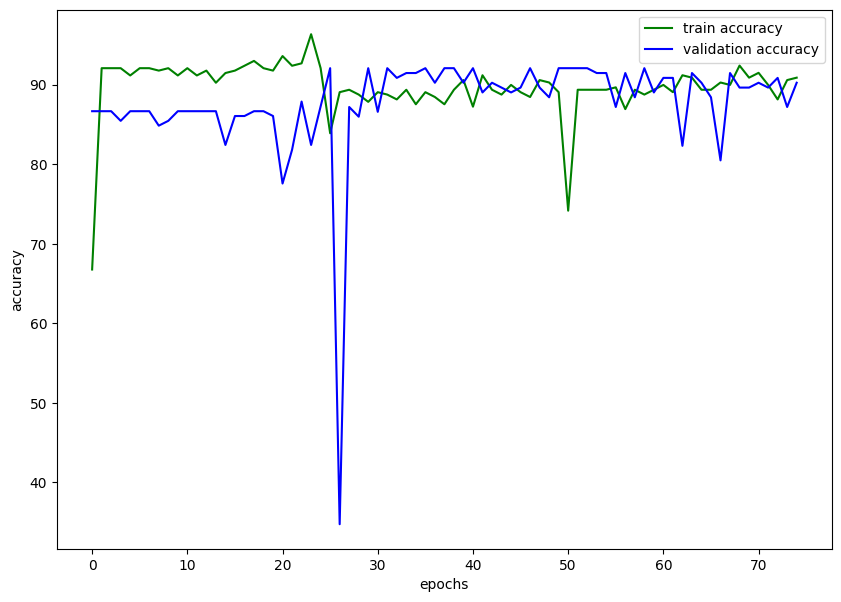

Test_Accuracy : 68.42105263157895
Confusion Matrix on the test set
[[126  52]
 [  8   4]]
rat
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0165 Acc: 84.4512%
[Test #1] Loss: 0.0224 Acc: 92.1212% 
Epoch 1 running
[Train #2] Loss: 0.0142 Acc: 89.0244%
[Test #2] Loss: 0.0130 Acc: 92.1212% 
Epoch 2 running
[Train #3] Loss: 0.0124 Acc: 88.4146%
[Test #3] Loss: 0.0145 Acc: 87.2727% 
Epoch 3 running
[Train #4] Loss: 0.0130 Acc: 89.0244%
[Test #4] Loss: 0.0125 Acc: 92.1212% 
Epoch 4 running
[Train #5] Loss: 0.0118 Acc: 88.1098%
[Test #5] Loss: 0.0128 Acc: 89.0909% 
Epoch 5 running
[Train #6] Loss: 0.0124 Acc: 89.3293%
[Test #6] Loss: 0.0114 Acc: 90.9091% 
Epoch 6 running
[Train #7] Loss: 0.0117 Acc: 89.9390%
[Test #7] Loss: 0.0120 Acc: 90.9091% 
Epoch 7 running
[Train #8] Loss: 0.0104 Acc: 89.3293%
[Test #8] Loss: 0.0110 Acc: 89.6970% 
Epoch 8 running
[Train #9] Loss: 0.0100 Acc: 89.9390%
[Test #9] Loss: 0.0104 Acc: 92.1212% 
Epoch 9 running
[Train #10] Loss: 0.0114 Acc: 87.8049%
[Test #10] Lo

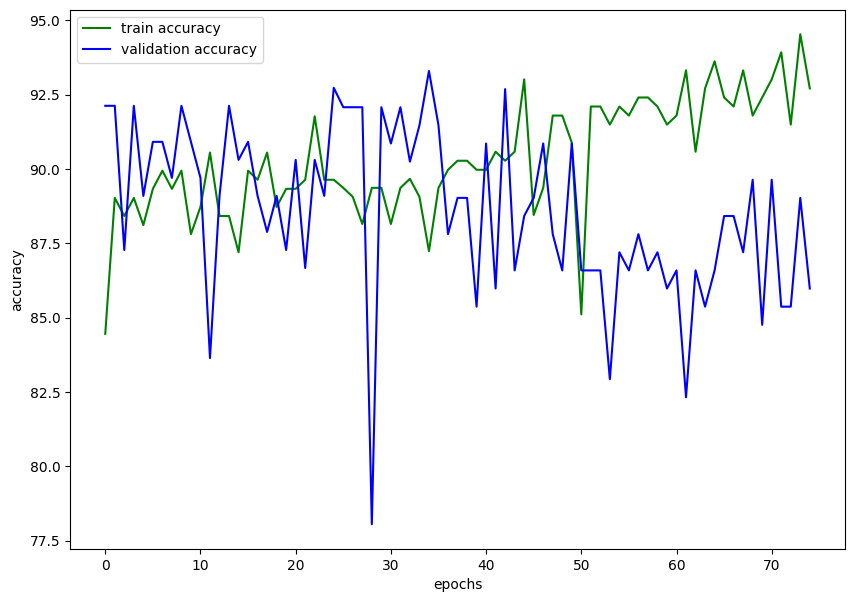

Test_Accuracy : 93.15789473684211
Confusion Matrix on the test set
[[177   1]
 [ 12   0]]
reindeer
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0159 Acc: 88.7195%
[Test #1] Loss: 0.0140 Acc: 89.6970% 
Epoch 1 running
[Train #2] Loss: 0.0141 Acc: 90.5488%
[Test #2] Loss: 0.0176 Acc: 89.6970% 
Epoch 2 running
[Train #3] Loss: 0.0119 Acc: 90.2439%
[Test #3] Loss: 0.0159 Acc: 89.0909% 
Epoch 3 running
[Train #4] Loss: 0.0139 Acc: 90.5488%
[Test #4] Loss: 0.0134 Acc: 89.6970% 
Epoch 4 running
[Train #5] Loss: 0.0121 Acc: 90.2439%
[Test #5] Loss: 0.0142 Acc: 89.6970% 
Epoch 5 running
[Train #6] Loss: 0.0128 Acc: 90.5488%
[Test #6] Loss: 0.0124 Acc: 88.4848% 
Epoch 6 running
[Train #7] Loss: 0.0119 Acc: 90.8537%
[Test #7] Loss: 0.0113 Acc: 88.4848% 
Epoch 7 running
[Train #8] Loss: 0.0116 Acc: 90.2439%
[Test #8] Loss: 0.0126 Acc: 89.6970% 
Epoch 8 running
[Train #9] Loss: 0.0116 Acc: 89.9390%
[Test #9] Loss: 0.0115 Acc: 90.3030% 
Epoch 9 running
[Train #10] Loss: 0.0116 Acc: 89.0244%
[Test #1

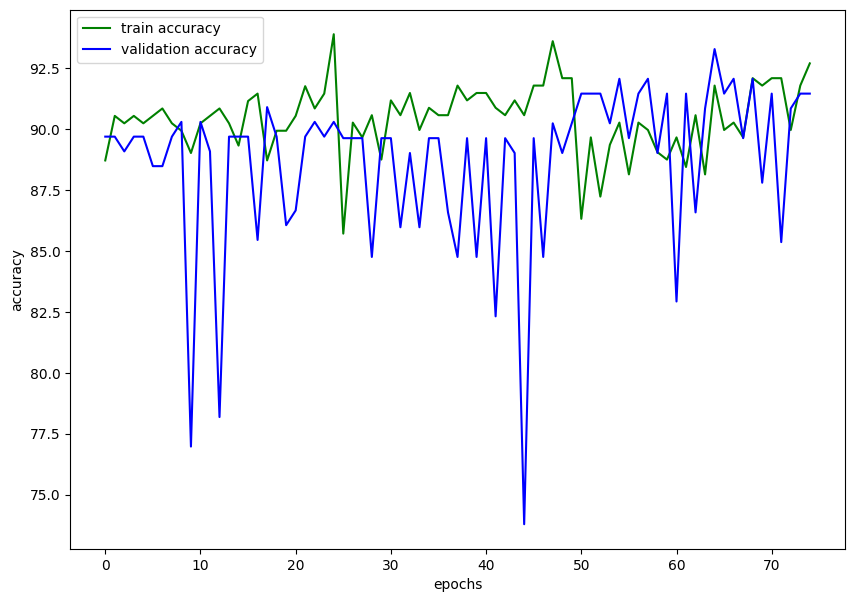

Test_Accuracy : 86.8421052631579
Confusion Matrix on the test set
[[159  19]
 [  6   6]]
rhinoceros
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0179 Acc: 81.7073%
[Test #1] Loss: 0.0167 Acc: 88.4848% 
Epoch 1 running
[Train #2] Loss: 0.0131 Acc: 91.1585%
[Test #2] Loss: 0.0151 Acc: 88.4848% 
Epoch 2 running
[Train #3] Loss: 0.0124 Acc: 91.7683%
[Test #3] Loss: 0.0151 Acc: 88.4848% 
Epoch 3 running
[Train #4] Loss: 0.0130 Acc: 90.5488%
[Test #4] Loss: 0.0217 Acc: 81.8182% 
Epoch 4 running
[Train #5] Loss: 0.0117 Acc: 90.8537%
[Test #5] Loss: 0.0148 Acc: 87.2727% 
Epoch 5 running
[Train #6] Loss: 0.0122 Acc: 91.1585%
[Test #6] Loss: 0.0178 Acc: 88.4848% 
Epoch 6 running
[Train #7] Loss: 0.0113 Acc: 91.4634%
[Test #7] Loss: 0.0167 Acc: 88.4848% 
Epoch 7 running
[Train #8] Loss: 0.0125 Acc: 89.6341%
[Test #8] Loss: 0.0152 Acc: 87.8788% 
Epoch 8 running
[Train #9] Loss: 0.0118 Acc: 91.1585%
[Test #9] Loss: 0.0160 Acc: 88.4848% 
Epoch 9 running
[Train #10] Loss: 0.0104 Acc: 91.1585%
[Test #

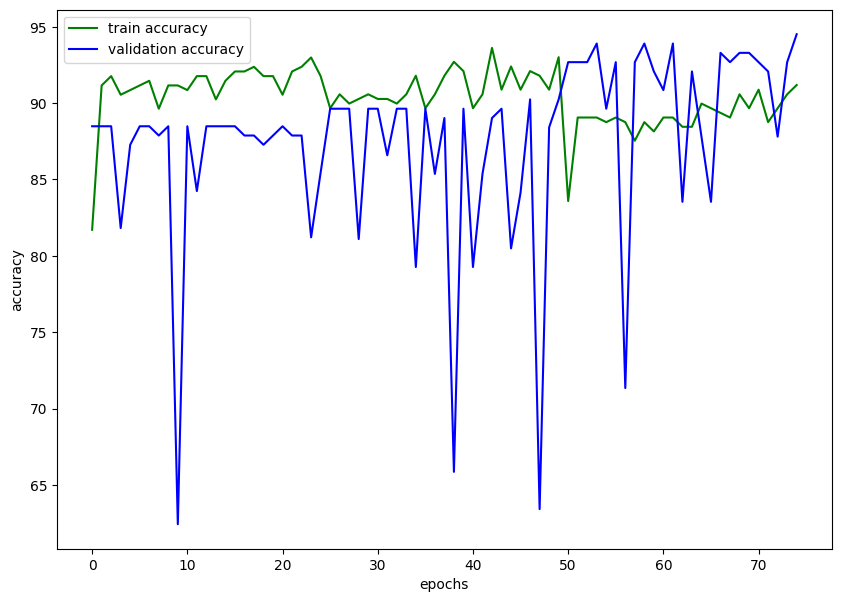

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[176   2]
 [ 10   2]]
sandpiper
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0109 Acc: 92.3780%
[Test #1] Loss: 0.0226 Acc: 86.0606% 
Epoch 1 running
[Train #2] Loss: 0.0080 Acc: 92.6829%
[Test #2] Loss: 0.0254 Acc: 67.2727% 
Epoch 2 running
[Train #3] Loss: 0.0104 Acc: 92.3780%
[Test #3] Loss: 0.0175 Acc: 84.2424% 
Epoch 3 running
[Train #4] Loss: 0.0082 Acc: 93.2927%
[Test #4] Loss: 0.0178 Acc: 88.4848% 
Epoch 4 running
[Train #5] Loss: 0.0075 Acc: 93.2927%
[Test #5] Loss: 0.0171 Acc: 84.2424% 
Epoch 5 running
[Train #6] Loss: 0.0086 Acc: 92.6829%
[Test #6] Loss: 0.0180 Acc: 86.6667% 
Epoch 6 running
[Train #7] Loss: 0.0074 Acc: 93.9024%
[Test #7] Loss: 0.0160 Acc: 87.8788% 
Epoch 7 running
[Train #8] Loss: 0.0070 Acc: 92.0732%
[Test #8] Loss: 0.0217 Acc: 87.2727% 
Epoch 8 running
[Train #9] Loss: 0.0068 Acc: 93.5976%
[Test #9] Loss: 0.0180 Acc: 88.4848% 
Epoch 9 running
[Train #10] Loss: 0.0075 Acc: 93.5976%
[Test #1

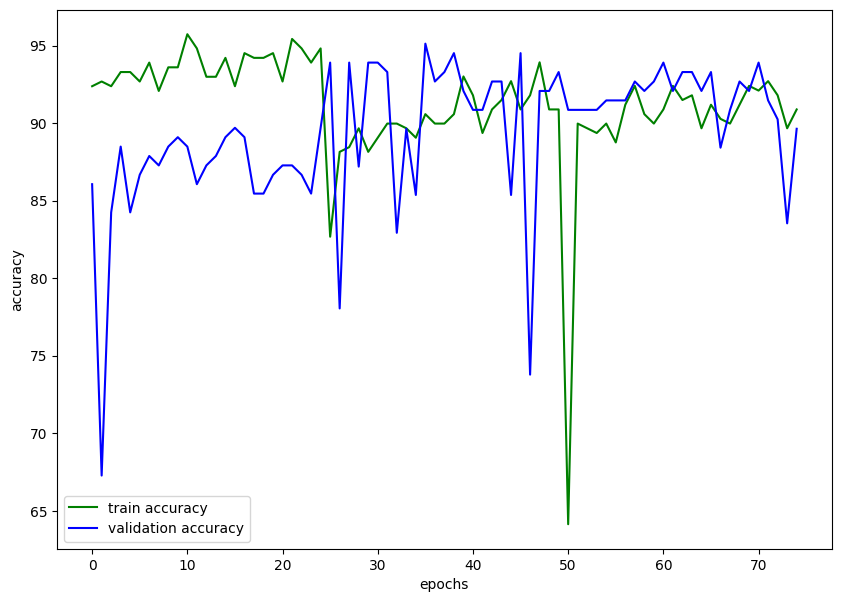

Test_Accuracy : 92.10526315789474
Confusion Matrix on the test set
[[168  10]
 [  5   7]]
seahorse
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0138 Acc: 90.8537%
[Test #1] Loss: 0.0157 Acc: 88.4848% 
Epoch 1 running
[Train #2] Loss: 0.0135 Acc: 89.0244%
[Test #2] Loss: 0.0251 Acc: 88.4848% 
Epoch 2 running
[Train #3] Loss: 0.0121 Acc: 91.1585%
[Test #3] Loss: 0.0230 Acc: 88.4848% 
Epoch 3 running
[Train #4] Loss: 0.0116 Acc: 91.1585%
[Test #4] Loss: 0.0192 Acc: 89.0909% 
Epoch 4 running
[Train #5] Loss: 0.0106 Acc: 91.7683%
[Test #5] Loss: 0.0185 Acc: 88.4848% 
Epoch 5 running
[Train #6] Loss: 0.0120 Acc: 91.1585%
[Test #6] Loss: 0.0147 Acc: 88.4848% 
Epoch 6 running
[Train #7] Loss: 0.0111 Acc: 91.1585%
[Test #7] Loss: 0.0150 Acc: 87.8788% 
Epoch 7 running
[Train #8] Loss: 0.0108 Acc: 90.8537%
[Test #8] Loss: 0.0147 Acc: 87.2727% 
Epoch 8 running
[Train #9] Loss: 0.0096 Acc: 91.1585%
[Test #9] Loss: 0.0182 Acc: 87.8788% 
Epoch 9 running
[Train #10] Loss: 0.0106 Acc: 91.7683%
[Test #1

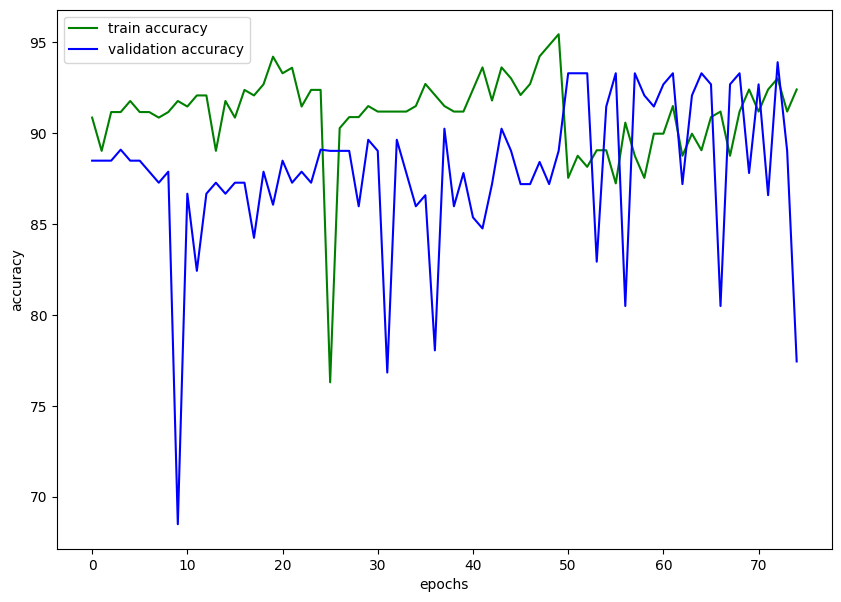

Test_Accuracy : 57.36842105263158
Confusion Matrix on the test set
[[101  77]
 [  4   8]]
seal
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0137 Acc: 90.8537%
[Test #1] Loss: 0.0261 Acc: 89.0909% 
Epoch 1 running
[Train #2] Loss: 0.0140 Acc: 90.8537%
[Test #2] Loss: 0.0144 Acc: 89.0909% 
Epoch 2 running
[Train #3] Loss: 0.0116 Acc: 91.1585%
[Test #3] Loss: 0.0137 Acc: 89.0909% 
Epoch 3 running
[Train #4] Loss: 0.0103 Acc: 90.8537%
[Test #4] Loss: 0.0143 Acc: 86.6667% 
Epoch 4 running
[Train #5] Loss: 0.0105 Acc: 90.8537%
[Test #5] Loss: 0.0166 Acc: 89.0909% 
Epoch 5 running
[Train #6] Loss: 0.0123 Acc: 90.5488%
[Test #6] Loss: 0.0132 Acc: 89.0909% 
Epoch 6 running
[Train #7] Loss: 0.0102 Acc: 90.5488%
[Test #7] Loss: 0.0138 Acc: 85.4545% 
Epoch 7 running
[Train #8] Loss: 0.0101 Acc: 90.8537%
[Test #8] Loss: 0.0149 Acc: 89.0909% 
Epoch 8 running
[Train #9] Loss: 0.0098 Acc: 90.8537%
[Test #9] Loss: 0.0150 Acc: 87.8788% 
Epoch 9 running
[Train #10] Loss: 0.0092 Acc: 89.6341%
[Test #10] L

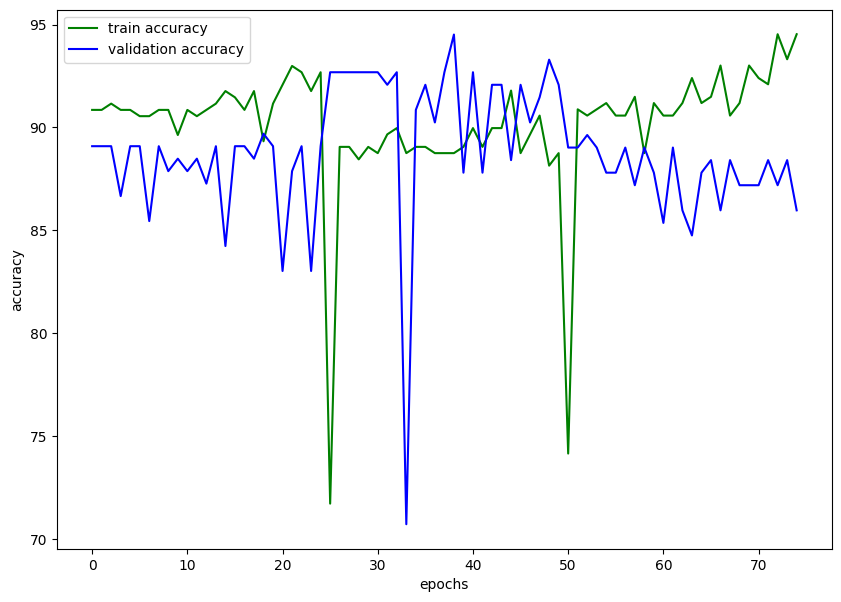

Test_Accuracy : 90.52631578947368
Confusion Matrix on the test set
[[168  10]
 [  8   4]]
shark
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0144 Acc: 89.6341%
[Test #1] Loss: 0.0132 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0114 Acc: 91.7683%
[Test #2] Loss: 0.0121 Acc: 90.9091% 
Epoch 2 running
[Train #3] Loss: 0.0108 Acc: 91.4634%
[Test #3] Loss: 0.0059 Acc: 96.3636% 
Epoch 3 running
[Train #4] Loss: 0.0075 Acc: 93.9024%
[Test #4] Loss: 0.0116 Acc: 87.2727% 
Epoch 4 running
[Train #5] Loss: 0.0069 Acc: 92.9878%
[Test #5] Loss: 0.0070 Acc: 93.9394% 
Epoch 5 running
[Train #6] Loss: 0.0080 Acc: 93.2927%
[Test #6] Loss: 0.0270 Acc: 82.4242% 
Epoch 6 running
[Train #7] Loss: 0.0065 Acc: 93.2927%
[Test #7] Loss: 0.0099 Acc: 93.3333% 
Epoch 7 running
[Train #8] Loss: 0.0064 Acc: 95.7317%
[Test #8] Loss: 0.0063 Acc: 96.9697% 
Epoch 8 running
[Train #9] Loss: 0.0070 Acc: 94.8171%
[Test #9] Loss: 0.0073 Acc: 93.9394% 
Epoch 9 running
[Train #10] Loss: 0.0072 Acc: 94.2073%
[Test #10] 

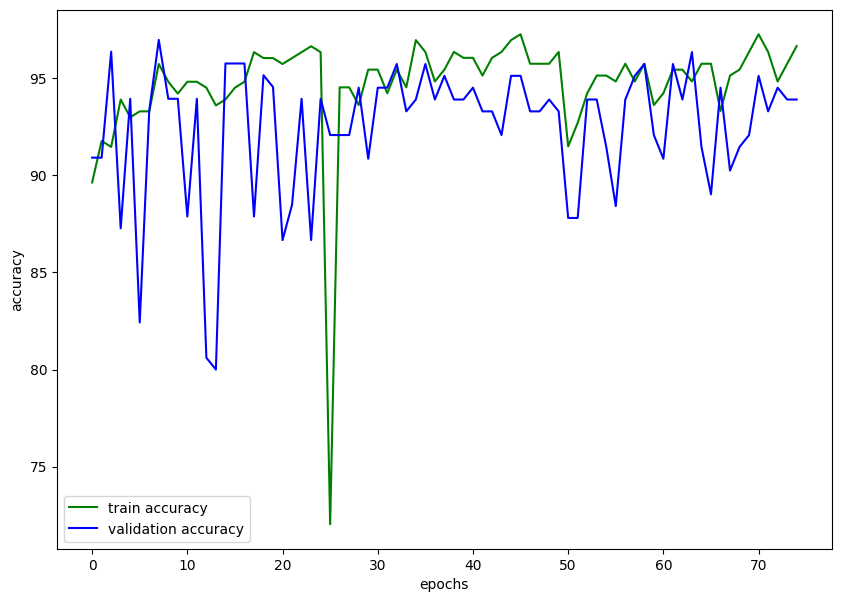

Test_Accuracy : 97.36842105263158
Confusion Matrix on the test set
[[176   2]
 [  3   9]]
sheep
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0159 Acc: 87.5000%
[Test #1] Loss: 0.0155 Acc: 87.8788% 
Epoch 1 running
[Train #2] Loss: 0.0120 Acc: 91.1585%
[Test #2] Loss: 0.0163 Acc: 87.8788% 
Epoch 2 running
[Train #3] Loss: 0.0114 Acc: 91.7683%
[Test #3] Loss: 0.0151 Acc: 86.6667% 
Epoch 3 running
[Train #4] Loss: 0.0108 Acc: 91.4634%
[Test #4] Loss: 0.0135 Acc: 87.8788% 
Epoch 4 running
[Train #5] Loss: 0.0104 Acc: 91.7683%
[Test #5] Loss: 0.0154 Acc: 87.2727% 
Epoch 5 running
[Train #6] Loss: 0.0094 Acc: 91.1585%
[Test #6] Loss: 0.0168 Acc: 87.8788% 
Epoch 6 running
[Train #7] Loss: 0.0095 Acc: 92.3780%
[Test #7] Loss: 0.0259 Acc: 85.4545% 
Epoch 7 running
[Train #8] Loss: 0.0101 Acc: 91.4634%
[Test #8] Loss: 0.0131 Acc: 90.9091% 
Epoch 8 running
[Train #9] Loss: 0.0095 Acc: 89.9390%
[Test #9] Loss: 0.0142 Acc: 89.0909% 
Epoch 9 running
[Train #10] Loss: 0.0092 Acc: 91.7683%
[Test #10] 

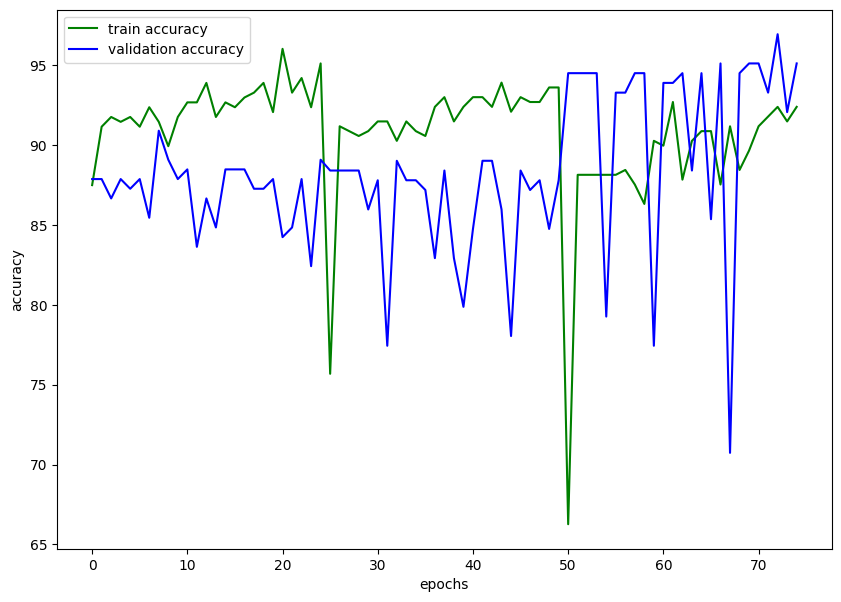

Test_Accuracy : 94.73684210526315
Confusion Matrix on the test set
[[177   1]
 [  9   3]]
snake
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0172 Acc: 86.8902%
[Test #1] Loss: 0.0138 Acc: 92.7273% 
Epoch 1 running
[Train #2] Loss: 0.0161 Acc: 89.0244%
[Test #2] Loss: 0.0112 Acc: 92.7273% 
Epoch 2 running
[Train #3] Loss: 0.0149 Acc: 88.7195%
[Test #3] Loss: 0.0140 Acc: 92.1212% 
Epoch 3 running
[Train #4] Loss: 0.0140 Acc: 88.7195%
[Test #4] Loss: 0.0118 Acc: 91.5152% 
Epoch 4 running
[Train #5] Loss: 0.0144 Acc: 89.0244%
[Test #5] Loss: 0.0102 Acc: 92.1212% 
Epoch 5 running
[Train #6] Loss: 0.0131 Acc: 89.0244%
[Test #6] Loss: 0.0117 Acc: 90.9091% 
Epoch 6 running
[Train #7] Loss: 0.0132 Acc: 88.7195%
[Test #7] Loss: 0.0129 Acc: 89.0909% 
Epoch 7 running
[Train #8] Loss: 0.0127 Acc: 89.3293%
[Test #8] Loss: 0.0135 Acc: 90.9091% 
Epoch 8 running
[Train #9] Loss: 0.0133 Acc: 89.9390%
[Test #9] Loss: 0.0125 Acc: 89.0909% 
Epoch 9 running
[Train #10] Loss: 0.0133 Acc: 90.5488%
[Test #10] 

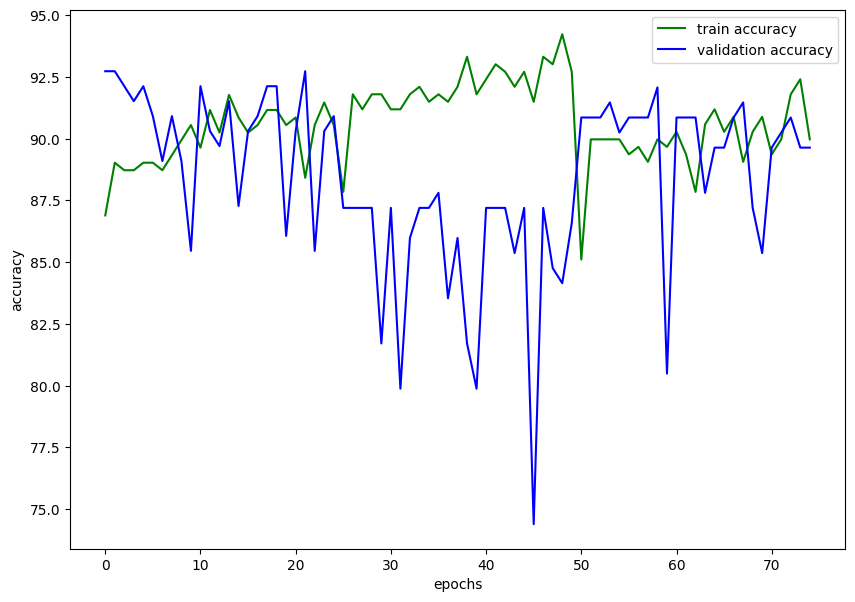

Test_Accuracy : 93.15789473684211
Confusion Matrix on the test set
[[176   2]
 [ 11   1]]
sparrow
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0180 Acc: 80.7927%
[Test #1] Loss: 0.0160 Acc: 89.0909% 
Epoch 1 running
[Train #2] Loss: 0.0135 Acc: 90.8537%
[Test #2] Loss: 0.0143 Acc: 89.0909% 
Epoch 2 running
[Train #3] Loss: 0.0116 Acc: 90.8537%
[Test #3] Loss: 0.0136 Acc: 89.6970% 
Epoch 3 running
[Train #4] Loss: 0.0100 Acc: 92.0732%
[Test #4] Loss: 0.0123 Acc: 92.7273% 
Epoch 4 running
[Train #5] Loss: 0.0116 Acc: 90.8537%
[Test #5] Loss: 0.0149 Acc: 89.6970% 
Epoch 5 running
[Train #6] Loss: 0.0121 Acc: 91.1585%
[Test #6] Loss: 0.0131 Acc: 89.0909% 
Epoch 6 running
[Train #7] Loss: 0.0099 Acc: 92.0732%
[Test #7] Loss: 0.0131 Acc: 90.3030% 
Epoch 7 running
[Train #8] Loss: 0.0107 Acc: 91.7683%
[Test #8] Loss: 0.0139 Acc: 89.0909% 
Epoch 8 running
[Train #9] Loss: 0.0106 Acc: 89.6341%
[Test #9] Loss: 0.0129 Acc: 89.6970% 
Epoch 9 running
[Train #10] Loss: 0.0101 Acc: 92.6829%
[Test #10

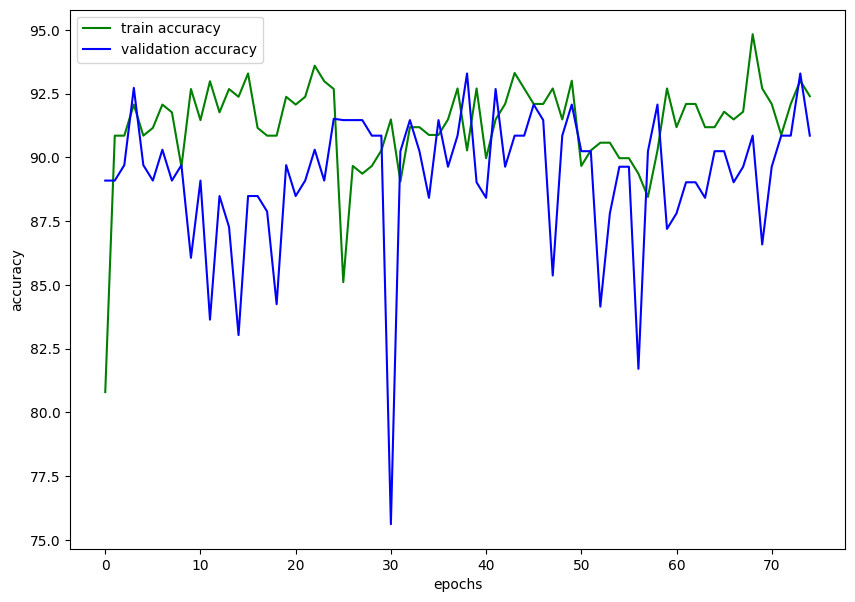

Test_Accuracy : 93.15789473684211
Confusion Matrix on the test set
[[175   3]
 [ 10   2]]
squid
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0163 Acc: 87.8049%
[Test #1] Loss: 0.0129 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0151 Acc: 89.6341%
[Test #2] Loss: 0.0140 Acc: 90.9091% 
Epoch 2 running
[Train #3] Loss: 0.0120 Acc: 89.6341%
[Test #3] Loss: 0.0114 Acc: 90.9091% 
Epoch 3 running
[Train #4] Loss: 0.0109 Acc: 90.5488%
[Test #4] Loss: 0.0201 Acc: 79.3939% 
Epoch 4 running
[Train #5] Loss: 0.0129 Acc: 90.2439%
[Test #5] Loss: 0.0594 Acc: 66.6667% 
Epoch 5 running
[Train #6] Loss: 0.0129 Acc: 87.1951%
[Test #6] Loss: 0.0144 Acc: 90.9091% 
Epoch 6 running
[Train #7] Loss: 0.0126 Acc: 91.7683%
[Test #7] Loss: 0.0111 Acc: 91.5152% 
Epoch 7 running
[Train #8] Loss: 0.0106 Acc: 90.5488%
[Test #8] Loss: 0.0140 Acc: 85.4545% 
Epoch 8 running
[Train #9] Loss: 0.0096 Acc: 91.4634%
[Test #9] Loss: 0.0173 Acc: 83.0303% 
Epoch 9 running
[Train #10] Loss: 0.0099 Acc: 90.8537%
[Test #10] 

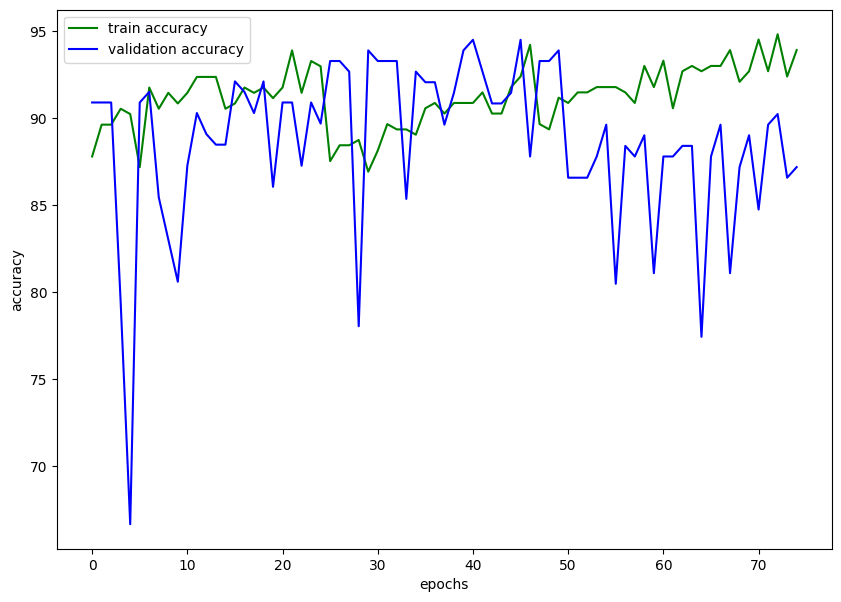

Test_Accuracy : 93.15789473684211
Confusion Matrix on the test set
[[169   9]
 [  4   8]]
squirrel
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0144 Acc: 89.3293%
[Test #1] Loss: 0.0169 Acc: 92.1212% 
Epoch 1 running
[Train #2] Loss: 0.0140 Acc: 89.6341%
[Test #2] Loss: 0.0142 Acc: 92.1212% 
Epoch 2 running
[Train #3] Loss: 0.0131 Acc: 89.3293%
[Test #3] Loss: 0.0207 Acc: 73.9394% 
Epoch 3 running
[Train #4] Loss: 0.0120 Acc: 89.6341%
[Test #4] Loss: 0.0106 Acc: 92.1212% 
Epoch 4 running
[Train #5] Loss: 0.0126 Acc: 89.0244%
[Test #5] Loss: 0.0122 Acc: 90.3030% 
Epoch 5 running
[Train #6] Loss: 0.0141 Acc: 88.7195%
[Test #6] Loss: 0.0105 Acc: 92.1212% 
Epoch 6 running
[Train #7] Loss: 0.0125 Acc: 89.3293%
[Test #7] Loss: 0.0102 Acc: 91.5152% 
Epoch 7 running
[Train #8] Loss: 0.0135 Acc: 88.7195%
[Test #8] Loss: 0.0114 Acc: 89.6970% 
Epoch 8 running
[Train #9] Loss: 0.0135 Acc: 88.7195%
[Test #9] Loss: 0.0115 Acc: 92.1212% 
Epoch 9 running
[Train #10] Loss: 0.0122 Acc: 89.3293%
[Test #1

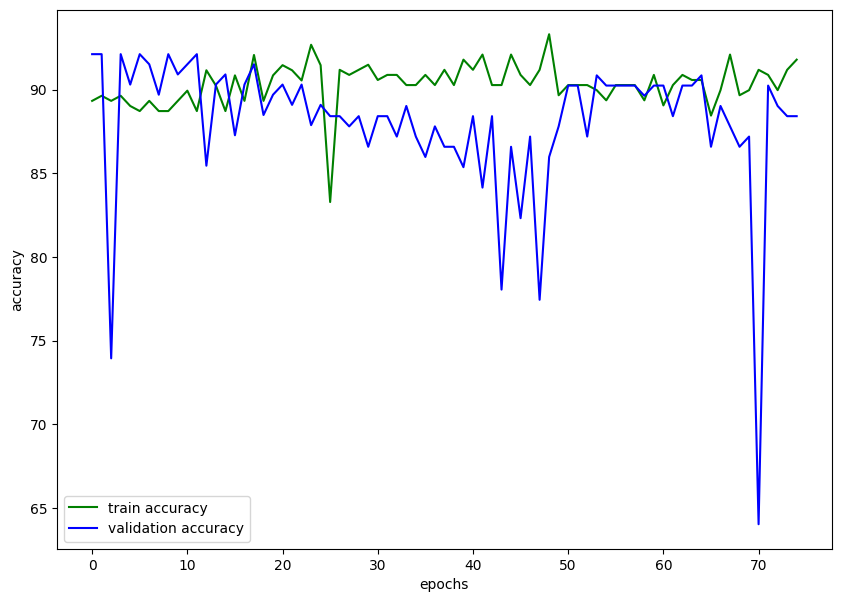

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[176   2]
 [ 10   2]]
starfish
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0161 Acc: 89.0244%
[Test #1] Loss: 0.0132 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0149 Acc: 89.9390%
[Test #2] Loss: 0.0132 Acc: 90.9091% 
Epoch 2 running
[Train #3] Loss: 0.0151 Acc: 88.7195%
[Test #3] Loss: 0.0124 Acc: 90.9091% 
Epoch 3 running
[Train #4] Loss: 0.0134 Acc: 89.6341%
[Test #4] Loss: 0.0169 Acc: 90.9091% 
Epoch 4 running
[Train #5] Loss: 0.0145 Acc: 89.6341%
[Test #5] Loss: 0.0212 Acc: 81.2121% 
Epoch 5 running
[Train #6] Loss: 0.0135 Acc: 89.9390%
[Test #6] Loss: 0.0162 Acc: 92.1212% 
Epoch 6 running
[Train #7] Loss: 0.0144 Acc: 89.6341%
[Test #7] Loss: 0.0164 Acc: 82.4242% 
Epoch 7 running
[Train #8] Loss: 0.0137 Acc: 89.3293%
[Test #8] Loss: 0.0111 Acc: 90.9091% 
Epoch 8 running
[Train #9] Loss: 0.0115 Acc: 89.6341%
[Test #9] Loss: 0.0096 Acc: 92.7273% 
Epoch 9 running
[Train #10] Loss: 0.0126 Acc: 89.3293%
[Test #10

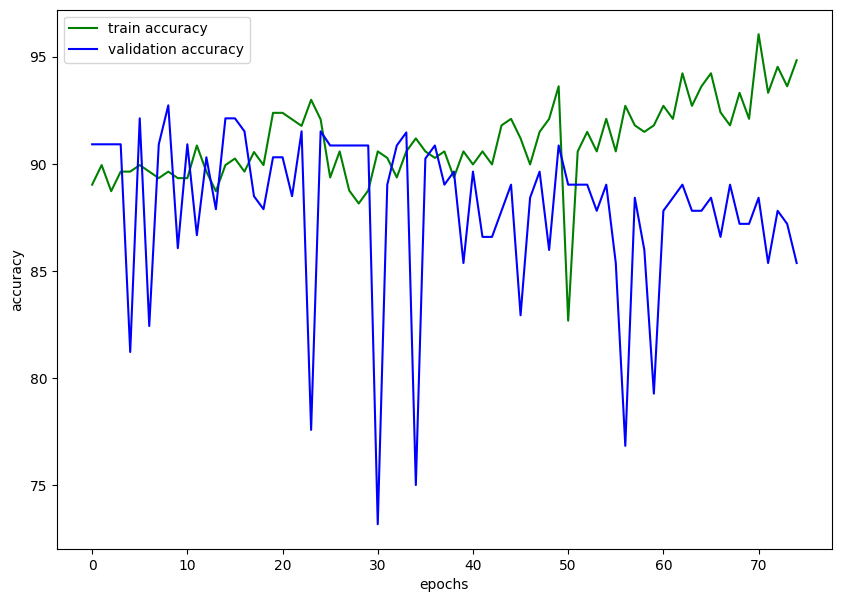

Test_Accuracy : 85.78947368421052
Confusion Matrix on the test set
[[156  22]
 [  5   7]]
swan
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0188 Acc: 88.7195%
[Test #1] Loss: 0.0137 Acc: 90.3030% 
Epoch 1 running
[Train #2] Loss: 0.0144 Acc: 90.2439%
[Test #2] Loss: 0.0167 Acc: 90.3030% 
Epoch 2 running
[Train #3] Loss: 0.0129 Acc: 89.6341%
[Test #3] Loss: 0.0147 Acc: 90.3030% 
Epoch 3 running
[Train #4] Loss: 0.0132 Acc: 90.2439%
[Test #4] Loss: 0.0131 Acc: 90.9091% 
Epoch 4 running
[Train #5] Loss: 0.0126 Acc: 89.6341%
[Test #5] Loss: 0.0260 Acc: 84.2424% 
Epoch 5 running
[Train #6] Loss: 0.0127 Acc: 89.6341%
[Test #6] Loss: 0.0267 Acc: 62.4242% 
Epoch 6 running
[Train #7] Loss: 0.0128 Acc: 89.9390%
[Test #7] Loss: 0.0214 Acc: 83.0303% 
Epoch 7 running
[Train #8] Loss: 0.0117 Acc: 90.2439%
[Test #8] Loss: 0.0197 Acc: 84.2424% 
Epoch 8 running
[Train #9] Loss: 0.0103 Acc: 91.4634%
[Test #9] Loss: 0.0132 Acc: 90.3030% 
Epoch 9 running
[Train #10] Loss: 0.0103 Acc: 90.2439%
[Test #10] L

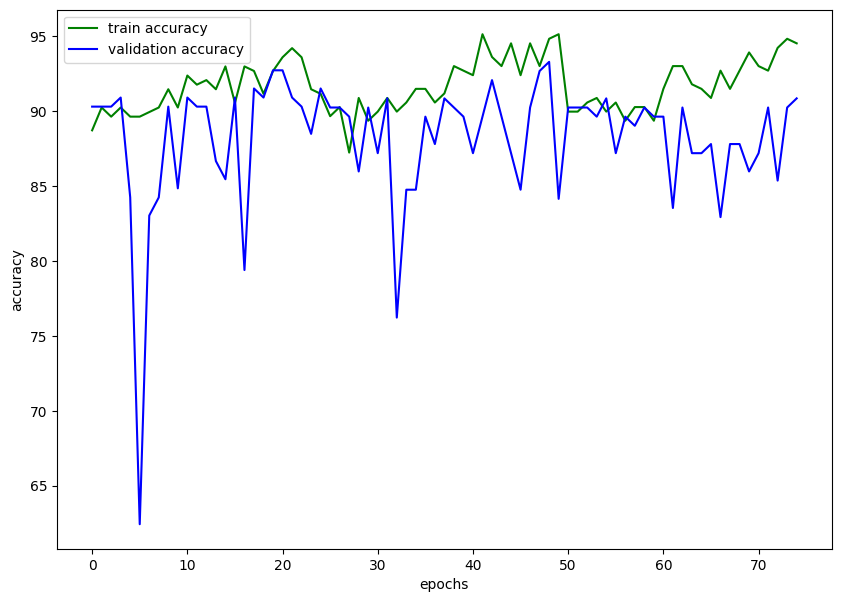

Test_Accuracy : 95.26315789473684
Confusion Matrix on the test set
[[178   0]
 [  9   3]]
tiger
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0157 Acc: 89.3293%
[Test #1] Loss: 0.0146 Acc: 89.0909% 
Epoch 1 running
[Train #2] Loss: 0.0124 Acc: 89.6341%
[Test #2] Loss: 0.0214 Acc: 89.0909% 
Epoch 2 running
[Train #3] Loss: 0.0127 Acc: 90.2439%
[Test #3] Loss: 0.0178 Acc: 89.0909% 
Epoch 3 running
[Train #4] Loss: 0.0125 Acc: 90.5488%
[Test #4] Loss: 0.0166 Acc: 89.0909% 
Epoch 4 running
[Train #5] Loss: 0.0122 Acc: 90.2439%
[Test #5] Loss: 0.0133 Acc: 89.0909% 
Epoch 5 running
[Train #6] Loss: 0.0108 Acc: 90.8537%
[Test #6] Loss: 0.0271 Acc: 76.3636% 
Epoch 6 running
[Train #7] Loss: 0.0127 Acc: 91.4634%
[Test #7] Loss: 0.0144 Acc: 89.0909% 
Epoch 7 running
[Train #8] Loss: 0.0104 Acc: 92.0732%
[Test #8] Loss: 0.0163 Acc: 87.8788% 
Epoch 8 running
[Train #9] Loss: 0.0099 Acc: 91.7683%
[Test #9] Loss: 0.0164 Acc: 83.6364% 
Epoch 9 running
[Train #10] Loss: 0.0100 Acc: 89.6341%
[Test #10] 

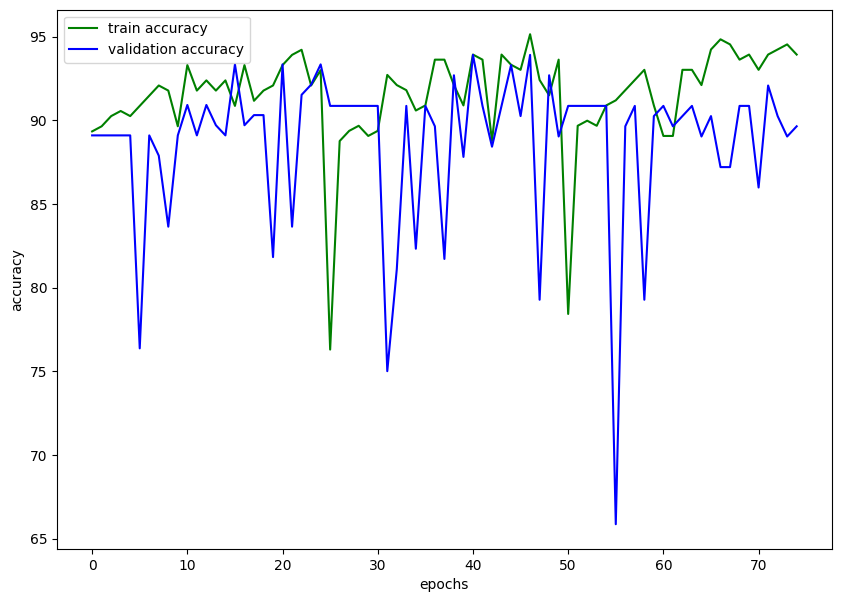

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[176   2]
 [ 10   2]]
turkey
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0181 Acc: 84.4512%
[Test #1] Loss: 0.0131 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0174 Acc: 89.3293%
[Test #2] Loss: 0.0132 Acc: 90.9091% 
Epoch 2 running
[Train #3] Loss: 0.0135 Acc: 89.9390%
[Test #3] Loss: 0.0160 Acc: 90.9091% 
Epoch 3 running
[Train #4] Loss: 0.0133 Acc: 89.6341%
[Test #4] Loss: 0.0124 Acc: 90.3030% 
Epoch 4 running
[Train #5] Loss: 0.0137 Acc: 89.6341%
[Test #5] Loss: 0.0129 Acc: 90.9091% 
Epoch 5 running
[Train #6] Loss: 0.0122 Acc: 89.9390%
[Test #6] Loss: 0.0324 Acc: 61.2121% 
Epoch 6 running
[Train #7] Loss: 0.0144 Acc: 90.5488%
[Test #7] Loss: 0.0162 Acc: 90.9091% 
Epoch 7 running
[Train #8] Loss: 0.0121 Acc: 89.6341%
[Test #8] Loss: 0.0152 Acc: 83.0303% 
Epoch 8 running
[Train #9] Loss: 0.0114 Acc: 90.2439%
[Test #9] Loss: 0.0119 Acc: 89.0909% 
Epoch 9 running
[Train #10] Loss: 0.0106 Acc: 90.8537%
[Test #10] 

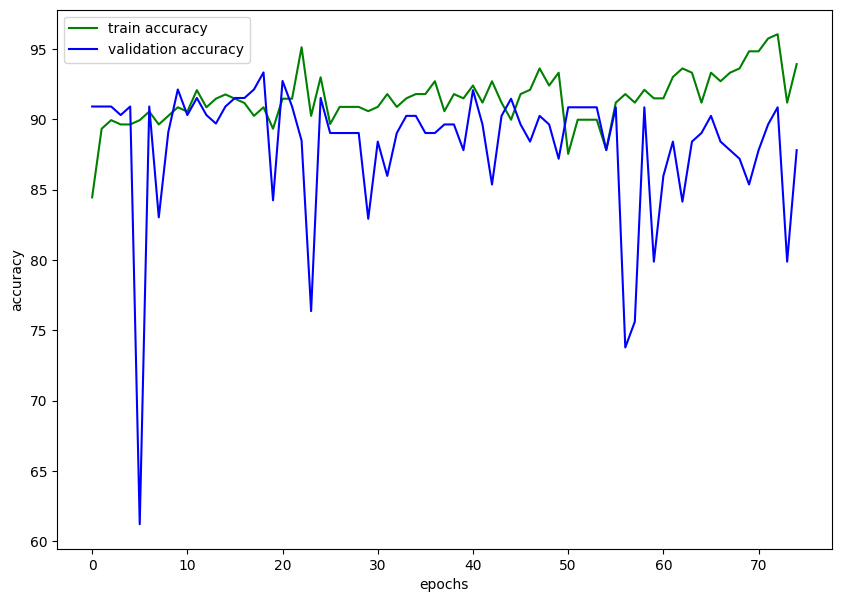

Test_Accuracy : 88.94736842105263
Confusion Matrix on the test set
[[162  16]
 [  5   7]]
turtle
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0243 Acc: 68.5976%
[Test #1] Loss: 0.0131 Acc: 92.7273% 
Epoch 1 running
[Train #2] Loss: 0.0157 Acc: 89.0244%
[Test #2] Loss: 0.0173 Acc: 92.7273% 
Epoch 2 running
[Train #3] Loss: 0.0132 Acc: 88.4146%
[Test #3] Loss: 0.0119 Acc: 92.7273% 
Epoch 3 running
[Train #4] Loss: 0.0115 Acc: 89.6341%
[Test #4] Loss: 0.0086 Acc: 92.1212% 
Epoch 4 running
[Train #5] Loss: 0.0125 Acc: 89.3293%
[Test #5] Loss: 0.0096 Acc: 92.7273% 
Epoch 5 running
[Train #6] Loss: 0.0132 Acc: 88.7195%
[Test #6] Loss: 0.0094 Acc: 93.3333% 
Epoch 6 running
[Train #7] Loss: 0.0119 Acc: 90.5488%
[Test #7] Loss: 0.0100 Acc: 93.3333% 
Epoch 7 running
[Train #8] Loss: 0.0095 Acc: 91.4634%
[Test #8] Loss: 0.0121 Acc: 95.7576% 
Epoch 8 running
[Train #9] Loss: 0.0094 Acc: 92.0732%
[Test #9] Loss: 0.0607 Acc: 69.6970% 
Epoch 9 running
[Train #10] Loss: 0.0124 Acc: 88.4146%
[Test #10]

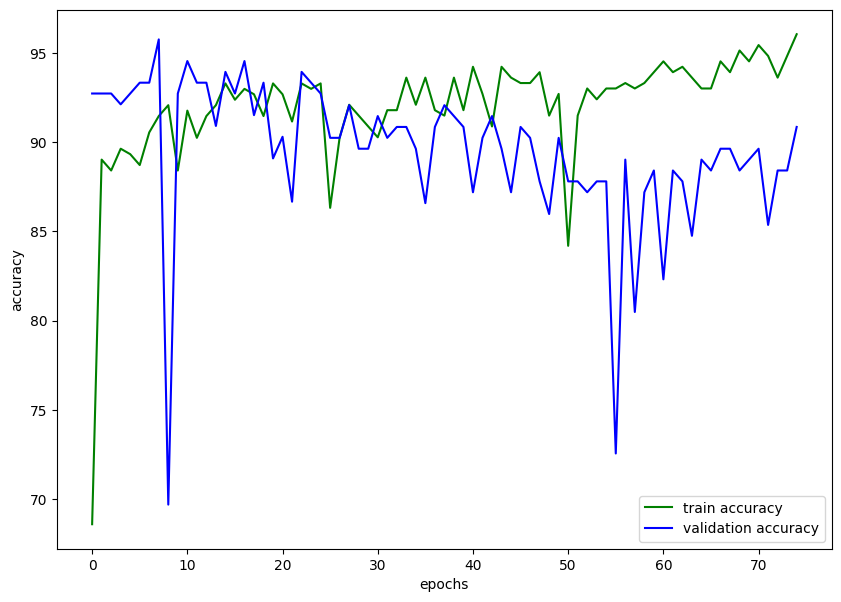

Test_Accuracy : 94.73684210526315
Confusion Matrix on the test set
[[173   5]
 [  5   7]]
whale
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0162 Acc: 87.8049%
[Test #1] Loss: 0.0131 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0085 Acc: 92.3780%
[Test #2] Loss: 0.0179 Acc: 90.9091% 
Epoch 2 running
[Train #3] Loss: 0.0076 Acc: 92.9878%
[Test #3] Loss: 0.0107 Acc: 92.7273% 
Epoch 3 running
[Train #4] Loss: 0.0081 Acc: 93.2927%
[Test #4] Loss: 0.0112 Acc: 90.9091% 
Epoch 4 running
[Train #5] Loss: 0.0091 Acc: 92.0732%
[Test #5] Loss: 0.0086 Acc: 90.9091% 
Epoch 5 running
[Train #6] Loss: 0.0079 Acc: 92.9878%
[Test #6] Loss: 0.0081 Acc: 91.5152% 
Epoch 6 running
[Train #7] Loss: 0.0088 Acc: 91.4634%
[Test #7] Loss: 0.0058 Acc: 93.9394% 
Epoch 7 running
[Train #8] Loss: 0.0076 Acc: 92.6829%
[Test #8] Loss: 0.0072 Acc: 93.9394% 
Epoch 8 running
[Train #9] Loss: 0.0070 Acc: 93.5976%
[Test #9] Loss: 0.0109 Acc: 88.4848% 
Epoch 9 running
[Train #10] Loss: 0.0075 Acc: 92.0732%
[Test #10] 

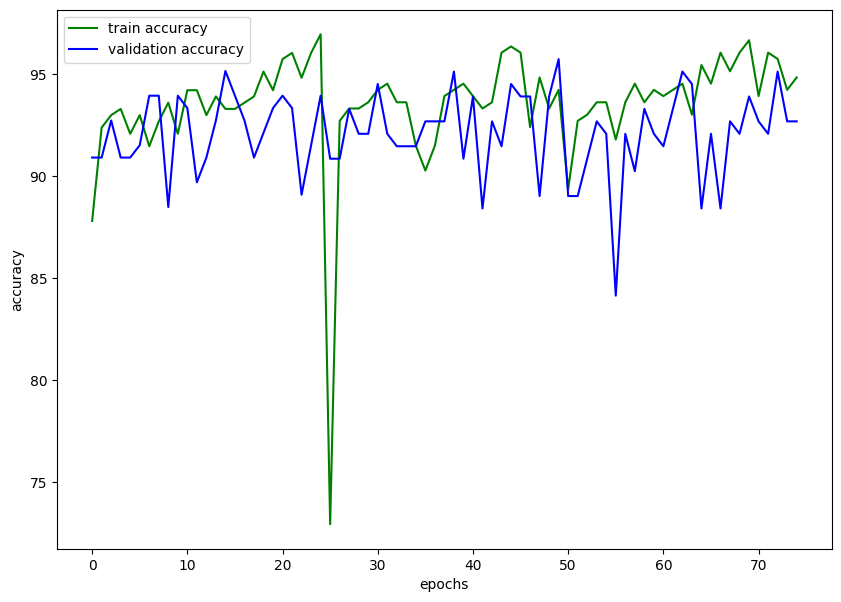

Test_Accuracy : 90.52631578947368
Confusion Matrix on the test set
[[170   8]
 [ 10   2]]
wolf
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0153 Acc: 84.1463%
[Test #1] Loss: 0.0173 Acc: 86.6667% 
Epoch 1 running
[Train #2] Loss: 0.0110 Acc: 92.0732%
[Test #2] Loss: 0.0250 Acc: 86.0606% 
Epoch 2 running
[Train #3] Loss: 0.0114 Acc: 92.0732%
[Test #3] Loss: 0.0157 Acc: 86.6667% 
Epoch 3 running
[Train #4] Loss: 0.0107 Acc: 92.0732%
[Test #4] Loss: 0.0159 Acc: 86.6667% 
Epoch 4 running
[Train #5] Loss: 0.0105 Acc: 91.7683%
[Test #5] Loss: 0.0166 Acc: 86.6667% 
Epoch 5 running
[Train #6] Loss: 0.0096 Acc: 91.1585%
[Test #6] Loss: 0.0187 Acc: 86.6667% 
Epoch 6 running
[Train #7] Loss: 0.0102 Acc: 90.5488%
[Test #7] Loss: 0.0189 Acc: 86.0606% 
Epoch 7 running
[Train #8] Loss: 0.0093 Acc: 92.0732%
[Test #8] Loss: 0.0167 Acc: 86.6667% 
Epoch 8 running
[Train #9] Loss: 0.0094 Acc: 92.0732%
[Test #9] Loss: 0.0205 Acc: 86.6667% 
Epoch 9 running
[Train #10] Loss: 0.0096 Acc: 91.1585%
[Test #10] L

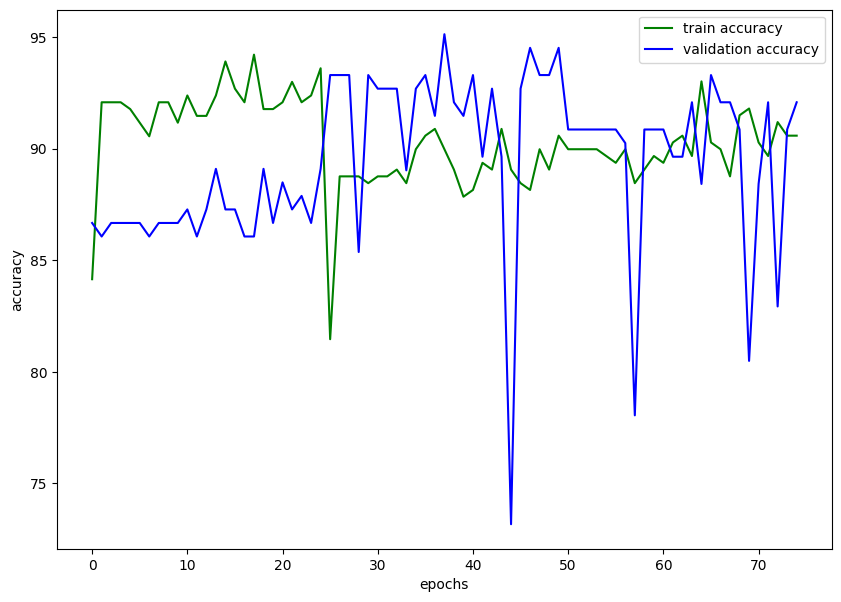

Test_Accuracy : 93.6842105263158
Confusion Matrix on the test set
[[178   0]
 [ 12   0]]
wombat
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0159 Acc: 84.1463%
[Test #1] Loss: 0.0204 Acc: 86.0606% 
Epoch 1 running
[Train #2] Loss: 0.0106 Acc: 92.3780%
[Test #2] Loss: 0.0244 Acc: 86.0606% 
Epoch 2 running
[Train #3] Loss: 0.0103 Acc: 92.3780%
[Test #3] Loss: 0.0240 Acc: 67.2727% 
Epoch 3 running
[Train #4] Loss: 0.0097 Acc: 92.3780%
[Test #4] Loss: 0.0143 Acc: 89.0909% 
Epoch 4 running
[Train #5] Loss: 0.0092 Acc: 92.0732%
[Test #5] Loss: 0.0135 Acc: 82.4242% 
Epoch 5 running
[Train #6] Loss: 0.0083 Acc: 93.5976%
[Test #6] Loss: 0.0126 Acc: 86.6667% 
Epoch 6 running
[Train #7] Loss: 0.0081 Acc: 92.0732%
[Test #7] Loss: 0.0164 Acc: 86.6667% 
Epoch 7 running
[Train #8] Loss: 0.0111 Acc: 91.4634%
[Test #8] Loss: 0.0158 Acc: 86.0606% 
Epoch 8 running
[Train #9] Loss: 0.0091 Acc: 92.9878%
[Test #9] Loss: 0.0123 Acc: 84.2424% 
Epoch 9 running
[Train #10] Loss: 0.0097 Acc: 92.3780%
[Test #10] 

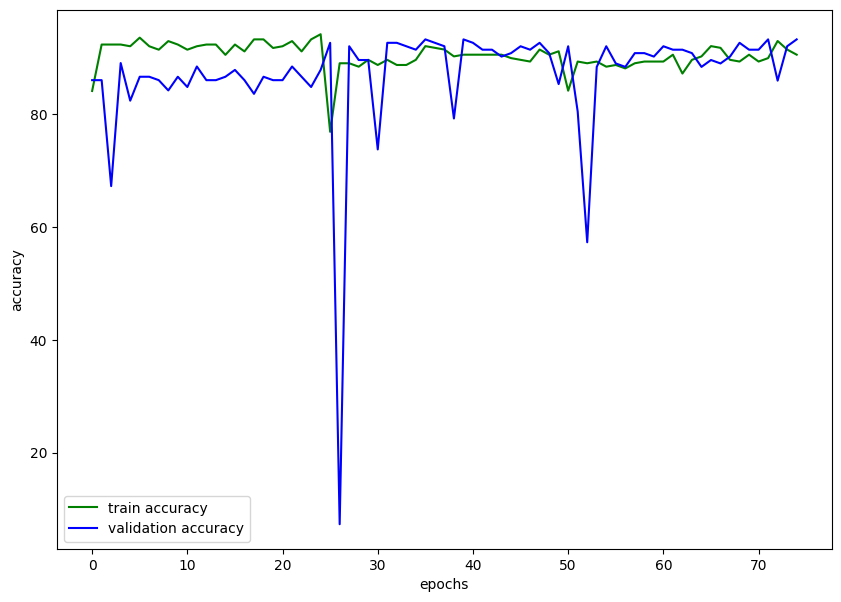

Test_Accuracy : 94.21052631578948
Confusion Matrix on the test set
[[177   1]
 [ 10   2]]
woodpecker
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0176 Acc: 83.8415%
[Test #1] Loss: 0.0128 Acc: 90.9091% 
Epoch 1 running
[Train #2] Loss: 0.0157 Acc: 88.7195%
[Test #2] Loss: 0.0171 Acc: 90.9091% 
Epoch 2 running
[Train #3] Loss: 0.0136 Acc: 89.0244%
[Test #3] Loss: 0.0143 Acc: 90.9091% 
Epoch 3 running
[Train #4] Loss: 0.0125 Acc: 89.6341%
[Test #4] Loss: 0.0128 Acc: 90.3030% 
Epoch 4 running
[Train #5] Loss: 0.0116 Acc: 91.4634%
[Test #5] Loss: 0.0154 Acc: 87.2727% 
Epoch 5 running
[Train #6] Loss: 0.0131 Acc: 89.9390%
[Test #6] Loss: 0.0117 Acc: 90.3030% 
Epoch 6 running
[Train #7] Loss: 0.0107 Acc: 91.7683%
[Test #7] Loss: 0.0163 Acc: 90.9091% 
Epoch 7 running
[Train #8] Loss: 0.0115 Acc: 90.8537%
[Test #8] Loss: 0.0127 Acc: 91.5152% 
Epoch 8 running
[Train #9] Loss: 0.0110 Acc: 91.4634%
[Test #9] Loss: 0.0096 Acc: 92.7273% 
Epoch 9 running
[Train #10] Loss: 0.0110 Acc: 90.5488%
[Test 

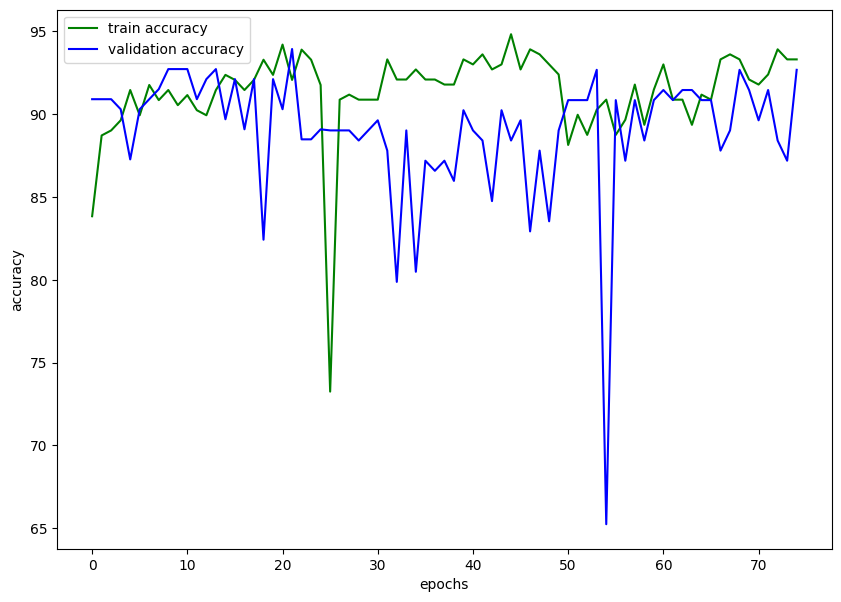

Test_Accuracy : 94.21052631578948
Confusion Matrix on the test set
[[173   5]
 [  6   6]]
zebra
FOLD :  0
Epoch 0 running
[Train #1] Loss: 0.0141 Acc: 85.6707%
[Test #1] Loss: 0.0148 Acc: 89.0909% 
Epoch 1 running
[Train #2] Loss: 0.0126 Acc: 90.8537%
[Test #2] Loss: 0.0179 Acc: 89.0909% 
Epoch 2 running
[Train #3] Loss: 0.0107 Acc: 91.1585%
[Test #3] Loss: 0.0179 Acc: 89.0909% 
Epoch 3 running
[Train #4] Loss: 0.0090 Acc: 92.3780%
[Test #4] Loss: 0.0114 Acc: 90.9091% 
Epoch 4 running
[Train #5] Loss: 0.0082 Acc: 93.2927%
[Test #5] Loss: 0.0318 Acc: 82.4242% 
Epoch 5 running
[Train #6] Loss: 0.0066 Acc: 94.8171%
[Test #6] Loss: 0.0231 Acc: 88.4848% 
Epoch 6 running
[Train #7] Loss: 0.0073 Acc: 94.2073%
[Test #7] Loss: 0.0332 Acc: 88.4848% 
Epoch 7 running
[Train #8] Loss: 0.0071 Acc: 95.1220%
[Test #8] Loss: 0.0203 Acc: 89.0909% 
Epoch 8 running
[Train #9] Loss: 0.0068 Acc: 93.5976%
[Test #9] Loss: 0.0317 Acc: 75.7576% 
Epoch 9 running
[Train #10] Loss: 0.0064 Acc: 93.5976%
[Test #10] 

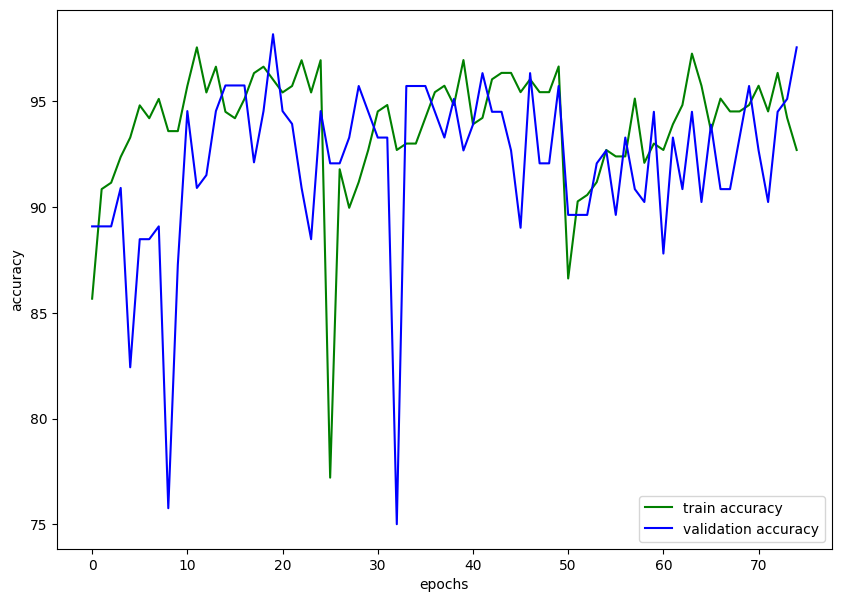

Test_Accuracy : 90.0
Confusion Matrix on the test set
[[162  16]
 [  3   9]]


In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split

class_list , _ = find_classes(train_path)

# Define Stratified K-Fold cross-validation
skf = KFold(n_splits=3, shuffle=True)

for i in range(90):
  print(class_list[i])

  # Make the lists for the confusion Matrix
  true_labels = []
  predicted_labels = []

  # Load Custom Training Dataset And Testing Dataset

  train_dataset = CustomDataset(i , train_path , transform = transforms_train)
  test_dataset = CustomDataset(i , test_path , transform = transforms_test)

  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=24, shuffle=True, num_workers=2)

  #### Train model

  from sklearn.model_selection import KFold

  train_loss=[]
  train_accuracy=[]
  test_loss=[]
  test_accuracy=[]


  # Extract indices
  indices = list(range(len(train_dataset)))
  # Define Stratified K-Fold cross-validation
  skf = KFold(n_splits=3, shuffle=True)

  # Iterate over folds
  for fold, (train_index, val_index) in enumerate(skf.split(indices, [train_dataset.label[idx] for idx in indices])):

      val_true_labels = []
      val_predicted_labels = []

      print("FOLD : " , fold)
      train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
      val_sampler = torch.utils.data.SubsetRandomSampler(val_index)

      # Create data loaders for training and validation
      train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=24, sampler=train_sampler, num_workers=4)
      val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=24, sampler=val_sampler, num_workers=4)

      model = ResNet50(2)

      # Since Resnet50 has 1000 out_features we will need to change it because our model has 1000 features.

      num_features = model.fc.in_features
      # Add a fully-connected layer for classification
      model.fc = nn.Linear(num_features, 2)
      model = model.to(device)

      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)




      num_epochs = 25
      for epoch in range(num_epochs):
        epoch_true_labels = []
        epoch_predicted_labels = []
        print("Epoch {} running".format(epoch)) #(printing message)
        model.train()
        running_loss = 0
        running_corrects = 0
        total_train = 0

        # Now Load A Batch Of Images

        for i , (inputs , labels) in enumerate(train_loader):
          inputs = inputs.to(device)
          labels = labels.to(device)

          # Forward Inputs and Get Outputs
          optimizer.zero_grad()
          outputs = model.forward(inputs)

          _ , preds = torch.max(outputs , 1)

          loss = criterion(outputs , labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          total_train += labels.size(0)

          running_corrects += torch.sum(preds == labels.data).item()

        epoch_loss = running_loss / len(train_sampler)
        epoch_acc = running_corrects / total_train *100

        # Append Result

        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        # Print Progress

        print('[Train #{}] Loss: {:.4f} Acc: {:.4f}%'.format(epoch+1, epoch_loss, epoch_acc))

        # Testing Part

        model.eval()
        with torch.no_grad():
          running_loss = 0
          running_corrects = 0
          total_val = 0

          for i , (inputs , labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model.forward(inputs)
            _ , preds = torch.max(outputs , 1)
            loss = criterion(outputs , labels)

            running_loss += loss.item()
            total_val += labels.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            val_true_labels.extend(labels.cpu().numpy())
            val_predicted_labels.extend(preds.cpu().numpy())
            epoch_true_labels.extend(labels.cpu().numpy())
            epoch_predicted_labels.extend(preds.cpu().numpy())



          epoch_loss = running_loss / len(val_sampler)
          epoch_acc = running_corrects / total_val *100

          # Append result

          test_loss.append(epoch_loss)
          test_accuracy.append(epoch_acc)

          # Print progress
          print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% '.format(epoch+1, epoch_loss, epoch_acc))

          # Print Confusion Matrix After every epoch

      print('Confusion Matrix on the validation set Fold :' , fold)
      print(confusion_matrix(val_true_labels, val_predicted_labels))

  plt.figure(figsize=(10, 7))
  train_accuracy_tensor = torch.tensor(train_accuracy).cpu()
  test_accuracy_tensor = torch.tensor(test_accuracy).cpu()

  plt.plot(train_accuracy_tensor, color='green', label='train accuracy')
  plt.plot(test_accuracy_tensor, color='blue', label='validation accuracy')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

  with torch.no_grad():
    running_corrects = 0
    total_test = 0

    for i , (inputs , labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      _ , preds = torch.max(outputs , 1)
      running_corrects += torch.sum(preds == labels.data).item()
      total_test += labels.size(0)
      true_labels.extend(labels.cpu().numpy())
      predicted_labels.extend(preds.cpu().numpy())

    epoch_acc = running_corrects / total_test *100

    print("Test_Accuracy :" , epoch_acc)

    print('Confusion Matrix on the test set')
    print(confusion_matrix(true_labels, predicted_labels))














